In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline

In [2]:
from statsmodels.tsa.arima.model import ARIMA

In [3]:
from datetime import timedelta

In [4]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pmdarima as pm

In [6]:
from pmdarima.preprocessing import LogEndogTransformer
from pmdarima.utils import tsdisplay
from pmdarima.preprocessing import BoxCoxEndogTransformer
from pmdarima.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse

### Retrieving Datasets

In [7]:
msft = pd.read_csv('msftr.csv', parse_dates=['Date'], index_col='Date')

In [8]:
dow_jones = pd.read_csv('dow_iar.csv', parse_dates=['Date'], index_col='Date')

In [9]:
dow_close= dow_jones['Close']
msft_close = msft['Close']

In [10]:
msft_predict = pd.read_csv('msft_predict.csv', parse_dates=['Date'], index_col='Date')
msft_predict.head()

High         Low        Open       Close      Volume  \
Date                                                                     
2022-07-22  265.329987  259.070007  265.239990  260.359985  21881300.0   
2022-07-25  261.500000  256.809998  261.000000  258.829987  21056000.0   
2022-07-26  259.880005  249.570007  259.859985  251.899994  39348000.0   
2022-07-27  270.049988  258.850006  261.160004  268.739990  45994000.0   
2022-07-28  277.839996  267.869995  269.750000  276.410004  33459300.0   

             Adj Close  
Date                    
2022-07-22  259.808502  
2022-07-25  258.281769  
2022-07-26  251.366440  
2022-07-27  268.170776  
2022-07-28  275.824524

#### Looking for the corr between msft price and dj price divided by 100

In [11]:
dow_close_100 = dow_close.div(100)

### Combining two prices

In [12]:
msft_dow = pd.concat([msft_close, dow_close_100], axis=1)

In [13]:
msft_dow.columns = ['Msft Close', 'Dow Jones Close']
print(msft_dow.head())

            Msft Close  Dow Jones Close
Date                                   
2017-01-03   62.580002       198.817598
2017-01-04   62.299999       199.421602
2017-01-05   62.299999       198.992891
2017-01-06   62.840000       199.638008
2017-01-09   62.639999       198.873809


### Shifting dow jones prices one period (in this case day) a head 

In [14]:
msft_dow.head()

Msft Close  Dow Jones Close
Date                                   
2017-01-03   62.580002       198.817598
2017-01-04   62.299999       199.421602
2017-01-05   62.299999       198.992891
2017-01-06   62.840000       199.638008
2017-01-09   62.639999       198.873809

In [15]:
msft_dow['dj shifted'] = msft_dow['Dow Jones Close'].shift(periods=1)

In [16]:
msft_dow['Msft Close'].max()

343.1099853515625

In [17]:
msft_dow['msft diffed'] = msft_dow['Msft Close'].diff()

In [18]:
msft_dow.head()

Msft Close  Dow Jones Close  dj shifted  msft diffed
Date                                                            
2017-01-03   62.580002       198.817598         NaN          NaN
2017-01-04   62.299999       199.421602  198.817598    -0.280003
2017-01-05   62.299999       198.992891  199.421602     0.000000
2017-01-06   62.840000       199.638008  198.992891     0.540001
2017-01-09   62.639999       198.873809  199.638008    -0.200001

### Suitable dataset for the study

In [19]:
df = msft_dow.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1396 entries, 2017-01-04 to 2022-07-21
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Msft Close       1396 non-null   float64
 1   Dow Jones Close  1396 non-null   float64
 2   dj shifted       1396 non-null   float64
 3   msft diffed      1396 non-null   float64
dtypes: float64(4)
memory usage: 54.5 KB


### Applying interpolation to the holiday days. 

In [20]:
df = df.asfreq('B').interpolate()
df.isna().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1447 entries, 2017-01-04 to 2022-07-21
Freq: B
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Msft Close       1447 non-null   float64
 1   Dow Jones Close  1447 non-null   float64
 2   dj shifted       1447 non-null   float64
 3   msft diffed      1447 non-null   float64
dtypes: float64(4)
memory usage: 56.5 KB


# Business Days Decomposition

In [21]:
ts_dicomposition_bday = seasonal_decompose(df['Msft Close'], model='additive', period=255)
trend_estimate_bday = ts_dicomposition_bday.trend
seasonal_estimate_bday = ts_dicomposition_bday.seasonal
residual_estimate_bday = ts_dicomposition_bday.resid

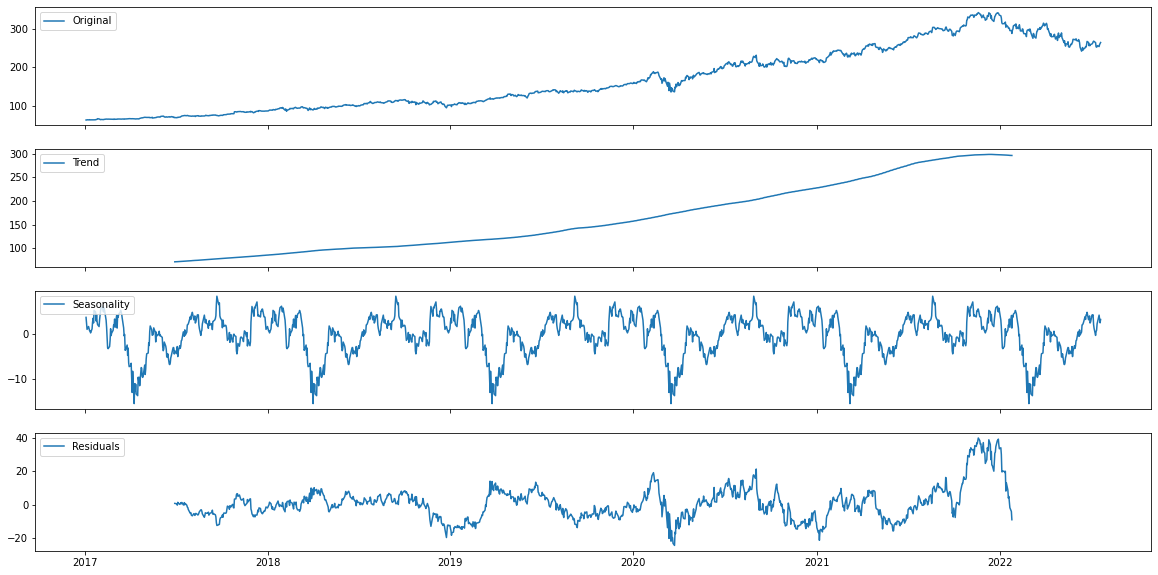

In [22]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(20)
# First plot to the Original time series
axes[0].plot(df['Msft Close'], label='Original') 
axes[0].legend(loc='upper left');
# second plot to be for trend
axes[1].plot(trend_estimate_bday, label='Trend')
axes[1].legend(loc='upper left');
# third plot to be Seasonality component
axes[2].plot(seasonal_estimate_bday, label='Seasonality')
axes[2].legend(loc='upper left');
# last last plot to be Residual component
axes[3].plot(residual_estimate_bday, label='Residuals')
axes[3].legend(loc='upper left'); plt.show()

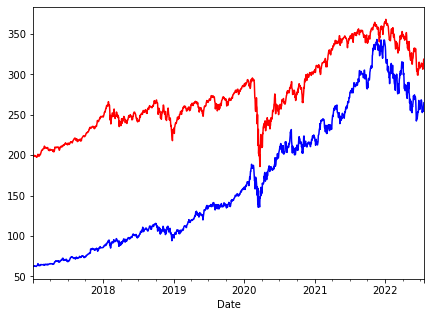

In [23]:
fig, ax = plt.subplots(figsize = (7,5))
df['dj shifted'].plot(ax=ax, color='r')
df['Msft Close'].plot(ax=ax, color='b')
plt.show()

### Correlation is 0.937 between microsoft price and dow jones yesterday's price. 

In [24]:
df['dj shifted'].corr(df['Msft Close'])

0.9376893556293079

# Exercises

### Adfuller test for the 1 degree of diff for complete dataset.

In [25]:
adfuller_complete_dif1 = adfuller(df['msft diffed'])
print(adfuller_complete_dif1)

(-8.575131769217634, 8.001138686632238e-14, 22, 1424, {'1%': -3.434950510599593, '5%': -2.8635718069244227, '10%': -2.5678517223401403}, 7424.604158261411)


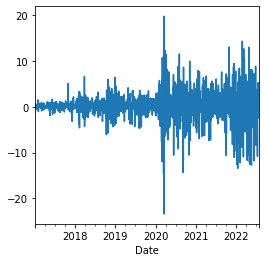

In [26]:
fig, ax = plt.subplots(figsize = (4,4))
df['msft diffed'].plot(ax=ax)
plt.show()

### ACF and PACF graphs to find order fo ARIMA. 

C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


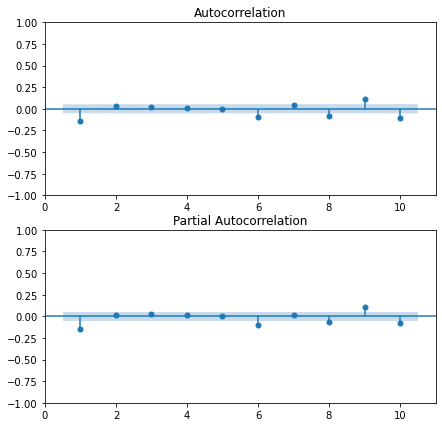

In [27]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7, 7))
plot_acf(df['msft diffed'], lags=10, zero=False, ax=ax1)
plot_pacf(df['msft diffed'], lags=10, zero=False, ax=ax2)
plt.show()

### Setting frequency of the time series to the Business Days. 

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1447 entries, 2017-01-04 to 2022-07-21
Freq: B
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Msft Close       1447 non-null   float64
 1   Dow Jones Close  1447 non-null   float64
 2   dj shifted       1447 non-null   float64
 3   msft diffed      1447 non-null   float64
dtypes: float64(4)
memory usage: 56.5 KB


### AIC and BIC values of some orders

In [29]:
for p in range(4):
    for q in range(4):
        model_1 = SARIMAX(df['Msft Close'], order=(p,1,q), enforce_stationary=True, enforce_invertibility=True)
        results_aic_bic = model_1.fit(method_kwargs={"warn_convergence": False})
        print(p, q, results_aic_bic.aic, results_aic_bic.bic)

C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: method_kwargs. After release 0.14, this will raise.
  warnings.warn(


0 0 7544.554319279609 7549.830875682328
0 1 7511.088779540679 7521.641892346116
0 2 7511.5031017587835 7527.332770966939
0 3 7513.382122483514 7534.488348094388
1 0 7509.711201479642 7520.264314285079
1 1 7511.674533592165 7527.504202800321
1 2 7513.397365595159 7534.503591206033
1 3 7509.9622645885665 7536.34504660216
2 0 7511.669522126307 7527.499191334463
2 1 7513.654062955068 7534.760288565943


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2 2 7514.966256863979 7541.349038877573
2 3 7517.388291392601 7549.047629808913
3 0 7513.493826808174 7534.600052419049
3 1 7515.453613011095 7541.8363950246885


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3 2 7482.445930550701 7514.105268967013
3 3 7481.1058604828095 7518.041755301841


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### From ACF, PACF and AIC, BIC values I've decided the order of the model (1,1,0)

In [30]:
model_1_0_arima = SARIMAX(df['Msft Close'], order = (1,1,0), trend = 'c')

In [31]:
result_model_1_0_arima = model_1_0_arima.fit()

In [32]:
forecast_model_1_0_arima = result_model_1_0_arima.get_prediction(start=-30)

In [33]:
mean_forecast_model_1_0_arima = forecast_model_1_0_arima.predicted_mean

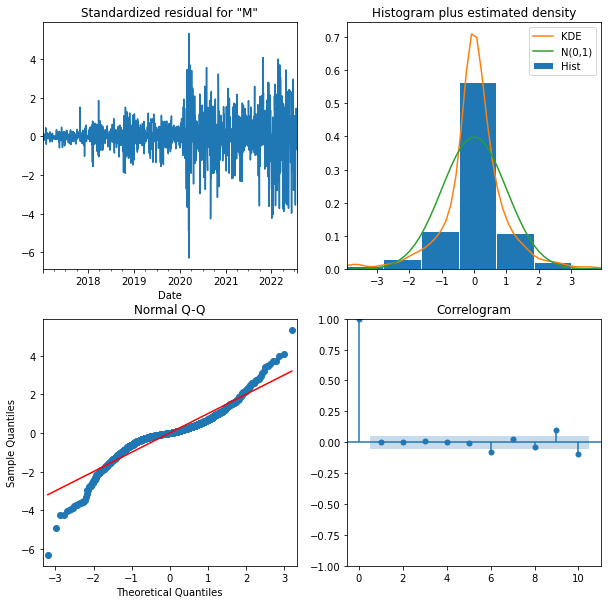

In [34]:
result_model_1_0_arima.plot_diagnostics(figsize = (10,10))
plt.show()

In [35]:
print(result_model_1_0_arima.summary())

                               SARIMAX Results                                
Dep. Variable:             Msft Close   No. Observations:                 1447
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -3751.045
Date:                Fri, 23 Sep 2022   AIC                           7508.090
Time:                        02:22:20   BIC                           7523.920
Sample:                    01-04-2017   HQIC                          7513.998
                         - 07-21-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1624      0.087      1.867      0.062      -0.008       0.333
ar.L1         -0.1607      0.014    -11.568      0.000      -0.188      -0.133
sigma2        10.4884      0.217     48.348      0.0

In [36]:
type(mean_forecast_model_1_0_arima)

pandas.core.series.Series

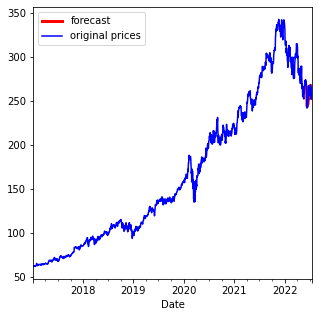

In [37]:
fig, ax = plt.subplots(figsize=(5,5))
mean_forecast_model_1_0_arima.plot(ax=ax, color='r', label='forecast', linewidth=3)
df['Msft Close'].plot(ax=ax, color='b', label='original prices')
plt.legend()
plt.show()

### applying ARIMAX with Dow Jones Exo variable. 

In [38]:
df.head()

Msft Close  Dow Jones Close  dj shifted  msft diffed
Date                                                            
2017-01-04   62.299999       199.421602  198.817598    -0.280003
2017-01-05   62.299999       198.992891  199.421602     0.000000
2017-01-06   62.840000       199.638008  198.992891     0.540001
2017-01-09   62.639999       198.873809  199.638008    -0.200001
2017-01-10   62.619999       198.555293  198.873809    -0.020000

In [39]:
arimax_model_1_0 = SARIMAX(df['Msft Close'], order = (1,1,0), trend = 'c', exog=df['dj shifted'])

In [40]:
result_arimax_model_1_0 = arimax_model_1_0.fit()

In [41]:
forecast_arimax_model_1_0 = result_arimax_model_1_0.get_prediction(start=-30)

In [42]:
mean_forecast_result_arimax_model_1_0 = forecast_arimax_model_1_0.predicted_mean

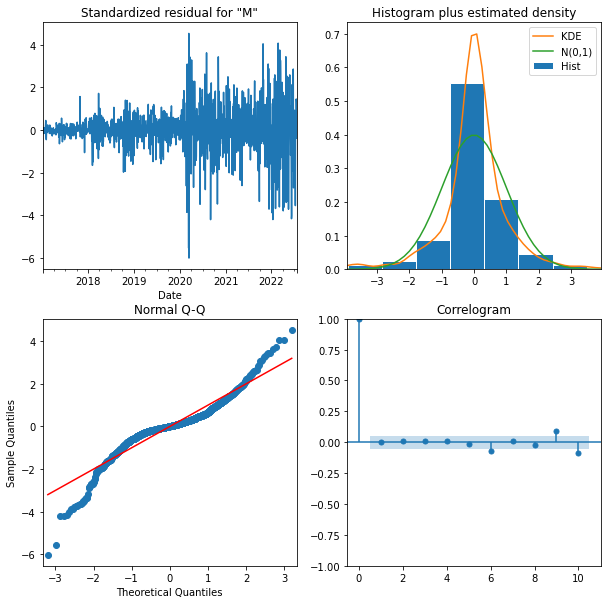

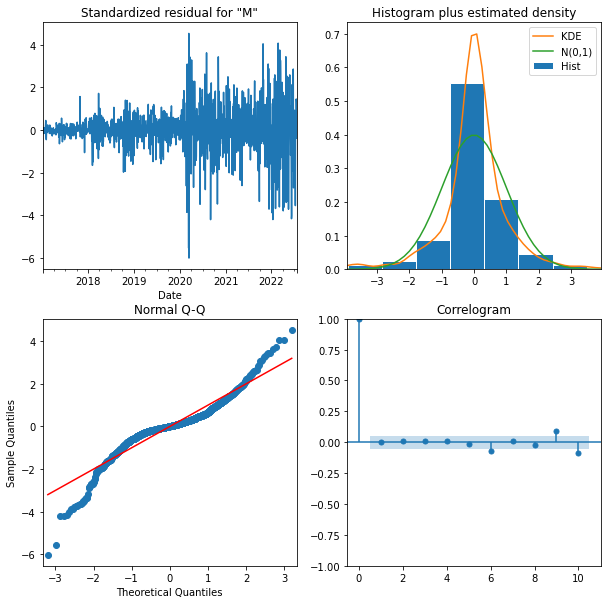

In [43]:
result_arimax_model_1_0.plot_diagnostics(figsize=(10,10))

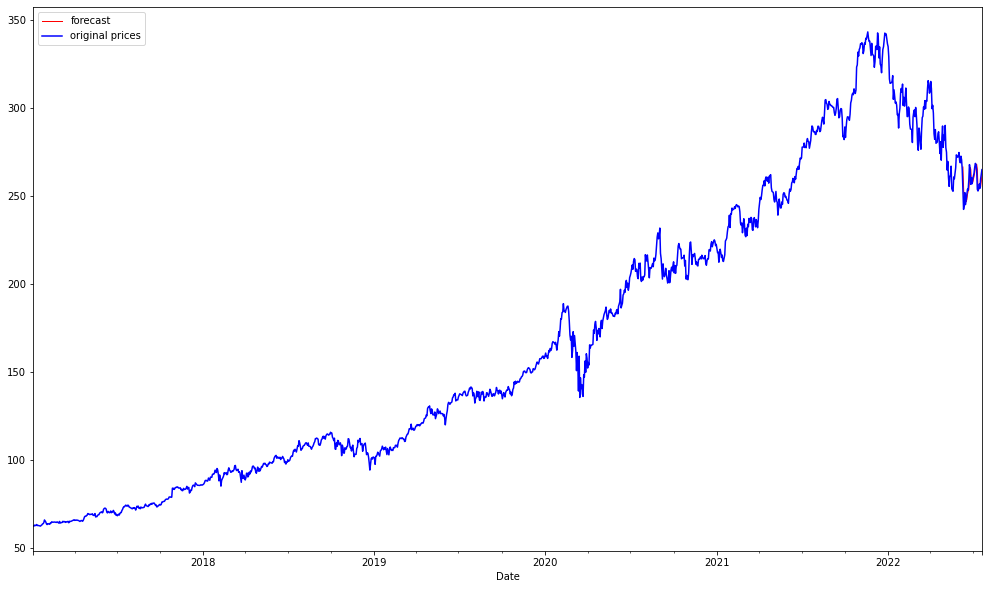

In [44]:
fig, ax = plt.subplots(figsize=(17,10))
mean_forecast_result_arimax_model_1_0.plot(ax=ax, color='r', label='forecast', linewidth=1)
df['Msft Close'].plot(ax=ax, color='b', label='original prices')
plt.legend()
plt.show()

In [45]:
print(result_arimax_model_1_0.summary())

                               SARIMAX Results                                
Dep. Variable:             Msft Close   No. Observations:                 1447
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -3737.347
Date:                Fri, 23 Sep 2022   AIC                           7482.693
Time:                        02:22:21   BIC                           7503.800
Sample:                    01-04-2017   HQIC                          7490.571
                         - 07-21-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1593      0.087      1.830      0.067      -0.011       0.330
dj shifted    -0.2025      0.022     -9.100      0.000      -0.246      -0.159
ar.L1         -0.0175      0.024     -0.721      0.4

### ARIMA since 2020

In [46]:
df_2020 = df.loc['2020-01-01':]
df_2020.head()

Msft Close  Dow Jones Close  dj shifted  msft diffed
Date                                                            
2020-01-01  159.159996       287.036201  285.002900     1.514999
2020-01-02  160.619995       288.688008  285.384395     2.919998
2020-01-03  158.619995       286.348809  288.688008    -2.000000
2020-01-06  159.029999       287.033809  286.348809     0.410004
2020-01-07  157.580002       285.836797  287.033809    -1.449997

<function matplotlib.pyplot.show(close=None, block=None)>

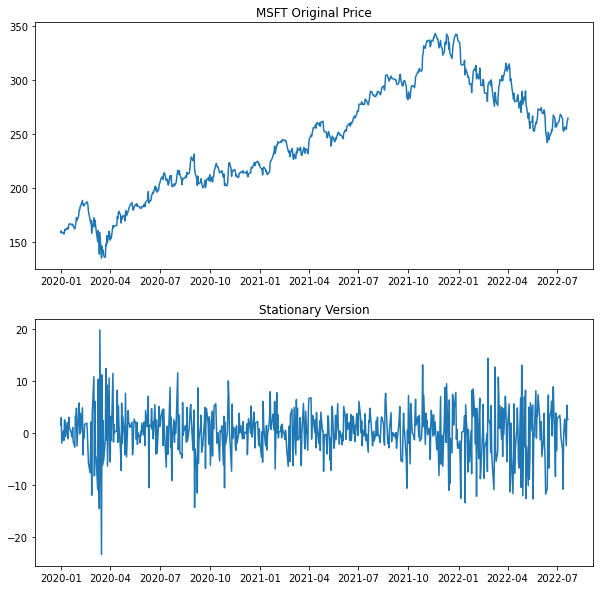

In [47]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].plot(df_2020['Msft Close'])
ax[1].plot(df_2020['msft diffed'])
ax[0].set_title('MSFT Original Price')
ax[1].set_title('Stationary Version')
plt.show

In [48]:
df_2020_stationary = adfuller(df_2020['msft diffed'])
print(df_2020_stationary)

(-8.569312105003636, 8.280344964690016e-14, 9, 657, {'1%': -3.440342440623255, '5%': -2.8659491890487026, '10%': -2.569118060113657}, 3824.587170375421)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


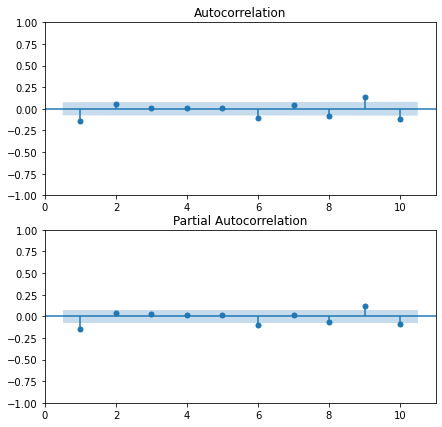

In [49]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7, 7))
plot_acf(df_2020['msft diffed'], lags=10, zero=False, ax=ax1)
plot_pacf(df_2020['msft diffed'], lags=10, zero=False, ax=ax2)
plt.show()

In [50]:
for p in range(4):
    for q in range(4):
        model_1 = SARIMAX(df_2020['Msft Close'], order=(p,1,q))
        results_aic_bic = model_1.fit()
        print(p, q, results_aic_bic.aic, results_aic_bic.bic)

0 0 3923.9915985054954 3928.4928881760356
0 1 3908.837415906053 3917.839995247134
0 2 3909.310081707431 3922.813950719052
0 3 3911.3075372126477 3929.312695894809
1 0 3907.6406918921784 3916.6432712332594
1 1 3909.375773127306 3922.879642138927
1 2 3911.302863133762 3929.3080218159234
1 3 3910.998777497995 3933.505225850697
2 0 3909.3509669451014 3922.8548359567226
2 1 3911.295306559729 3929.3004652418904


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2 2 3913.285578325589 3935.792026678291


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2 3 3908.7802462249283 3935.7879842481707
3 0 3911.314180103006 3929.3193387851675
3 1 3913.2897905570944 3935.7962389097966
3 2 3915.2931495177654 3942.300887541008
3 3 3898.5972730530516 3930.106300746834


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [51]:
model_2020_1_1_arima = SARIMAX(df_2020['Msft Close'], order = (1,1,1), trend='c')

In [52]:
result_model_2020_1_1_arima = model_2020_1_1_arima.fit()

In [53]:
forecast_result_model_2020_1_1_arima = result_model_2020_1_1_arima.get_prediction(start=-30)

In [54]:
mean_forecast_result_model_2020_1_1_arima = forecast_result_model_2020_1_1_arima.predicted_mean

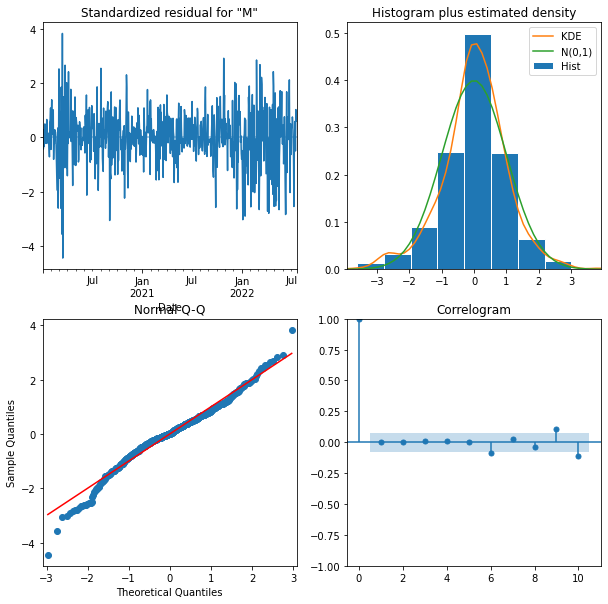

In [55]:
result_model_2020_1_1_arima.plot_diagnostics(figsize=(10,10))
plt.show()

In [56]:
print(result_model_2020_1_1_arima.summary())

                               SARIMAX Results                                
Dep. Variable:             Msft Close   No. Observations:                  667
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1951.156
Date:                Fri, 23 Sep 2022   AIC                           3910.313
Time:                        02:22:24   BIC                           3928.318
Sample:                    01-01-2020   HQIC                          3917.289
                         - 07-21-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2008      0.208      0.966      0.334      -0.206       0.608
ar.L1         -0.2706      0.174     -1.552      0.121      -0.612       0.071
ma.L1          0.1074      0.183      0.587      0.5

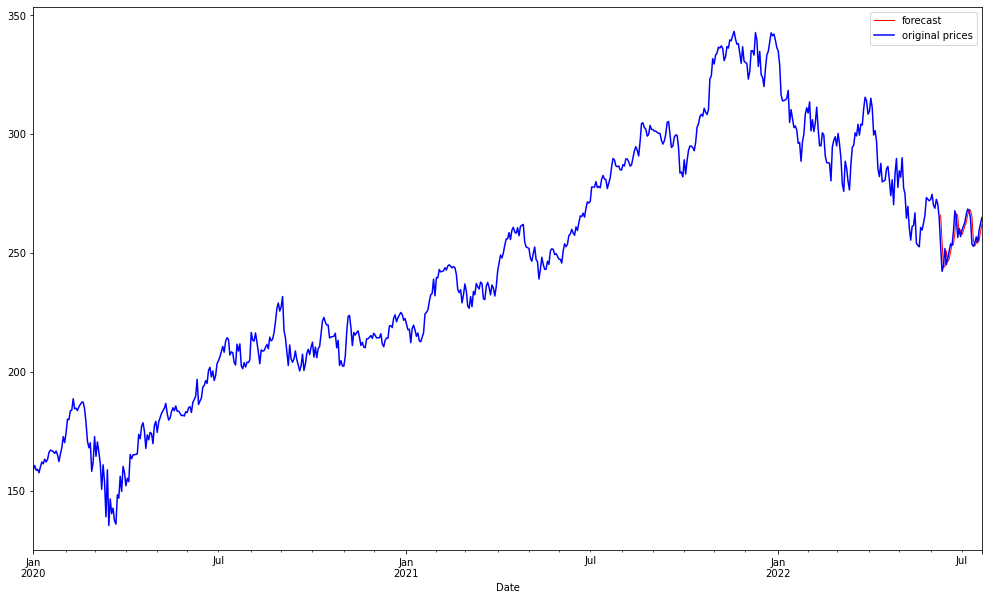

In [57]:
fig, ax = plt.subplots(figsize=(17,10))
mean_forecast_result_model_2020_1_1_arima.plot(ax=ax, color='r', label='forecast', linewidth=1)
df_2020['Msft Close'].plot(ax=ax, color='b', label='original prices')
plt.legend()
plt.show()

### 2020 arimax

In [58]:
model_2020_1_1_arimax = SARIMAX(df_2020['Msft Close'], order=(1,1,1), exog = df_2020['dj shifted'], trend='c')

In [59]:
result_model_2020_1_1_arimax = model_2020_1_1_arimax.fit()

In [60]:
forecast_result_model_2020_1_1_arimax = result_model_2020_1_1_arimax.get_prediction(start=-30)

In [61]:
mean_forecast_result_model_2020_1_1_arimax = forecast_result_model_2020_1_1_arimax.predicted_mean

In [62]:
print(result_model_2020_1_1_arimax.summary())

                               SARIMAX Results                                
Dep. Variable:             Msft Close   No. Observations:                  667
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1941.845
Date:                Fri, 23 Sep 2022   AIC                           3893.691
Time:                        02:22:25   BIC                           3916.197
Sample:                    01-01-2020   HQIC                          3902.411
                         - 07-21-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0890      0.174      0.511      0.609      -0.252       0.430
dj shifted    -0.2737      0.039     -7.035      0.000      -0.350      -0.197
ar.L1          0.4855      0.939      0.517      0.6

In [63]:
df_2021 = df.loc['2021':]

In [64]:
df_2021

Msft Close  Dow Jones Close  dj shifted  msft diffed
Date                                                            
2021-01-01  220.055000       304.151855  305.080205    -1.994995
2021-01-04  217.690002       302.238906  306.064805    -4.729996
2021-01-05  217.899994       303.915996  302.238906     0.209991
2021-01-06  212.250000       308.294004  303.915996    -5.649994
2021-01-07  218.289993       310.411309  308.294004     6.039993
...                ...              ...         ...          ...
2022-07-15  256.720001       312.882598  306.301699     2.639999
2022-07-18  254.250000       310.726094  312.882598    -2.470001
2022-07-19  259.529999       318.270508  310.726094     5.279999
2022-07-20  262.269989       318.748398  318.270508     2.739990
2022-07-21  264.839996       320.369004  318.748398     2.570007

[405 rows x 4 columns]

In [65]:
adfuller_2021 = adfuller(df_2021['msft diffed'])
print(adfuller_2021)

(-20.697577566856616, 0.0, 0, 404, {'1%': -3.44664043608676, '5%': -2.868720756230461, '10%': -2.5705951311145965}, 2291.409876343156)


### Experiments for convertion to stationary. 

In [66]:
adfuller_2021_sqrt = adfuller(np.sqrt(df_2021['Msft Close']))
print(adfuller_2021_sqrt)

(-2.000278445262814, 0.2864510239712823, 0, 404, {'1%': -3.44664043608676, '5%': -2.868720756230461, '10%': -2.5705951311145965}, -438.33323191544355)


In [67]:
adfuller_2021_cuberoot = adfuller(np.cbrt(df_2021['Msft Close']))
print(adfuller_2021_cuberoot)

(-2.017619977600631, 0.2789011897852651, 0, 404, {'1%': -3.44664043608676, '5%': -2.868720756230461, '10%': -2.5705951311145965}, -1476.6254954081821)


In [68]:
adfuller_2021_log = adfuller(np.log(df_2021['Msft Close']))
print(adfuller_2021_log)

(-2.053993540550188, 0.2634116179588355, 0, 404, {'1%': -3.44664043608676, '5%': -2.868720756230461, '10%': -2.5705951311145965}, -2077.734207138624)


In [69]:
df2021_log = np.log(df_2021['Msft Close'])
df2021_log_dif = df2021_log.diff()
df2021_log_dif.head()

Date
2021-01-01         NaN
2021-01-04   -0.010805
2021-01-05    0.000964
2021-01-06   -0.026271
2021-01-07    0.028060
Freq: B, Name: Msft Close, dtype: float64

In [70]:
df2021_log_dif = df2021_log_dif.dropna()

In [71]:
adfuller_df2021_log_dif = adfuller(df2021_log_dif)
print(adfuller_df2021_log_dif)

(-21.25170734037532, 0.0, 0, 403, {'1%': -3.4466811208382437, '5%': -2.8687386420385494, '10%': -2.5706046655665635}, -2071.5449621141597)


In [72]:
type(df2021_log_dif)

pandas.core.series.Series

In [73]:
df.head()

Msft Close  Dow Jones Close  dj shifted  msft diffed
Date                                                            
2017-01-04   62.299999       199.421602  198.817598    -0.280003
2017-01-05   62.299999       198.992891  199.421602     0.000000
2017-01-06   62.840000       199.638008  198.992891     0.540001
2017-01-09   62.639999       198.873809  199.638008    -0.200001
2017-01-10   62.619999       198.555293  198.873809    -0.020000

In [74]:
qwe = df.loc['2020-02':]['msft diffed']

In [75]:
df['msft sdiffed'] = df['msft diffed'].diff()
dq = df.dropna()
print(dq.head())

            Msft Close  Dow Jones Close  dj shifted  msft diffed  msft sdiffed
Date                                                                          
2017-01-05   62.299999       198.992891  199.421602     0.000000      0.280003
2017-01-06   62.840000       199.638008  198.992891     0.540001      0.540001
2017-01-09   62.639999       198.873809  199.638008    -0.200001     -0.740002
2017-01-10   62.619999       198.555293  198.873809    -0.020000      0.180000
2017-01-11   63.189999       199.542793  198.555293     0.570000      0.590000


In [76]:
ewq = dq.loc['2020-02':]['msft sdiffed']

In [77]:
adfuller_qwe = adfuller(ewq)
print(adfuller_qwe)

(-10.21194321494423, 5.6084147024023966e-18, 20, 623, {'1%': -3.440890045708521, '5%': -2.8661904001753618, '10%': -2.569246579178572}, 3721.2796344328513)


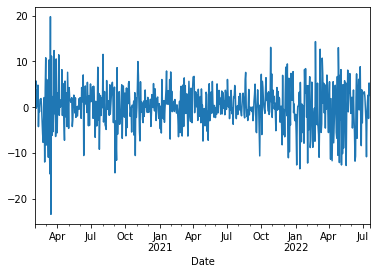

In [78]:
qwe.plot()
plt.show()

C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


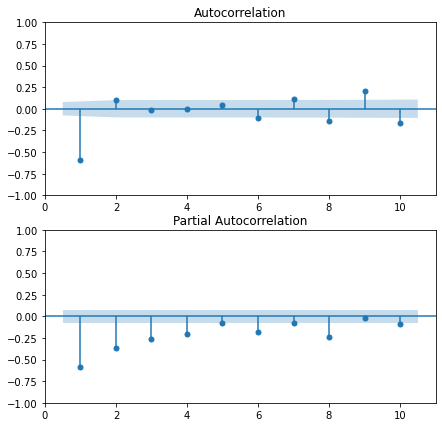

In [79]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7, 7))
plot_acf(ewq, lags=10, zero=False, ax=ax1)
plot_pacf(ewq, lags=10, zero=False, ax=ax2)
plt.show()

In [80]:
model_10_1 = SARIMAX(qwe, order=(4,1,1))

In [81]:
result_model_10_1 = model_10_1.fit()

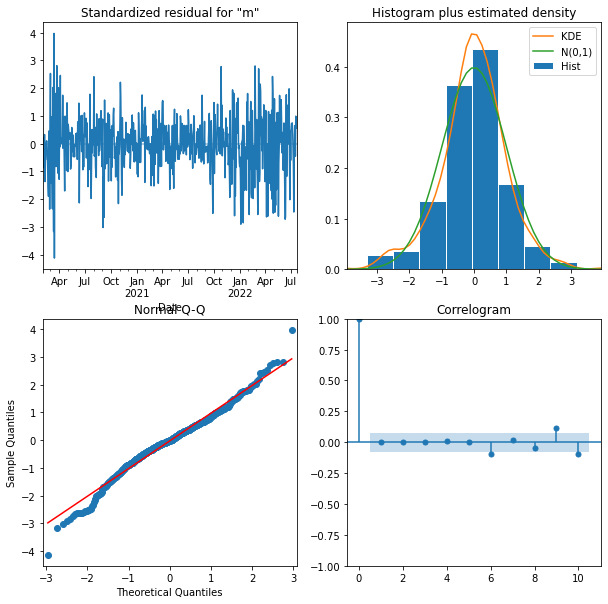

In [82]:
result_model_10_1.plot_diagnostics(figsize=(10,10))
plt.show()

# end of exercises

C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


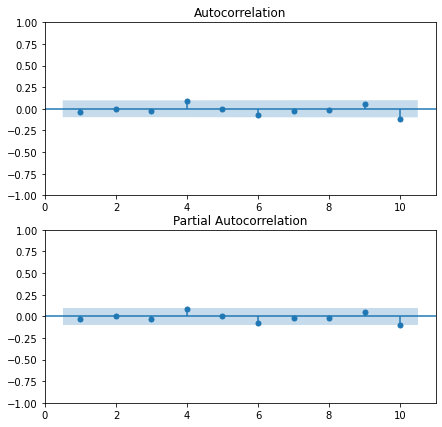

In [83]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7, 7))
plot_acf(df_2021['msft diffed'], lags=10, zero=False, ax=ax1)
plot_pacf(df_2021['msft diffed'], lags=10, zero=False, ax=ax2)
plt.show()

### Creating function to determine the order of models. 

In [84]:
def orderplot(dd):
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7, 7))
    plot_acf(df[dd:]['msft diffed'], lags=10, zero=False, ax=ax1)
    plot_pacf(df[dd:]['msft diffed'], lags=10, zero=False, ax=ax2, method='ywm')
    plt.show()
    adf_result = adfuller(df[dd:]['msft diffed'])
    for p in range(4):
        for q in range(4):
            model_1 = SARIMAX(df[dd:]['Msft Close'], order=(p,1,q), enforce_invertibility=True, enforce_stationary=True)
            results_aic_bic = model_1.fit()
            print('AR>',p, 'MA>',q, 'AIC>',results_aic_bic.aic, 'BIC>',results_aic_bic.bic)
    return plt.show(), print(p, q, results_aic_bic.aic, results_aic_bic.bic), print('ADF TEST >',adf_result)

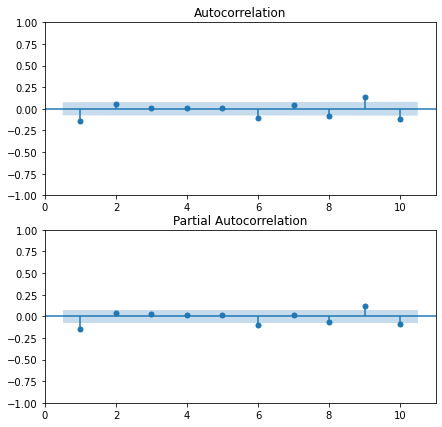

AR> 0 MA> 0 AIC> 3923.9915985054954 BIC> 3928.4928881760356
AR> 0 MA> 1 AIC> 3908.837415906053 BIC> 3917.839995247134
AR> 0 MA> 2 AIC> 3909.310081707431 BIC> 3922.813950719052
AR> 0 MA> 3 AIC> 3911.3075372126477 BIC> 3929.312695894809
AR> 1 MA> 0 AIC> 3907.6406918921784 BIC> 3916.6432712332594
AR> 1 MA> 1 AIC> 3909.375773127306 BIC> 3922.879642138927
AR> 1 MA> 2 AIC> 3911.302863133762 BIC> 3929.3080218159234
AR> 1 MA> 3 AIC> 3910.998777497995 BIC> 3933.505225850697
AR> 2 MA> 0 AIC> 3909.3509669451014 BIC> 3922.8548359567226
AR> 2 MA> 1 AIC> 3911.295306559729 BIC> 3929.3004652418904


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 3913.285578325589 BIC> 3935.792026678291


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 2 MA> 3 AIC> 3908.7802462249283 BIC> 3935.7879842481707
AR> 3 MA> 0 AIC> 3911.314180103006 BIC> 3929.3193387851675
AR> 3 MA> 1 AIC> 3913.2897905570944 BIC> 3935.7962389097966
AR> 3 MA> 2 AIC> 3915.2931495177654 BIC> 3942.300887541008
AR> 3 MA> 3 AIC> 3898.5972730530516 BIC> 3930.106300746834
3 3 3898.5972730530516 3930.106300746834
ADF TEST > (-8.569312105003636, 8.280344964690016e-14, 9, 657, {'1%': -3.440342440623255, '5%': -2.8659491890487026, '10%': -2.569118060113657}, 3824.587170375421)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [85]:
orderplot('2020')

### Finding extreme day points in MSFT Close price to choose different start points. 

In [86]:
msft_close = df['Msft Close']

In [87]:
pct_change = (msft_close.pct_change().fillna(0))*100

In [88]:
msft_close

Date
2017-01-04     62.299999
2017-01-05     62.299999
2017-01-06     62.840000
2017-01-09     62.639999
2017-01-10     62.619999
                 ...    
2022-07-15    256.720001
2022-07-18    254.250000
2022-07-19    259.529999
2022-07-20    262.269989
2022-07-21    264.839996
Freq: B, Name: Msft Close, Length: 1447, dtype: float64

In [89]:
pct_change

Date
2017-01-04    0.000000
2017-01-05    0.000000
2017-01-06    0.866775
2017-01-09   -0.318270
2017-01-10   -0.031929
                ...   
2022-07-15    1.039043
2022-07-18   -0.962138
2022-07-19    2.076696
2022-07-20    1.055751
2022-07-21    0.979909
Freq: B, Name: Msft Close, Length: 1447, dtype: float64

In [90]:
msft_pct_change = pd.concat([pct_change, msft_close], axis=1)
msft_pct_change.columns = ['pct_change', 'Msft Close']
print(msft_pct_change)

            pct_change  Msft Close
Date                              
2017-01-04    0.000000   62.299999
2017-01-05    0.000000   62.299999
2017-01-06    0.866775   62.840000
2017-01-09   -0.318270   62.639999
2017-01-10   -0.031929   62.619999
...                ...         ...
2022-07-15    1.039043  256.720001
2022-07-18   -0.962138  254.250000
2022-07-19    2.076696  259.529999
2022-07-20    1.055751  262.269989
2022-07-21    0.979909  264.839996

[1447 rows x 2 columns]


In [91]:
msft_pct_change

pct_change  Msft Close
Date                              
2017-01-04    0.000000   62.299999
2017-01-05    0.000000   62.299999
2017-01-06    0.866775   62.840000
2017-01-09   -0.318270   62.639999
2017-01-10   -0.031929   62.619999
...                ...         ...
2022-07-15    1.039043  256.720001
2022-07-18   -0.962138  254.250000
2022-07-19    2.076696  259.529999
2022-07-20    1.055751  262.269989
2022-07-21    0.979909  264.839996

[1447 rows x 2 columns]

In [92]:
msft_pct_change.reset_index(inplace=True)

In [93]:
msft_pct_change

Date  pct_change  Msft Close
0    2017-01-04    0.000000   62.299999
1    2017-01-05    0.000000   62.299999
2    2017-01-06    0.866775   62.840000
3    2017-01-09   -0.318270   62.639999
4    2017-01-10   -0.031929   62.619999
...         ...         ...         ...
1442 2022-07-15    1.039043  256.720001
1443 2022-07-18   -0.962138  254.250000
1444 2022-07-19    2.076696  259.529999
1445 2022-07-20    1.055751  262.269989
1446 2022-07-21    0.979909  264.839996

[1447 rows x 3 columns]

In [94]:
msft_pct_change_sorted = msft_pct_change.sort_values('pct_change')
print(msft_pct_change_sorted)

          Date  pct_change  Msft Close
833 2020-03-16  -14.739031  135.419998
831 2020-03-12   -9.483829  139.059998
821 2020-02-27   -7.045899  158.179993
828 2020-03-09   -6.777255  150.619995
956 2020-09-03   -6.194686  217.300003
..         ...         ...         ...
848 2020-04-06    7.436782  165.270004
318 2018-03-26    7.570542   93.779999
834 2020-03-17    8.233650  146.570007
839 2020-03-24    9.089573  148.339996
832 2020-03-13   14.216888  158.830002

[1447 rows x 3 columns]


In [95]:
first_75 = msft_pct_change_sorted['Date'].head(75)
last_75 = msft_pct_change_sorted['Date'].tail(75)
all_dates = first_75.append(last_75)

In [96]:
all_dates = all_dates.sort_values()
print(all_dates)

95     2017-05-17
212    2017-10-27
238    2017-12-04
247    2017-12-15
283    2018-02-05
          ...    
1418   2022-06-13
1420   2022-06-15
1427   2022-06-24
1429   2022-06-28
1439   2022-07-12
Name: Date, Length: 150, dtype: datetime64[ns]


In [97]:
all_dates_50 = all_dates.iloc[:50]
print(all_dates_50)

95    2017-05-17
212   2017-10-27
238   2017-12-04
247   2017-12-15
283   2018-02-05
284   2018-02-06
286   2018-02-08
287   2018-02-09
297   2018-02-23
316   2018-03-22
317   2018-03-23
318   2018-03-26
319   2018-03-27
325   2018-04-04
405   2018-07-25
435   2018-09-05
460   2018-10-10
462   2018-10-12
464   2018-10-16
470   2018-10-24
471   2018-10-25
473   2018-10-29
475   2018-10-31
480   2018-11-07
488   2018-11-19
489   2018-11-20
493   2018-11-26
495   2018-11-28
499   2018-12-04
502   2018-12-07
503   2018-12-10
507   2018-12-14
508   2018-12-17
512   2018-12-21
513   2018-12-24
514   2018-12-25
515   2018-12-26
521   2019-01-03
522   2019-01-04
529   2019-01-15
540   2019-01-30
543   2019-02-04
601   2019-04-25
613   2019-05-13
628   2019-06-03
629   2019-06-04
632   2019-06-07
644   2019-06-25
670   2019-07-31
673   2019-08-05
Name: Date, dtype: datetime64[ns]


In [98]:
all_dates_100 = all_dates.iloc[50:100]
all_dates_150 = all_dates.iloc[100:150]

In [99]:
all_dates_150

1000   2020-11-04
1001   2020-11-05
1004   2020-11-10
1005   2020-11-11
1046   2021-01-07
1055   2021-01-20
1061   2021-01-28
1062   2021-01-29
1063   2021-02-01
1089   2021-03-09
1106   2021-04-01
1125   2021-04-28
1135   2021-05-12
1207   2021-08-20
1234   2021-09-28
1237   2021-10-01
1255   2021-10-27
1284   2021-12-07
1287   2021-12-10
1289   2021-12-14
1291   2021-12-16
1305   2022-01-05
1311   2022-01-13
1320   2022-01-26
1322   2022-01-28
1326   2022-02-03
1331   2022-02-10
1336   2022-02-17
1341   2022-02-24
1348   2022-03-07
1350   2022-03-09
1354   2022-03-15
1370   2022-04-06
1373   2022-04-11
1384   2022-04-26
1385   2022-04-27
1387   2022-04-29
1390   2022-05-04
1391   2022-05-05
1393   2022-05-09
1395   2022-05-11
1400   2022-05-18
1403   2022-05-23
1407   2022-05-27
1417   2022-06-10
1418   2022-06-13
1420   2022-06-15
1427   2022-06-24
1429   2022-06-28
1439   2022-07-12
Name: Date, dtype: datetime64[ns]

### from the beginning of the dataset. 

#### start date: 2017-01-04

In [100]:
df.head(1)

Msft Close  Dow Jones Close  dj shifted  msft diffed  msft sdiffed
Date                                                                          
2017-01-04   62.299999       199.421602  198.817598    -0.280003           NaN

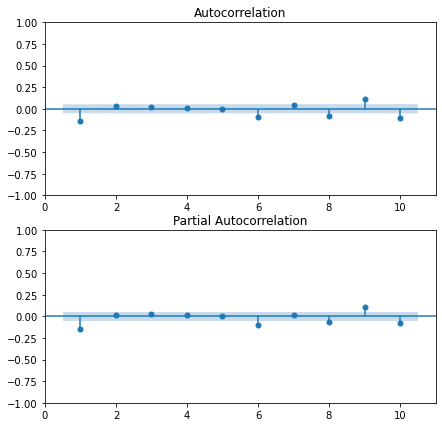

AR> 0 MA> 0 AIC> 7544.554319279609 BIC> 7549.830875682328
AR> 0 MA> 1 AIC> 7511.088779540679 BIC> 7521.641892346116
AR> 0 MA> 2 AIC> 7511.5031017587835 BIC> 7527.332770966939
AR> 0 MA> 3 AIC> 7513.382122483514 BIC> 7534.488348094388
AR> 1 MA> 0 AIC> 7509.711201479642 BIC> 7520.264314285079
AR> 1 MA> 1 AIC> 7511.674533592165 BIC> 7527.504202800321
AR> 1 MA> 2 AIC> 7513.397365595159 BIC> 7534.503591206033
AR> 1 MA> 3 AIC> 7509.9622645885665 BIC> 7536.34504660216
AR> 2 MA> 0 AIC> 7511.669522126307 BIC> 7527.499191334463
AR> 2 MA> 1 AIC> 7513.654062955068 BIC> 7534.760288565943


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 7514.966256863979 BIC> 7541.349038877573
AR> 2 MA> 3 AIC> 7517.388291392601 BIC> 7549.047629808913
AR> 3 MA> 0 AIC> 7513.493826808174 BIC> 7534.600052419049
AR> 3 MA> 1 AIC> 7515.453613011095 BIC> 7541.8363950246885


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 3 MA> 2 AIC> 7482.445930550701 BIC> 7514.105268967013
AR> 3 MA> 3 AIC> 7481.1058604828095 BIC> 7518.041755301841
3 3 7481.1058604828095 7518.041755301841
ADF TEST > (-8.575131769217634, 8.001138686632238e-14, 22, 1424, {'1%': -3.434950510599593, '5%': -2.8635718069244227, '10%': -2.5678517223401403}, 7424.604158261411)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [101]:
orderplot('2017-01-04')

### by checking acf pacf aic and bic values, order is (1,1,0)

In [102]:
all_dates.iloc[0]

Timestamp('2017-05-17 00:00:00')

### second model '2017-05-17'

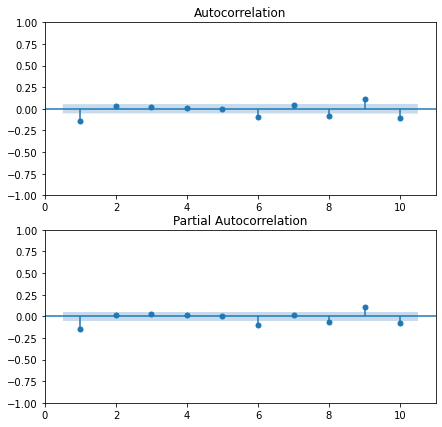

AR> 0 MA> 0 AIC> 7138.934771374159 BIC> 7144.143371712119
AR> 0 MA> 1 AIC> 7107.768249602186 BIC> 7118.185450278106
AR> 0 MA> 2 AIC> 7108.284704172119 BIC> 7123.910505186
AR> 0 MA> 3 AIC> 7110.167550986636 BIC> 7131.001952338477
AR> 1 MA> 0 AIC> 7106.48107565818 BIC> 7116.8982763341
AR> 1 MA> 1 AIC> 7108.447556857152 BIC> 7124.073357871033
AR> 1 MA> 2 AIC> 7110.183540497019 BIC> 7131.01794184886
AR> 1 MA> 3 AIC> 7107.102884358561 BIC> 7133.145886048362
AR> 2 MA> 0 AIC> 7108.4429097493885 BIC> 7124.068710763269
AR> 2 MA> 1 AIC> 7110.428365658043 BIC> 7131.262767009884


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 7111.7882269792935 BIC> 7137.831228669094
AR> 2 MA> 3 AIC> 7114.1739055975 BIC> 7145.425507625261
AR> 3 MA> 0 AIC> 7110.2739444681465 BIC> 7131.108345819987
AR> 3 MA> 1 AIC> 7112.236083764386 BIC> 7138.279085454187


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 3 MA> 2 AIC> 7082.0484494117045 BIC> 7113.300051439465
AR> 3 MA> 3 AIC> 7080.871502721904 BIC> 7117.331705087626
3 3 7080.871502721904 7117.331705087626
ADF TEST > (-8.28350238091753, 4.4540910906101196e-13, 22, 1329, {'1%': -3.4352800041551514, '5%': -2.863717207316508, '10%': -2.567929152459942}, 7021.035379204355)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [103]:
orderplot('2017-05-17')

### order is (1,1,0)

In [104]:
all_dates.iloc[1]

Timestamp('2017-10-27 00:00:00')

### 3rd model 2017-10-27

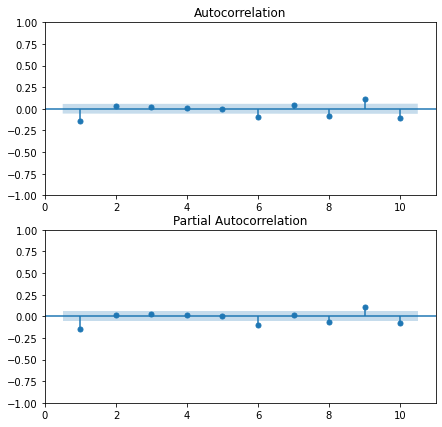

AR> 0 MA> 0 AIC> 6627.222497719473 BIC> 6632.3405139239385
AR> 0 MA> 1 AIC> 6598.661564671254 BIC> 6608.897597080185
AR> 0 MA> 2 AIC> 6599.287604041315 BIC> 6614.641652654711
AR> 0 MA> 3 AIC> 6601.184772211642 BIC> 6621.656837029503
AR> 1 MA> 0 AIC> 6597.46759932838 BIC> 6607.70363173731
AR> 1 MA> 1 AIC> 6599.436597666163 BIC> 6614.790646279559
AR> 1 MA> 2 AIC> 6601.199846096275 BIC> 6621.671910914136
AR> 1 MA> 3 AIC> 6598.536111923023 BIC> 6624.126192945349
AR> 2 MA> 0 AIC> 6599.43233507454 BIC> 6614.786383687936
AR> 2 MA> 1 AIC> 6601.418999087975 BIC> 6621.891063905836


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 6602.793983288771 BIC> 6628.384064311098
AR> 2 MA> 3 AIC> 6605.191765785805 BIC> 6635.899863012597
AR> 3 MA> 0 AIC> 6601.2793680126115 BIC> 6621.751432830472
AR> 3 MA> 1 AIC> 6603.247328762004 BIC> 6628.837409784331


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 3 MA> 2 AIC> 6578.379616164173 BIC> 6609.087713390965
AR> 3 MA> 3 AIC> 6575.31956245077 BIC> 6611.145675882027
3 3 6575.31956245077 6611.145675882027
ADF TEST > (-7.903155025864908, 4.133253946747731e-12, 22, 1212, {'1%': -3.4357569339190457, '5%': -2.863927640806119, '10%': -2.5680412191887507}, 6516.871776752898)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [105]:
orderplot('2017-10-27')

In [106]:
all_dates.iloc[3]

Timestamp('2017-12-15 00:00:00')

# 4th model 2017-12-15

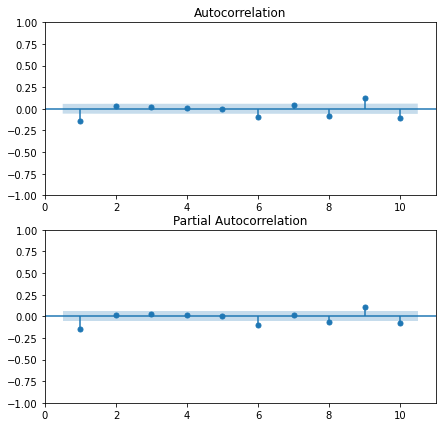

AR> 0 MA> 0 AIC> 6471.411377101859 BIC> 6476.500620256887
AR> 0 MA> 1 AIC> 6443.763522750691 BIC> 6453.9420090607455
AR> 0 MA> 2 AIC> 6444.401148142032 BIC> 6459.668877607115
AR> 0 MA> 3 AIC> 6446.3101663529305 BIC> 6466.667138973041
AR> 1 MA> 0 AIC> 6442.579239475873 BIC> 6452.7577257859275
AR> 1 MA> 1 AIC> 6444.54282874656 BIC> 6459.810558211643
AR> 1 MA> 2 AIC> 6446.320011303881 BIC> 6466.676983923991
AR> 1 MA> 3 AIC> 6443.828277898901 BIC> 6469.274493674039
AR> 2 MA> 0 AIC> 6444.538010236587 BIC> 6459.80573970167
AR> 2 MA> 1 AIC> 6446.524426254055 BIC> 6466.881398874165


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 6447.91375289235 BIC> 6473.359968667488
AR> 2 MA> 3 AIC> 6450.314734474668 BIC> 6480.850193404833
AR> 3 MA> 0 AIC> 6446.399877626119 BIC> 6466.756850246229
AR> 3 MA> 1 AIC> 6448.382052858326 BIC> 6473.828268633463


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 3 MA> 2 AIC> 6434.863483592613 BIC> 6465.398942522778
AR> 3 MA> 3 AIC> 6421.077834746446 BIC> 6456.702536831638
3 3 6421.077834746446 6456.702536831638
ADF TEST > (-7.664673028594805, 1.6532675370660708e-11, 21, 1178, {'1%': -3.435913333460925, '5%': -2.863996640985854, '10%': -2.5680779665111078}, 6361.4019642635)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [107]:
orderplot('2017-12-15')

In [108]:
all_dates.iloc[4]

Timestamp('2018-02-05 00:00:00')

# 5th model 2018-02-05

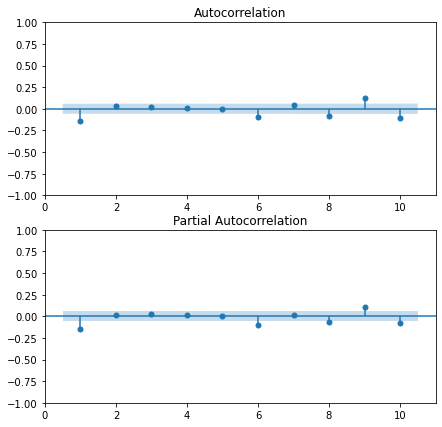

AR> 0 MA> 0 AIC> 6309.401049772843 BIC> 6314.459807925362
AR> 0 MA> 1 AIC> 6282.591939467646 BIC> 6292.709455772683
AR> 0 MA> 2 AIC> 6283.251277397739 BIC> 6298.427551855295
AR> 0 MA> 3 AIC> 6285.197545734796 BIC> 6305.432578344871
AR> 1 MA> 0 AIC> 6281.414284695575 BIC> 6291.531801000612
AR> 1 MA> 1 AIC> 6283.370011954782 BIC> 6298.546286412338
AR> 1 MA> 2 AIC> 6285.199360002749 BIC> 6305.434392612824
AR> 1 MA> 3 AIC> 6282.883152780005 BIC> 6308.176943542599
AR> 2 MA> 0 AIC> 6283.3647975004515 BIC> 6298.541071958008
AR> 2 MA> 1 AIC> 6285.313423071699 BIC> 6305.548455681774


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 6286.760176964488 BIC> 6312.053967727082
AR> 2 MA> 3 AIC> 6289.198524448918 BIC> 6319.551073364029
AR> 3 MA> 0 AIC> 6285.2587313462145 BIC> 6305.4937639562895
AR> 3 MA> 1 AIC> 6287.236816871131 BIC> 6312.530607633725


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 3 MA> 2 AIC> 6283.02094981524 BIC> 6313.3734987303515
AR> 3 MA> 3 AIC> 6263.907746715267 BIC> 6299.319053782898
3 3 6263.907746715267 6299.319053782898
ADF TEST > (-9.704083244892248, 1.0532240219372303e-16, 14, 1149, {'1%': -3.4360540638753405, '5%': -2.864058725215095, '10%': -2.568111031100567}, 6196.36664447338)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [109]:
orderplot('2018-02-05')

In [110]:
all_dates.iloc[5]

Timestamp('2018-02-06 00:00:00')

# 6th modoel 2018-02-06

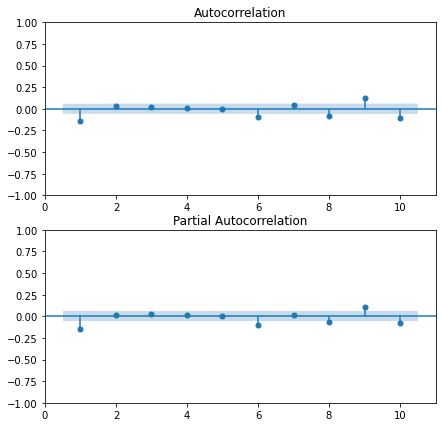

AR> 0 MA> 0 AIC> 6304.142016590758 BIC> 6309.199914528171
AR> 0 MA> 1 AIC> 6277.511279769695 BIC> 6287.627075644518
AR> 0 MA> 2 AIC> 6278.121551876266 BIC> 6293.295245688501
AR> 0 MA> 3 AIC> 6280.0799148243705 BIC> 6300.311506574018
AR> 1 MA> 0 AIC> 6276.294422097385 BIC> 6286.410217972209
AR> 1 MA> 1 AIC> 6278.2353091924515 BIC> 6293.409003004687
AR> 1 MA> 2 AIC> 6280.079336445947 BIC> 6300.310928195594
AR> 1 MA> 3 AIC> 6277.8174667197145 BIC> 6303.106956406774
AR> 2 MA> 0 AIC> 6278.228686100048 BIC> 6293.402379912284
AR> 2 MA> 1 AIC> 6280.21502337546 BIC> 6300.446615125107


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 6281.599742604443 BIC> 6306.889232291503
AR> 2 MA> 3 AIC> 6284.079291878519 BIC> 6314.426679502991
AR> 3 MA> 0 AIC> 6280.133469161872 BIC> 6300.365060911519
AR> 3 MA> 1 AIC> 6282.113947768085 BIC> 6307.403437455145


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 3 MA> 2 AIC> 6277.862661119577 BIC> 6308.2100487440475
AR> 3 MA> 3 AIC> 6256.224305936883 BIC> 6291.629591498766
3 3 6256.224305936883 6291.629591498766
ADF TEST > (-9.70047513772305, 1.0755804267258027e-16, 14, 1148, {'1%': -3.4360590437486405, '5%': -2.864060922068716, '10%': -2.5681122011011426}, 6191.6766104853195)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [111]:
orderplot('2018-02-06')

In [112]:
all_dates.iloc[6]

Timestamp('2018-02-08 00:00:00')

# 7th model 2018-02-08

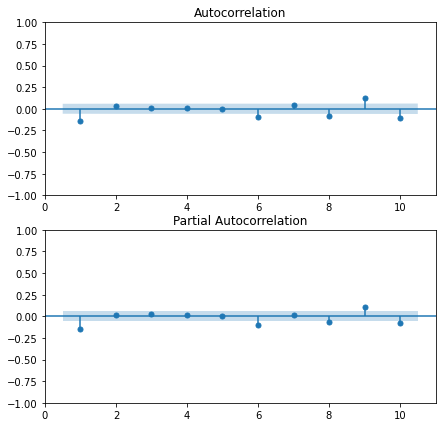

AR> 0 MA> 0 AIC> 6293.477697034745 BIC> 6298.533872318845
AR> 0 MA> 1 AIC> 6266.996733681754 BIC> 6277.109084249955
AR> 0 MA> 2 AIC> 6267.5399802388 BIC> 6282.708506091101
AR> 0 MA> 3 AIC> 6269.492234736141 BIC> 6289.716935872542
AR> 1 MA> 0 AIC> 6265.737360266944 BIC> 6275.849710835145
AR> 1 MA> 1 AIC> 6267.665463625248 BIC> 6282.833989477549
AR> 1 MA> 2 AIC> 6269.490687529991 BIC> 6289.715388666393
AR> 1 MA> 3 AIC> 6267.230909000615 BIC> 6292.511785421117
AR> 2 MA> 0 AIC> 6267.65694948731 BIC> 6282.825475339611
AR> 2 MA> 1 AIC> 6269.641109667163 BIC> 6289.865810803564


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 6271.077632646216 BIC> 6296.358509066718
AR> 2 MA> 3 AIC> 6273.490660711245 BIC> 6303.827712415848
AR> 3 MA> 0 AIC> 6269.551541385718 BIC> 6289.77624252212
AR> 3 MA> 1 AIC> 6271.538690496334 BIC> 6296.819566916836


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 3 MA> 2 AIC> 6267.352084253082 BIC> 6297.689135957684
AR> 3 MA> 3 AIC> 6245.838846800458 BIC> 6281.2320737891605
3 3 6245.838846800458 6281.2320737891605
ADF TEST > (-7.645643315977278, 1.845818603476539e-11, 22, 1138, {'1%': -3.4361093249345402, '5%': -2.8640831032339706, '10%': -2.5681240143809787}, 6182.257944030198)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [113]:
orderplot('2018-02-08')

In [114]:
all_dates.iloc[7]

Timestamp('2018-02-09 00:00:00')

# 8th model 2018-02-09

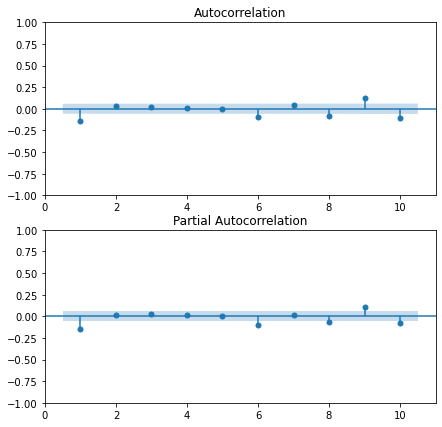

AR> 0 MA> 0 AIC> 6288.296951014434 BIC> 6293.352263857773
AR> 0 MA> 1 AIC> 6261.738499496196 BIC> 6271.8491251828755
AR> 0 MA> 2 AIC> 6262.297862247335 BIC> 6277.463800777354
AR> 0 MA> 3 AIC> 6264.255163947442 BIC> 6284.476415320802
AR> 1 MA> 0 AIC> 6260.486650758657 BIC> 6270.597276445336
AR> 1 MA> 1 AIC> 6262.417784532222 BIC> 6277.583723062241
AR> 1 MA> 2 AIC> 6264.253681299664 BIC> 6284.474932673023
AR> 1 MA> 3 AIC> 6261.993178844894 BIC> 6287.269743061593
AR> 2 MA> 0 AIC> 6262.409861751285 BIC> 6277.575800281304
AR> 2 MA> 1 AIC> 6264.394789607853 BIC> 6284.616040981213


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 6265.811777982917 BIC> 6291.088342199616
AR> 2 MA> 3 AIC> 6268.253664976637 BIC> 6298.585542036675
AR> 3 MA> 0 AIC> 6264.309696863493 BIC> 6284.530948236852
AR> 3 MA> 1 AIC> 6266.297896257475 BIC> 6291.574460474174


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 3 MA> 2 AIC> 6239.588124139758 BIC> 6269.920001199796
AR> 3 MA> 3 AIC> 6240.246339267104 BIC> 6275.633529170483
3 3 6240.246339267104 6275.633529170483
ADF TEST > (-7.636840976754364, 1.9422711758055824e-11, 22, 1137, {'1%': -3.436114401808766, '5%': -2.8640853428381092, '10%': -2.568125207156112}, 6177.805663470623)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [115]:
orderplot('2018-02-09')

In [116]:
all_dates.iloc[8]

Timestamp('2018-02-23 00:00:00')

# 9th model starts at 2018-02-23

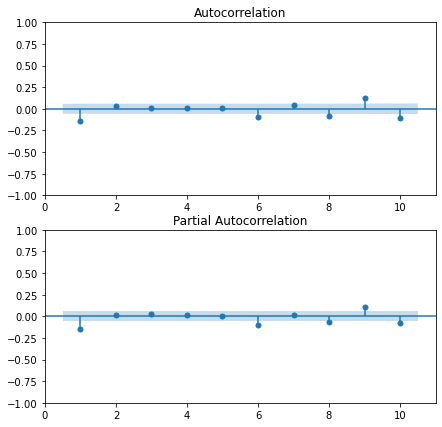

AR> 0 MA> 0 AIC> 6243.008506080751 BIC> 6248.0551533586
AR> 0 MA> 1 AIC> 6216.544083631233 BIC> 6226.637378186931
AR> 0 MA> 2 AIC> 6217.091460690683 BIC> 6232.2314025242285
AR> 0 MA> 3 AIC> 6219.048770190597 BIC> 6239.235359301992
AR> 1 MA> 0 AIC> 6215.283176275039 BIC> 6225.376470830737
AR> 1 MA> 1 AIC> 6217.212286810476 BIC> 6232.352228644022
AR> 1 MA> 2 AIC> 6219.046946406265 BIC> 6239.23353551766
AR> 1 MA> 3 AIC> 6216.838622333018 BIC> 6242.071858722262
AR> 2 MA> 0 AIC> 6217.204129712763 BIC> 6232.344071546308
AR> 2 MA> 1 AIC> 6219.188800413673 BIC> 6239.3753895250675


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 6220.605645638809 BIC> 6245.8388820280525
AR> 2 MA> 3 AIC> 6223.046948873331 BIC> 6253.326832540423
AR> 3 MA> 0 AIC> 6219.104096943138 BIC> 6239.290686054533
AR> 3 MA> 1 AIC> 6221.082974659965 BIC> 6246.3162110492085


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 3 MA> 2 AIC> 6198.320445758364 BIC> 6228.600329425457
AR> 3 MA> 3 AIC> 6195.011131424417 BIC> 6230.337662369358
3 3 6195.011131424417 6230.337662369358
ADF TEST > (-7.478868388779912, 4.831640107337682e-11, 21, 1128, {'1%': -3.4361604996756685, '5%': -2.864105678204421, '10%': -2.568136037454102}, 6127.626329944775)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [117]:
orderplot('2018-02-23')

In [118]:
all_dates.iloc[10]

Timestamp('2018-03-23 00:00:00')

# 10th model starts at 2018-03-23

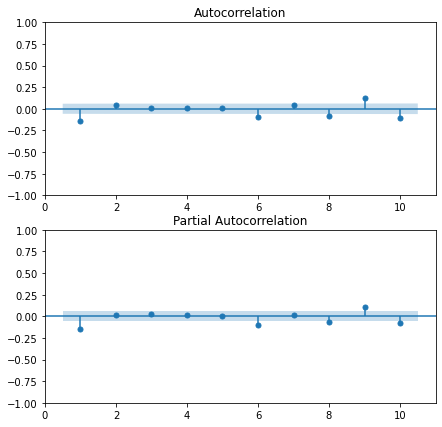

AR> 0 MA> 0 AIC> 6151.729441448323 BIC> 6156.7585290124725
AR> 0 MA> 1 AIC> 6125.800677752273 BIC> 6135.858852880572
AR> 0 MA> 2 AIC> 6126.303570035326 BIC> 6141.390832727775
AR> 0 MA> 3 AIC> 6128.270312990688 BIC> 6148.386663247286
AR> 1 MA> 0 AIC> 6124.509372825152 BIC> 6134.567547953451
AR> 1 MA> 1 AIC> 6126.421515381349 BIC> 6141.508778073799
AR> 1 MA> 2 AIC> 6128.267502463324 BIC> 6148.383852719922
AR> 1 MA> 3 AIC> 6126.062719350714 BIC> 6151.2081571714625
AR> 2 MA> 0 AIC> 6126.411559586535 BIC> 6141.498822278984
AR> 2 MA> 1 AIC> 6127.729396017556 BIC> 6147.845746274154
AR> 2 MA> 2 AIC> 6129.849245052201 BIC> 6154.994682872949
AR> 2 MA> 3 AIC> 6132.267158559034 BIC> 6162.441683943932


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 3 MA> 0 AIC> 6128.317323851343 BIC> 6148.433674107941
AR> 3 MA> 1 AIC> 6130.299367041431 BIC> 6155.444804862179
AR> 3 MA> 2 AIC> 6126.383732491924 BIC> 6156.558257876822
AR> 3 MA> 3 AIC> 6105.17548675201 BIC> 6140.379099701058
3 3 6105.17548675201 6140.379099701058
ADF TEST > (-9.559888186442572, 2.4419395381290604e-16, 14, 1115, {'1%': -3.4362284023329313, '5%': -2.864135631852894, '10%': -2.568151990387902}, 6035.547341198527)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [119]:
orderplot('2018-03-23')

# 11th model starts at 2018-03-26

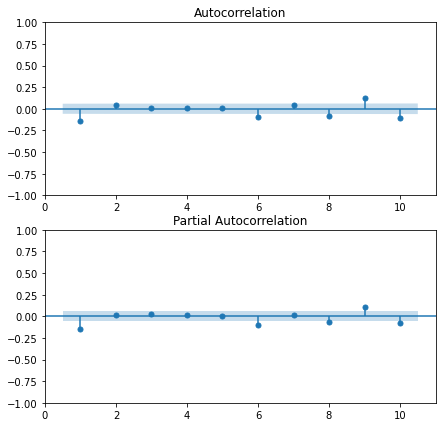

AR> 0 MA> 0 AIC> 6144.07443789566 BIC> 6149.102639327718
AR> 0 MA> 1 AIC> 6118.707916633857 BIC> 6128.764319497973
AR> 0 MA> 2 AIC> 6119.245570161563 BIC> 6134.330174457737
AR> 0 MA> 3 AIC> 6121.218549604086 BIC> 6141.331355332318
AR> 1 MA> 0 AIC> 6117.445289715974 BIC> 6127.501692580089
AR> 1 MA> 1 AIC> 6119.350746190009 BIC> 6134.435350486183
AR> 1 MA> 2 AIC> 6121.214327946742 BIC> 6141.327133674974
AR> 1 MA> 3 AIC> 6119.04838666378 BIC> 6144.18939382407
AR> 2 MA> 0 AIC> 6119.34083870889 BIC> 6134.425443005064
AR> 2 MA> 1 AIC> 6121.037889132596 BIC> 6141.1506948608285
AR> 2 MA> 2 AIC> 6122.74737874655 BIC> 6147.88838590684


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 3 AIC> 6125.212434370364 BIC> 6155.381642962711
AR> 3 MA> 0 AIC> 6121.261419071806 BIC> 6141.374224800038
AR> 3 MA> 1 AIC> 6123.242634782653 BIC> 6148.3836419429435
AR> 3 MA> 2 AIC> 6125.24780763357 BIC> 6155.417016225918
AR> 3 MA> 3 AIC> 6097.846828865969 BIC> 6133.044238890375
3 3 6097.846828865969 6133.044238890375
ADF TEST > (-9.554878328815024, 2.514471336776346e-16, 14, 1114, {'1%': -3.436233691409407, '5%': -2.8641379649753502, '10%': -2.5681532329838292}, 6035.547341198527)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [120]:
orderplot('2018-03-26')

# 12th model s. at 2018-03-27

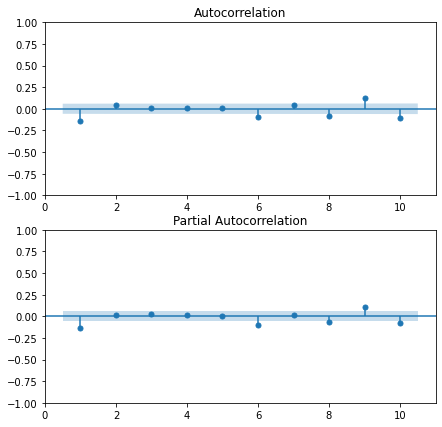

AR> 0 MA> 0 AIC> 6138.2594955650775 BIC> 6143.2868100791175
AR> 0 MA> 1 AIC> 6112.900334627047 BIC> 6122.954963655127
AR> 0 MA> 2 AIC> 6113.406130349753 BIC> 6128.488073891872
AR> 0 MA> 3 AIC> 6115.385527926562 BIC> 6135.494785982721
AR> 1 MA> 0 AIC> 6111.612345243919 BIC> 6121.666974271999
AR> 1 MA> 1 AIC> 6113.506465787631 BIC> 6128.58840932975
AR> 1 MA> 2 AIC> 6115.381853659743 BIC> 6135.491111715902
AR> 1 MA> 3 AIC> 6113.241335172551 BIC> 6138.37790774275
AR> 2 MA> 0 AIC> 6113.495734701504 BIC> 6128.577678243623
AR> 2 MA> 1 AIC> 6115.225180322867 BIC> 6135.334438379026
AR> 2 MA> 2 AIC> 6116.919737479613 BIC> 6142.056310049812
AR> 2 MA> 3 AIC> 6119.378267135747 BIC> 6149.542154219986


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 3 MA> 0 AIC> 6115.422108733222 BIC> 6135.531366789381
AR> 3 MA> 1 AIC> 6117.405336599252 BIC> 6142.541909169451


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 3 MA> 2 AIC> 6113.500504934997 BIC> 6143.6643920192355
AR> 3 MA> 3 AIC> 6091.718765470724 BIC> 6126.909967069003
3 3 6091.718765470724 6126.909967069003
ADF TEST > (-7.5246025238756165, 3.713270972110291e-11, 22, 1105, {'1%': -3.4362817248910282, '5%': -2.8641591533631945, '10%': -2.5681645177207675}, 6030.688685796129)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [121]:
orderplot('2018-03-27')

# 13th model start at 2018-04-04

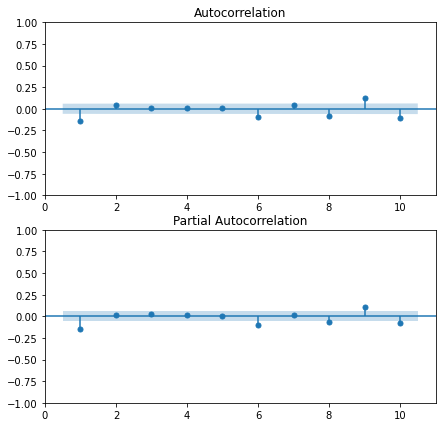

AR> 0 MA> 0 AIC> 6110.42950437733 BIC> 6115.451480800402
AR> 0 MA> 1 AIC> 6085.189493784361 BIC> 6095.233446630506
AR> 0 MA> 2 AIC> 6085.624794795883 BIC> 6100.690724065099
AR> 0 MA> 3 AIC> 6087.604990496371 BIC> 6107.69289618866
AR> 1 MA> 0 AIC> 6083.857619709808 BIC> 6093.901572555953
AR> 1 MA> 1 AIC> 6085.734470068617 BIC> 6100.800399337833
AR> 1 MA> 2 AIC> 6087.601422483735 BIC> 6107.689328176024
AR> 1 MA> 3 AIC> 6085.453139434033 BIC> 6110.563021549394
AR> 2 MA> 0 AIC> 6085.721169223024 BIC> 6100.78709849224
AR> 2 MA> 1 AIC> 6087.468913284416 BIC> 6107.556818976705
AR> 2 MA> 2 AIC> 6089.136046973195 BIC> 6114.245929088556


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 3 AIC> 6091.599496452183 BIC> 6121.731354990617
AR> 3 MA> 0 AIC> 6087.639325162785 BIC> 6107.727230855074
AR> 3 MA> 1 AIC> 6089.625442370234 BIC> 6114.735324485595
AR> 3 MA> 2 AIC> 6091.628851394082 BIC> 6121.760709932515
AR> 3 MA> 3 AIC> 6064.0816609146605 BIC> 6099.235495876165
3 3 6064.0816609146605 6099.235495876165
ADF TEST > (-7.503234643541507, 4.199555345392534e-11, 22, 1099, {'1%': -3.4363141853066232, '5%': -2.864173472014944, '10%': -2.568172143730631}, 6002.976488611665)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [122]:
orderplot('2018-04-04')

# 14th model starts at 2018-07-25

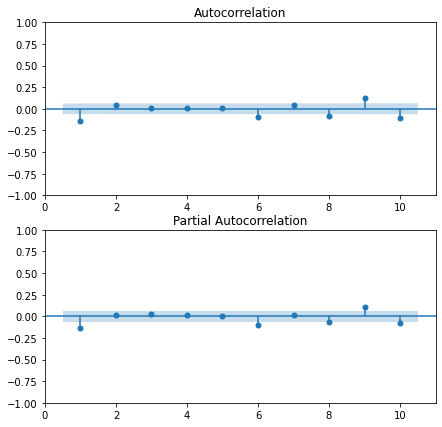

AR> 0 MA> 0 AIC> 5744.402513053794 BIC> 5749.350450122409
AR> 0 MA> 1 AIC> 5721.106281076133 BIC> 5731.002155213363
AR> 0 MA> 2 AIC> 5721.66234479939 BIC> 5736.5061560052345
AR> 0 MA> 3 AIC> 5723.6379213788005 BIC> 5743.42966965326
AR> 1 MA> 0 AIC> 5719.878892202836 BIC> 5729.774766340066
AR> 1 MA> 1 AIC> 5721.770344129386 BIC> 5736.614155335231
AR> 1 MA> 2 AIC> 5723.6360141116 BIC> 5743.42776238606
AR> 1 MA> 3 AIC> 5721.599299596524 BIC> 5746.338984939599
AR> 2 MA> 0 AIC> 5721.758105630477 BIC> 5736.601916836322
AR> 2 MA> 1 AIC> 5723.492543814507 BIC> 5743.284292088967
AR> 2 MA> 2 AIC> 5725.189383600447 BIC> 5749.929068943522


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 3 AIC> 5727.632352414729 BIC> 5757.319974826419
AR> 3 MA> 0 AIC> 5723.675131987869 BIC> 5743.466880262328
AR> 3 MA> 1 AIC> 5725.659556092403 BIC> 5750.399241435478
AR> 3 MA> 2 AIC> 5727.663735218121 BIC> 5757.35135762981
AR> 3 MA> 3 AIC> 5701.718089420674 BIC> 5736.353648900978
3 3 5701.718089420674 5736.353648900978
ADF TEST > (-10.83821282471607, 1.6412561245502326e-19, 9, 1032, {'1%': -3.4367023644255537, '5%': -2.864344690221488, '10%': -2.5682633351736674}, 5639.1055046628035)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [123]:
orderplot('2018-07-25')

# 15th model start at 2018-09-05

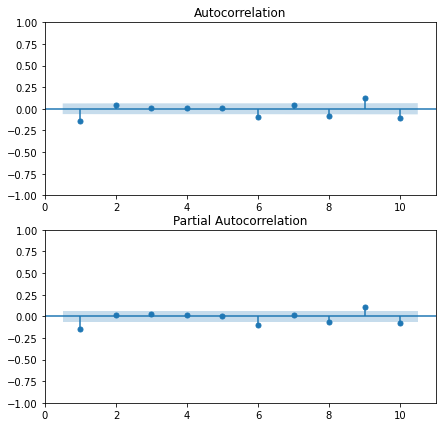

AR> 0 MA> 0 AIC> 5605.835699154184 BIC> 5610.754394373204
AR> 0 MA> 1 AIC> 5582.96140010188 BIC> 5592.79879053992
AR> 0 MA> 2 AIC> 5583.5857571007255 BIC> 5598.341842757787
AR> 0 MA> 3 AIC> 5585.557147154956 BIC> 5605.231928031038
AR> 1 MA> 0 AIC> 5581.782358851011 BIC> 5591.6197492890515
AR> 1 MA> 1 AIC> 5583.6915729324755 BIC> 5598.447658589537
AR> 1 MA> 2 AIC> 5585.551683233347 BIC> 5605.226464109429
AR> 1 MA> 3 AIC> 5583.605929374135 BIC> 5608.199405469237
AR> 2 MA> 0 AIC> 5583.681331130516 BIC> 5598.437416787578
AR> 2 MA> 1 AIC> 5585.4303349261845 BIC> 5605.1051158022665
AR> 2 MA> 2 AIC> 5587.167354992538 BIC> 5611.76083108764


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 3 AIC> 5589.550594374925 BIC> 5619.062765689047
AR> 3 MA> 0 AIC> 5585.598229579849 BIC> 5605.273010455931
AR> 3 MA> 1 AIC> 5587.579319406925 BIC> 5612.172795502027
AR> 3 MA> 2 AIC> 5589.584823295181 BIC> 5619.096994609304
AR> 3 MA> 3 AIC> 5564.5314615029565 BIC> 5598.9623280361
3 3 5564.5314615029565 5598.9623280361
ADF TEST > (-10.659832443551538, 4.43650500292214e-19, 9, 1002, {'1%': -3.436893045520188, '5%': -2.8644287878535146, '10%': -2.568308127138936}, 5500.581104863855)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [124]:
orderplot('2018-09-05')

# 15th model's order is 1,1,0

# 16th model starts at 2018-10-10

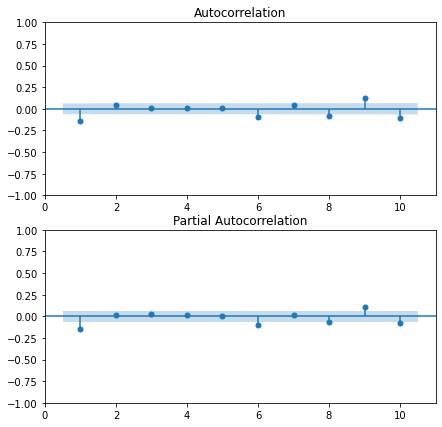

AR> 0 MA> 0 AIC> 5487.686754866891 BIC> 5492.580411221494
AR> 0 MA> 1 AIC> 5465.4144318168 BIC> 5475.201744526005
AR> 0 MA> 2 AIC> 5466.047225364608 BIC> 5480.728194428416
AR> 0 MA> 3 AIC> 5468.025313441893 BIC> 5487.599938860303
AR> 1 MA> 0 AIC> 5464.241130612067 BIC> 5474.028443321272
AR> 1 MA> 1 AIC> 5466.141026857828 BIC> 5480.821995921637
AR> 1 MA> 2 AIC> 5468.018571256067 BIC> 5487.593196674477
AR> 1 MA> 3 AIC> 5466.191861826595 BIC> 5490.660143599609
AR> 2 MA> 0 AIC> 5466.1307687631925 BIC> 5480.811737827001
AR> 2 MA> 1 AIC> 5467.897156956266 BIC> 5487.471782374677


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 5470.018082931716 BIC> 5494.48636470473
AR> 2 MA> 3 AIC> 5472.015093399669 BIC> 5501.377031527285
AR> 3 MA> 0 AIC> 5468.063193630819 BIC> 5487.63781904923
AR> 3 MA> 1 AIC> 5470.042935953281 BIC> 5494.5112177262945
AR> 3 MA> 2 AIC> 5472.049082659047 BIC> 5501.411020786662
AR> 3 MA> 3 AIC> 5447.43295188057 BIC> 5481.688546362789
3 3 5447.43295188057 5481.688546362789
ADF TEST > (-10.534296339959983, 8.983962492130743e-19, 9, 977, {'1%': -3.43706091543889, '5%': -2.8645028204932483, '10%': -2.568347558984588}, 5375.337030542595)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [125]:
orderplot('2018-10-10')

# 16th model's order is 1,1,0

# 17th model start at 2018-10-12

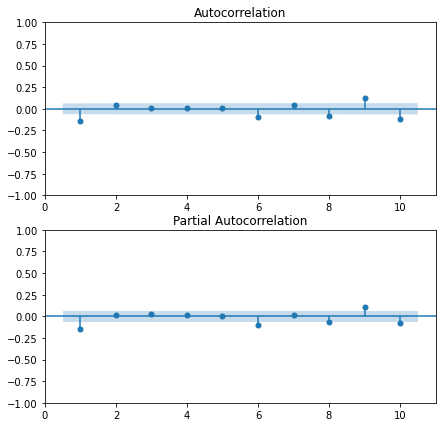

AR> 0 MA> 0 AIC> 5477.677457621008 BIC> 5482.56908351806
AR> 0 MA> 1 AIC> 5455.53782677426 BIC> 5465.321078568364
AR> 0 MA> 2 AIC> 5456.226406738768 BIC> 5470.901284429924
AR> 0 MA> 3 AIC> 5458.202195468131 BIC> 5477.768699056341
AR> 1 MA> 0 AIC> 5454.4048189090245 BIC> 5464.188070703129
AR> 1 MA> 1 AIC> 5456.316922846112 BIC> 5470.991800537268
AR> 1 MA> 2 AIC> 5458.194818753298 BIC> 5477.761322341507
AR> 1 MA> 3 AIC> 5456.417622174357 BIC> 5480.875751659619
AR> 2 MA> 0 AIC> 5456.308083951704 BIC> 5470.982961642861
AR> 2 MA> 1 AIC> 5458.063638591638 BIC> 5477.630142179847
AR> 2 MA> 2 AIC> 5460.316499380131 BIC> 5484.7746288653925
AR> 2 MA> 3 AIC> 5462.191730224615 BIC> 5491.541485606928


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 3 MA> 0 AIC> 5458.242707916948 BIC> 5477.809211505158
AR> 3 MA> 1 AIC> 5460.220706072955 BIC> 5484.678835558217
AR> 3 MA> 2 AIC> 5462.2275592336755 BIC> 5491.577314615989
AR> 3 MA> 3 AIC> 5437.48595666712 BIC> 5471.727337946486
3 3 5437.48595666712 5471.727337946486
ADF TEST > (-10.550597300738897, 8.195335107544895e-19, 9, 975, {'1%': -3.43707471791689, '5%': -2.8645089073679597, '10%': -2.5683508010519396}, 5365.444997660138)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [126]:
orderplot('2018-10-12')

# 17th model's order is 1,1,0

# 18th model start at 2018-10-16

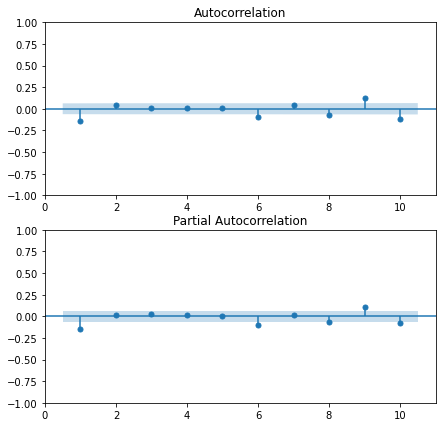

AR> 0 MA> 0 AIC> 5467.537296372073 BIC> 5472.426887680427
AR> 0 MA> 1 AIC> 5445.579614564982 BIC> 5455.3587971816905
AR> 0 MA> 2 AIC> 5446.248100361847 BIC> 5460.916874286911
AR> 0 MA> 3 AIC> 5448.227545382722 BIC> 5467.78591061614
AR> 1 MA> 0 AIC> 5444.433984502597 BIC> 5454.213167119306
AR> 1 MA> 1 AIC> 5446.3361790324025 BIC> 5461.004952957466
AR> 1 MA> 2 AIC> 5448.221269378172 BIC> 5467.77963461159
AR> 1 MA> 3 AIC> 5446.540621195266 BIC> 5470.988577737038
AR> 2 MA> 0 AIC> 5446.326502453034 BIC> 5460.9952763780975
AR> 2 MA> 1 AIC> 5448.432714447667 BIC> 5467.9910796810855
AR> 2 MA> 2 AIC> 5449.830738720011 BIC> 5474.2786952617835
AR> 2 MA> 3 AIC> 5452.2156763893145 BIC> 5481.553224239441


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 3 MA> 0 AIC> 5448.264028944577 BIC> 5467.822394177995
AR> 3 MA> 1 AIC> 5450.242937431522 BIC> 5474.690893973294
AR> 3 MA> 2 AIC> 5452.249386059874 BIC> 5481.586933910001
AR> 3 MA> 3 AIC> 5427.398730457244 BIC> 5461.625869615725
3 3 5427.398730457244 5461.625869615725
ADF TEST > (-10.554194972429254, 8.030910745930445e-19, 9, 973, {'1%': -3.4370885772879083, '5%': -2.8645150193044464, '10%': -2.5683540564723377}, 5355.785348318918)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [127]:
orderplot('2018-10-16')

# 18th model's order is 1,1,0

# 19th model starts at 2018-10-24

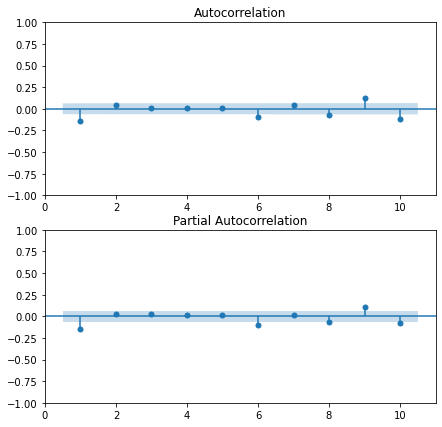

AR> 0 MA> 0 AIC> 5437.413022045228 BIC> 5442.296484631641
AR> 0 MA> 1 AIC> 5415.987354779848 BIC> 5425.754279952675
AR> 0 MA> 2 AIC> 5416.643734414267 BIC> 5431.294122173506
AR> 0 MA> 3 AIC> 5418.638607517443 BIC> 5438.172457863096
AR> 1 MA> 0 AIC> 5414.829775668651 BIC> 5424.596700841477
AR> 1 MA> 1 AIC> 5416.706728184441 BIC> 5431.357115943681
AR> 1 MA> 2 AIC> 5418.635271767001 BIC> 5438.169122112653
AR> 1 MA> 3 AIC> 5416.975460715284 BIC> 5441.392773647349
AR> 2 MA> 0 AIC> 5416.696482596924 BIC> 5431.346870356164
AR> 2 MA> 1 AIC> 5418.657395251166 BIC> 5438.191245596819
AR> 2 MA> 2 AIC> 5420.655269692394 BIC> 5445.072582624459


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 3 AIC> 5422.6245393655245 BIC> 5451.9253148840035
AR> 3 MA> 0 AIC> 5418.654916138641 BIC> 5438.188766484293
AR> 3 MA> 1 AIC> 5420.648482009223 BIC> 5445.065794941288
AR> 3 MA> 2 AIC> 5422.644944438865 BIC> 5451.945719957344
AR> 3 MA> 3 AIC> 5398.1941292279735 BIC> 5432.378367332865
3 3 5398.1941292279735 5432.378367332865
ADF TEST > (-10.499806438467193, 1.0914364426650807e-18, 9, 967, {'1%': -3.4371305002986277, '5%': -2.864533507042016, '10%': -2.5683639036818957}, 5326.1506012118225)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [128]:
orderplot('2018-10-24')

# 19th model's order is 1,1,0

# 20th model start at 2018-10-25

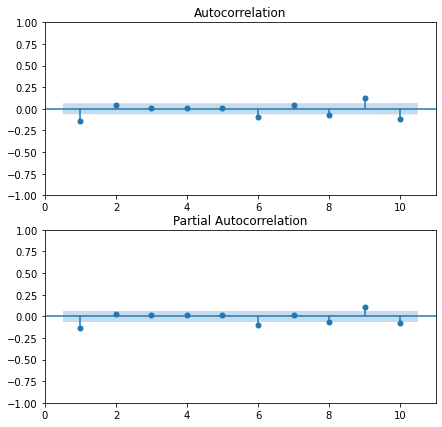

AR> 0 MA> 0 AIC> 5430.513555826686 BIC> 5435.395993297683
AR> 0 MA> 1 AIC> 5409.26593926299 BIC> 5419.030814204986
AR> 0 MA> 2 AIC> 5409.842869647946 BIC> 5424.490182060939
AR> 0 MA> 3 AIC> 5411.839647913059 BIC> 5431.369397797051
AR> 1 MA> 0 AIC> 5408.061690989989 BIC> 5417.826565931985
AR> 1 MA> 1 AIC> 5409.909899764424 BIC> 5424.557212177418
AR> 1 MA> 2 AIC> 5411.837854921201 BIC> 5431.367604805193
AR> 1 MA> 3 AIC> 5410.180267088001 BIC> 5434.59245444299
AR> 2 MA> 0 AIC> 5409.896421022095 BIC> 5424.543733435088
AR> 2 MA> 1 AIC> 5411.8560966376435 BIC> 5431.385846521635
AR> 2 MA> 2 AIC> 5413.51637453572 BIC> 5437.92856189071


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 3 AIC> 5415.827174334128 BIC> 5445.121799160115
AR> 3 MA> 0 AIC> 5411.851737571238 BIC> 5431.38148745523
AR> 3 MA> 1 AIC> 5413.846431855648 BIC> 5438.258619210637
AR> 3 MA> 2 AIC> 5415.843809528756 BIC> 5445.1384343547425
AR> 3 MA> 3 AIC> 5391.551099912214 BIC> 5425.7281622092
3 3 5391.551099912214 5425.7281622092
ADF TEST > (-8.862537280742181, 1.469633806638527e-14, 14, 961, {'1%': -3.4371729482129885, '5%': -2.8645522259969534, '10%': -2.568373874086242}, 5320.946830197442)


(None, None, None)

In [129]:
orderplot('2018-10-25')

# 20TH model's order is 1,1,0

# 21nd model starts at 2018-10-29

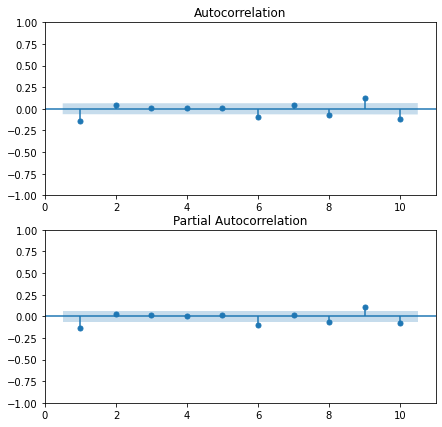

AR> 0 MA> 0 AIC> 5420.62929466527 BIC> 5425.509678747456
AR> 0 MA> 1 AIC> 5399.33530780786 BIC> 5409.096075972232
AR> 0 MA> 2 AIC> 5399.859124729573 BIC> 5414.50027697613
AR> 0 MA> 3 AIC> 5401.855543649717 BIC> 5421.377079978462
AR> 1 MA> 0 AIC> 5398.097047511059 BIC> 5407.857815675431
AR> 1 MA> 1 AIC> 5399.932117067301 BIC> 5414.573269313859
AR> 1 MA> 2 AIC> 5401.853350146014 BIC> 5421.374886474759
AR> 1 MA> 3 AIC> 5400.182141112747 BIC> 5424.584061523677
AR> 2 MA> 0 AIC> 5399.916788686605 BIC> 5414.557940933163
AR> 2 MA> 1 AIC> 5401.872737311562 BIC> 5421.394273640306


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 5403.870124165591 BIC> 5428.272044576521
AR> 2 MA> 3 AIC> 5405.842636821328 BIC> 5435.124941314443
AR> 3 MA> 0 AIC> 5401.868080186616 BIC> 5421.38961651536
AR> 3 MA> 1 AIC> 5403.862579470939 BIC> 5428.264499881869
AR> 3 MA> 2 AIC> 5405.859701367901 BIC> 5435.1420058610165
AR> 3 MA> 3 AIC> 5381.798088626141 BIC> 5415.960777201443
3 3 5381.798088626141 5415.960777201443
ADF TEST > (-8.851875918948378, 1.5649772822300676e-14, 14, 959, {'1%': -3.43718721587049, '5%': -2.8645585177815187, '10%': -2.568377225331392}, 5311.08046085076)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [130]:
orderplot('2018-10-29')

# 21nd of the model's order is 1,1,0

# 22rd model starts at 2018-10-31

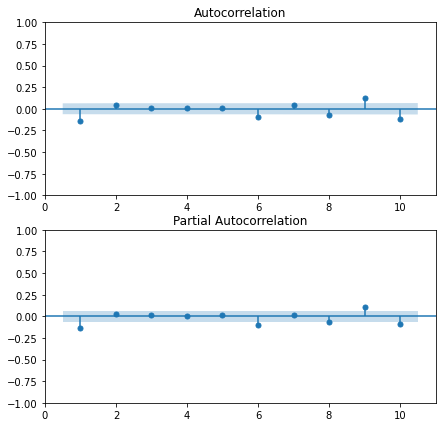

AR> 0 MA> 0 AIC> 5410.871386785186 BIC> 5415.749713253477
AR> 0 MA> 1 AIC> 5389.65378910222 BIC> 5399.410442038802
AR> 0 MA> 2 AIC> 5390.189202849083 BIC> 5404.824182253957
AR> 0 MA> 3 AIC> 5392.186684882865 BIC> 5411.69999075603
AR> 1 MA> 0 AIC> 5388.422196225456 BIC> 5398.178849162038
AR> 1 MA> 1 AIC> 5390.2572294065185 BIC> 5404.892208811392
AR> 1 MA> 2 AIC> 5392.18552246088 BIC> 5411.698828334045
AR> 1 MA> 3 AIC> 5390.561599951405 BIC> 5414.953232292862
AR> 2 MA> 0 AIC> 5390.242467534985 BIC> 5404.877446939859
AR> 2 MA> 1 AIC> 5392.2018255783905 BIC> 5411.715131451556
AR> 2 MA> 2 AIC> 5394.199151570856 BIC> 5418.590783912313


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 3 AIC> 5396.174298845086 BIC> 5425.444257654834
AR> 3 MA> 0 AIC> 5392.197647680478 BIC> 5411.710953553644
AR> 3 MA> 1 AIC> 5394.192552061784 BIC> 5418.584184403241
AR> 3 MA> 2 AIC> 5396.190221008654 BIC> 5425.460179818401
AR> 3 MA> 3 AIC> 5372.684767107759 BIC> 5406.8330523857985
3 3 5372.684767107759 5406.8330523857985
ADF TEST > (-8.856548984178628, 1.5224475260650803e-14, 14, 957, {'1%': -3.4372015433243797, '5%': -2.8645648359053517, '10%': -2.568380590610461}, 5301.900095731497)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [131]:
orderplot('2018-10-31')

# 22rd model's order is 1,1,0

# 23th model starts at 2018-11-07

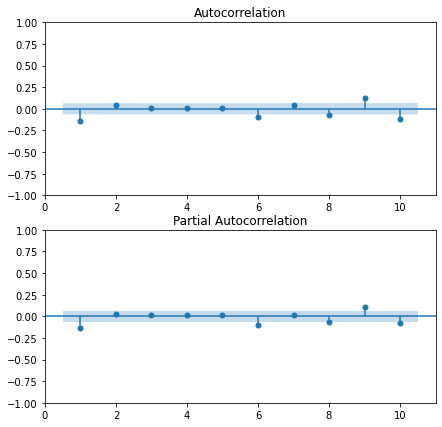

AR> 0 MA> 0 AIC> 5386.666205979396 BIC> 5391.539369813609
AR> 0 MA> 1 AIC> 5365.516867229911 BIC> 5375.263194898336
AR> 0 MA> 2 AIC> 5366.013141349526 BIC> 5380.632632852164
AR> 0 MA> 3 AIC> 5368.006262746823 BIC> 5387.498918083674
AR> 1 MA> 0 AIC> 5364.267573350393 BIC> 5374.013901018818
AR> 1 MA> 1 AIC> 5366.097888562345 BIC> 5380.7173800649825
AR> 1 MA> 2 AIC> 5368.002541836484 BIC> 5387.495197173334
AR> 1 MA> 3 AIC> 5366.360133039971 BIC> 5390.7259522110335
AR> 2 MA> 0 AIC> 5366.080912465525 BIC> 5380.700403968162
AR> 2 MA> 1 AIC> 5368.029758160728 BIC> 5387.522413497579


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 5370.00009766285 BIC> 5394.365916833913
AR> 2 MA> 3 AIC> 5371.992762679463 BIC> 5401.231745684739
AR> 3 MA> 0 AIC> 5368.023901329942 BIC> 5387.516556666793
AR> 3 MA> 1 AIC> 5370.017256602905 BIC> 5394.383075773968
AR> 3 MA> 2 AIC> 5372.013702664495 BIC> 5401.2526856697705
AR> 3 MA> 3 AIC> 5347.983492236119 BIC> 5382.095639075606
3 3 5347.983492236119 5382.095639075606
ADF TEST > (-8.815804746409837, 1.9358672105129525e-14, 14, 952, {'1%': -3.437237626048241, '5%': -2.8645807475403657, '10%': -2.56838906578808}, 5276.397959728089)


(None, None, None)

In [132]:
orderplot('2018-11-07')

# 24th model starts at 2018-11-19

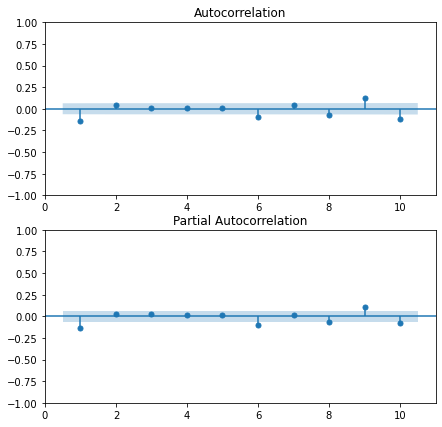

AR> 0 MA> 0 AIC> 5347.73593489468 BIC> 5352.600782672651
AR> 0 MA> 1 AIC> 5326.477027140658 BIC> 5336.206722696599
AR> 0 MA> 2 AIC> 5326.906634918432 BIC> 5341.501178252345
AR> 0 MA> 3 AIC> 5328.89956906999 BIC> 5348.358960181874
AR> 1 MA> 0 AIC> 5325.181369397387 BIC> 5334.911064953329
AR> 1 MA> 1 AIC> 5326.997603850534 BIC> 5341.592147184447
AR> 1 MA> 2 AIC> 5328.8963037306485 BIC> 5348.355694842532
AR> 1 MA> 3 AIC> 5327.258859354857 BIC> 5351.583098244711
AR> 2 MA> 0 AIC> 5326.978530117484 BIC> 5341.573073451397
AR> 2 MA> 1 AIC> 5328.923667477764 BIC> 5348.383058589648


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 5330.892928019255 BIC> 5355.217166909109
AR> 2 MA> 3 AIC> 5332.8853410643005 BIC> 5362.0744277321255
AR> 3 MA> 0 AIC> 5328.917408610429 BIC> 5348.376799722313
AR> 3 MA> 1 AIC> 5330.910570625549 BIC> 5355.234809515403
AR> 3 MA> 2 AIC> 5332.906816775747 BIC> 5362.095903443572
AR> 3 MA> 3 AIC> 5308.6407930460655 BIC> 5342.694727491861
3 3 5308.6407930460655 5342.694727491861
ADF TEST > (-10.374984903821883, 2.213583187650138e-18, 9, 949, {'1%': -3.43725945868569, '5%': -2.8645903751292536, '10%': -2.5683941938438886}, 5237.405741566191)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [133]:
orderplot('2018-11-19')

# 24th model's order is 1,1,0 

# 25th model starts at 2018-11-20

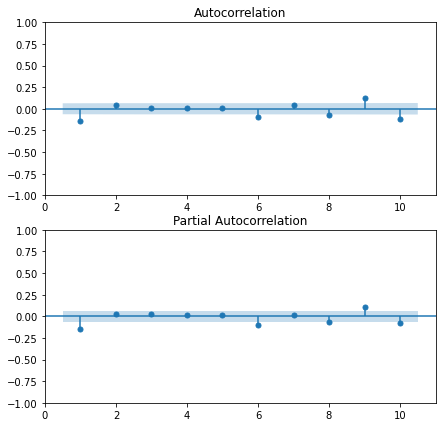

AR> 0 MA> 0 AIC> 5342.6101515707705 BIC> 5347.473954962224
AR> 0 MA> 1 AIC> 5321.440792384563 BIC> 5331.168399167469
AR> 0 MA> 2 AIC> 5321.873332743735 BIC> 5336.464742918094
AR> 0 MA> 3 AIC> 5323.865212684847 BIC> 5343.320426250659
AR> 1 MA> 0 AIC> 5320.149506181776 BIC> 5329.877112964682
AR> 1 MA> 1 AIC> 5321.965118818325 BIC> 5336.556528992684
AR> 1 MA> 2 AIC> 5323.860198370761 BIC> 5343.315411936573
AR> 1 MA> 3 AIC> 5322.269586894535 BIC> 5346.588603851799
AR> 2 MA> 0 AIC> 5321.945726825932 BIC> 5336.537137000291
AR> 2 MA> 1 AIC> 5323.8885610983525 BIC> 5343.343774664164


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 5325.857435545024 BIC> 5350.176452502288
AR> 2 MA> 3 AIC> 5327.848944610449 BIC> 5357.031764959166
AR> 3 MA> 0 AIC> 5323.884758434631 BIC> 5343.339972000443
AR> 3 MA> 1 AIC> 5325.8771427683905 BIC> 5350.196159725655
AR> 3 MA> 2 AIC> 5327.872353578039 BIC> 5357.055173926757
AR> 3 MA> 3 AIC> 5303.64157923872 BIC> 5337.68820297889
3 3 5303.64157923872 5337.68820297889
ADF TEST > (-10.370741332328754, 2.2676065258914658e-18, 9, 948, {'1%': -3.4372667670223835, '5%': -2.864593597887944, '10%': -2.568395910422119}, 5232.658410757088)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [134]:
orderplot('2018-11-20')

# 25th model's order is 1,1,0

# 26th model start at 2018-11-26

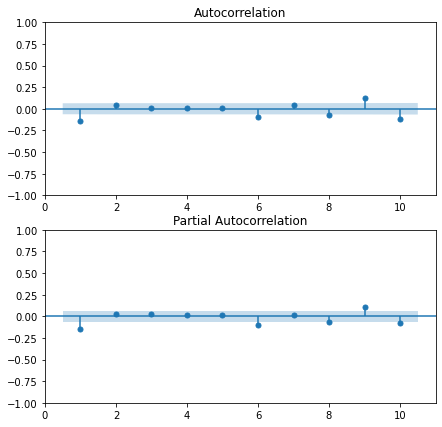

AR> 0 MA> 0 AIC> 5323.412033978297 BIC> 5328.271648881951
AR> 0 MA> 1 AIC> 5302.211866804786 BIC> 5311.931096612095
AR> 0 MA> 2 AIC> 5302.723133852563 BIC> 5317.301978563525
AR> 0 MA> 3 AIC> 5304.716210745044 BIC> 5324.1546703596605
AR> 1 MA> 0 AIC> 5300.965547239421 BIC> 5310.684777046729
AR> 1 MA> 1 AIC> 5302.805250650298 BIC> 5317.384095361261
AR> 1 MA> 2 AIC> 5304.71272459566 BIC> 5324.151184210276
AR> 1 MA> 3 AIC> 5303.145972331259 BIC> 5327.44404684953
AR> 2 MA> 0 AIC> 5302.789580107613 BIC> 5317.3684248185755
AR> 2 MA> 1 AIC> 5304.7391061946455 BIC> 5324.177565809262


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 5306.7095720658945 BIC> 5331.007646584166
AR> 2 MA> 3 AIC> 5308.701727441145 BIC> 5337.85941686307
AR> 3 MA> 0 AIC> 5304.734493293798 BIC> 5324.172952908414
AR> 3 MA> 1 AIC> 5306.7274827528445 BIC> 5331.025557271116
AR> 3 MA> 2 AIC> 5308.723510144537 BIC> 5337.881199566462
AR> 3 MA> 3 AIC> 5284.82865774303 BIC> 5318.845962068609
3 3 5284.82865774303 5318.845962068609
ADF TEST > (-10.323819190431571, 2.9613561875067103e-18, 9, 944, {'1%': -3.4372961556318304, '5%': -2.864606557310281, '10%': -2.568402813173298}, 5208.818422717222)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [135]:
orderplot('2018-11-26')

# 26th model's order is 1,1,0 

# 27th model starts at 2018-11-28

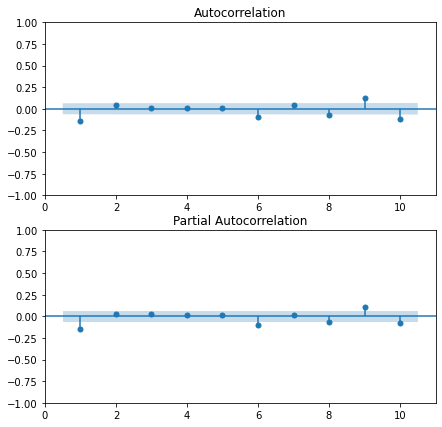

AR> 0 MA> 0 AIC> 5313.198308675923 BIC> 5318.055822738468
AR> 0 MA> 1 AIC> 5292.01033198429 BIC> 5301.725360109381
AR> 0 MA> 2 AIC> 5292.535826052574 BIC> 5307.1083682402095
AR> 0 MA> 3 AIC> 5294.529456409054 BIC> 5313.959512659235
AR> 1 MA> 0 AIC> 5290.769787781844 BIC> 5300.484815906934
AR> 1 MA> 1 AIC> 5292.611624183657 BIC> 5307.184166371293
AR> 1 MA> 2 AIC> 5294.525109360084 BIC> 5313.955165610265
AR> 1 MA> 3 AIC> 5292.984479585845 BIC> 5317.272049898572
AR> 2 MA> 0 AIC> 5292.597077175615 BIC> 5307.169619363251
AR> 2 MA> 1 AIC> 5294.54777908737 BIC> 5313.977835337551


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 5296.52125252895 BIC> 5320.808822841676
AR> 2 MA> 3 AIC> 5298.511864430175 BIC> 5327.656948805447
AR> 3 MA> 0 AIC> 5294.547597795398 BIC> 5313.97765404558
AR> 3 MA> 1 AIC> 5296.540026982286 BIC> 5320.827597295012
AR> 3 MA> 2 AIC> 5298.534914520443 BIC> 5327.6799988957155
AR> 3 MA> 3 AIC> 5274.310020295215 BIC> 5308.312618733033
3 3 5274.310020295215 5308.312618733033
ADF TEST > (-10.311233828025541, 3.1814444346441283e-18, 9, 942, {'1%': -3.43731094378832, '5%': -2.864613078359397, '10%': -2.5684062865746187}, 5199.430097832772)


(None, None, None)

In [136]:
orderplot('2018-11-28')

# 27th model's order is 1,1,0 

# 28th model start at 2018-12-04

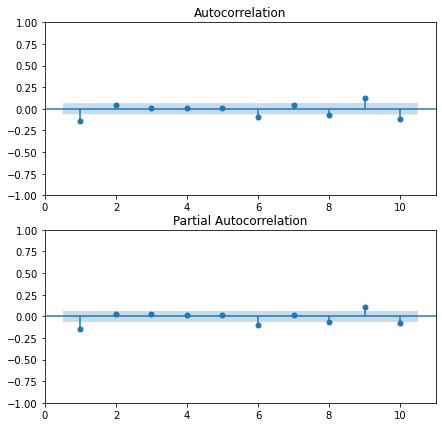

AR> 0 MA> 0 AIC> 5293.857699688809 BIC> 5298.710998781995
AR> 0 MA> 1 AIC> 5272.832653618752 BIC> 5282.539251805125
AR> 0 MA> 2 AIC> 5273.36786213971 BIC> 5287.927759419268
AR> 0 MA> 3 AIC> 5275.365716190028 BIC> 5294.778912562772
AR> 1 MA> 0 AIC> 5271.592073929814 BIC> 5281.298672116187
AR> 1 MA> 1 AIC> 5273.422885641576 BIC> 5287.982782921134
AR> 1 MA> 2 AIC> 5275.363107922758 BIC> 5294.776304295502
AR> 1 MA> 3 AIC> 5273.900263178181 BIC> 5298.166758644112
AR> 2 MA> 0 AIC> 5273.409718102189 BIC> 5287.969615381747
AR> 2 MA> 1 AIC> 5275.368641900979 BIC> 5294.781838273723


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 5277.376875134894 BIC> 5301.643370600825
AR> 2 MA> 3 AIC> 5279.342036235364 BIC> 5308.46183079448
AR> 3 MA> 0 AIC> 5275.375975063211 BIC> 5294.789171435955
AR> 3 MA> 1 AIC> 5277.368997734111 BIC> 5301.635493200041
AR> 3 MA> 2 AIC> 5279.362774370615 BIC> 5308.482568929731
AR> 3 MA> 3 AIC> 5255.3828921901895 BIC> 5289.355985842492
3 3 5255.3828921901895 5289.355985842492
ADF TEST > (-10.327636013096635, 2.8976904398216992e-18, 9, 938, {'1%': -3.4373407098114765, '5%': -2.8646262040163566, '10%': -2.568413277899264}, 5180.346418644904)


(None, None, None)

In [137]:
orderplot('2018-12-04')

# 28th model's order is 1,1,0

# 29th model start at 2018-12-07

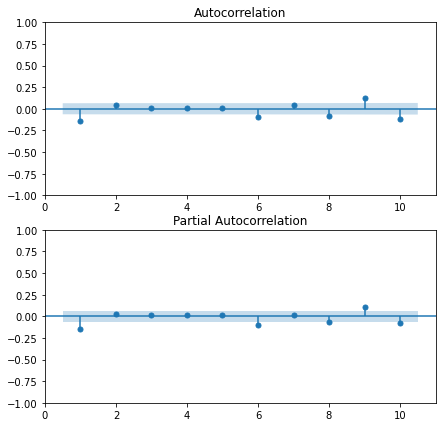

AR> 0 MA> 0 AIC> 5278.856988746351 BIC> 5283.707114912497
AR> 0 MA> 1 AIC> 5258.1187976939655 BIC> 5267.819050026256
AR> 0 MA> 2 AIC> 5258.630427289288 BIC> 5273.180805787724
AR> 0 MA> 3 AIC> 5260.628002326054 BIC> 5280.028506990636
AR> 1 MA> 0 AIC> 5256.871597230334 BIC> 5266.571849562625
AR> 1 MA> 1 AIC> 5258.688707011024 BIC> 5273.239085509461
AR> 1 MA> 2 AIC> 5260.6253276302095 BIC> 5280.025832294791
AR> 1 MA> 3 AIC> 5259.1938335114355 BIC> 5283.444464342163
AR> 2 MA> 0 AIC> 5258.674298875712 BIC> 5273.224677374149
AR> 2 MA> 1 AIC> 5260.63204927961 BIC> 5280.032553944192


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 5262.616847479702 BIC> 5286.86747831043
AR> 2 MA> 3 AIC> 5264.604743377515 BIC> 5293.705500374388
AR> 3 MA> 0 AIC> 5260.638964730458 BIC> 5280.039469395039
AR> 3 MA> 1 AIC> 5262.622827098101 BIC> 5286.873457928828
AR> 3 MA> 2 AIC> 5264.626134441922 BIC> 5293.726891438795
AR> 3 MA> 3 AIC> 5240.382980974485 BIC> 5274.333864137503
3 3 5240.382980974485 5274.333864137503
ADF TEST > (-10.305242013295492, 3.2919477523360236e-18, 9, 935, {'1%': -3.437363201927513, '5%': -2.864636122077874, '10%': -2.5684185607252137}, 5165.555969185047)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [138]:
orderplot('2018-12-07')

# 29 model 1,1,0


# 30 model 2018-12-10

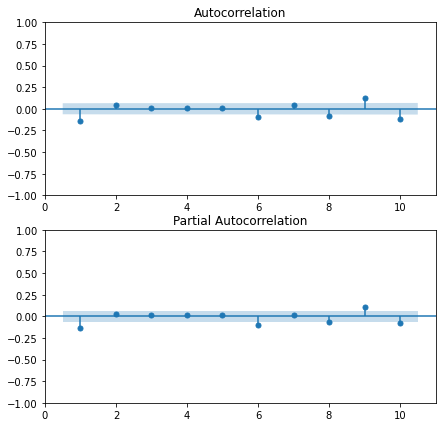

AR> 0 MA> 0 AIC> 5273.777435655029 BIC> 5278.626501937662
AR> 0 MA> 1 AIC> 5252.991496392988 BIC> 5262.689628958255
AR> 0 MA> 2 AIC> 5253.508751080866 BIC> 5268.0559499287665
AR> 0 MA> 3 AIC> 5255.505795075911 BIC> 5274.902060206445
AR> 1 MA> 0 AIC> 5251.745744368632 BIC> 5261.4438769338985
AR> 1 MA> 1 AIC> 5253.566067823239 BIC> 5268.113266671139
AR> 1 MA> 2 AIC> 5255.502148090862 BIC> 5274.8984132213955
AR> 1 MA> 3 AIC> 5254.10393739108 BIC> 5278.349268804247
AR> 2 MA> 0 AIC> 5253.5521149441865 BIC> 5268.099313792087
AR> 2 MA> 1 AIC> 5255.508318276661 BIC> 5274.904583407195


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 5257.493034683246 BIC> 5281.738366096413
AR> 2 MA> 3 AIC> 5259.47948359109 BIC> 5288.57388128689
AR> 3 MA> 0 AIC> 5255.517805497648 BIC> 5274.914070628181
AR> 3 MA> 1 AIC> 5257.510078117352 BIC> 5281.7554095305195
AR> 3 MA> 2 AIC> 5259.502907690168 BIC> 5288.597305385969
AR> 3 MA> 3 AIC> 5235.195208022005 BIC> 5269.138672000439
3 3 5235.195208022005 5269.138672000439
ADF TEST > (-10.32970049818017, 2.8638308619884457e-18, 9, 934, {'1%': -3.4373707314972766, '5%': -2.8646394422797337, '10%': -2.5684203292233905}, 5160.800766653257)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [139]:
orderplot('2018-12-10')

# 30 model 1,1,0

# 31nd model 2018-12-14

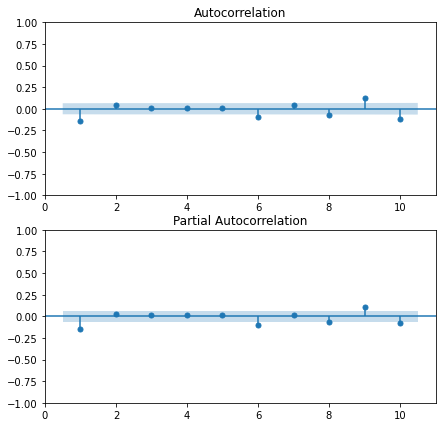

AR> 0 MA> 0 AIC> 5254.57675954874 BIC> 5259.421575027948
AR> 0 MA> 1 AIC> 5233.651339811924 BIC> 5243.34097077034
AR> 0 MA> 2 AIC> 5234.130632593162 BIC> 5248.665079030787
AR> 0 MA> 3 AIC> 5236.127041505853 BIC> 5255.506303422687
AR> 1 MA> 0 AIC> 5232.37893104851 BIC> 5242.068562006926
AR> 1 MA> 1 AIC> 5234.194974556709 BIC> 5248.729420994334
AR> 1 MA> 2 AIC> 5236.123844774352 BIC> 5255.503106691185
AR> 1 MA> 3 AIC> 5234.675552973347 BIC> 5258.899630369388
AR> 2 MA> 0 AIC> 5234.179926843468 BIC> 5248.714373281093
AR> 2 MA> 1 AIC> 5236.134501831788 BIC> 5255.513763748621


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 5238.116349689299 BIC> 5262.34042708534
AR> 2 MA> 3 AIC> 5240.10371485734 BIC> 5269.172607732589
AR> 3 MA> 0 AIC> 5236.1410862374605 BIC> 5255.520348154294
AR> 3 MA> 1 AIC> 5238.133327393159 BIC> 5262.3574047892
AR> 3 MA> 2 AIC> 5240.127488459272 BIC> 5269.196381334522
AR> 3 MA> 3 AIC> 5215.944084148155 BIC> 5249.857792502612
3 3 5215.944084148155 5249.857792502612
ADF TEST > (-10.23800813230347, 4.831766875655549e-18, 9, 930, {'1%': -3.4374010121538072, '5%': -2.864652794604883, '10%': -2.5684274413226964}, 5141.8245549522935)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [140]:
orderplot('2018-12-14')

# 31 model 1,1,0

# 32 starts at 2018-12-17

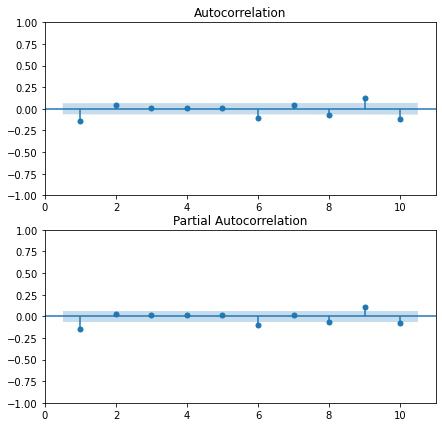

AR> 0 MA> 0 AIC> 5249.356305125054 BIC> 5254.20005507406
AR> 0 MA> 1 AIC> 5228.498774631784 BIC> 5238.186274529797
AR> 0 MA> 2 AIC> 5228.997125200243 BIC> 5243.528375047262
AR> 0 MA> 3 AIC> 5230.9956511927085 BIC> 5250.370650988733
AR> 1 MA> 0 AIC> 5227.236584755793 BIC> 5236.924084653806
AR> 1 MA> 1 AIC> 5229.052754913091 BIC> 5243.58400476011
AR> 1 MA> 2 AIC> 5230.994122725776 BIC> 5250.369122521801
AR> 1 MA> 3 AIC> 5229.599221837919 BIC> 5253.81797158295
AR> 2 MA> 0 AIC> 5229.038275708246 BIC> 5243.569525555265
AR> 2 MA> 1 AIC> 5230.999437054859 BIC> 5250.374436850884


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 5233.0052627774 BIC> 5257.224012522432
AR> 2 MA> 3 AIC> 5234.974349364405 BIC> 5264.036849058442
AR> 3 MA> 0 AIC> 5231.004816762777 BIC> 5250.379816558802
AR> 3 MA> 1 AIC> 5232.998352744817 BIC> 5257.217102489848
AR> 3 MA> 2 AIC> 5234.993948075886 BIC> 5264.056447769924
AR> 3 MA> 3 AIC> 5210.718363781254 BIC> 5244.624613424297
3 3 5210.718363781254 5244.624613424297
ADF TEST > (-10.237206691496977, 4.853950778062566e-18, 9, 929, {'1%': -3.4374086231752226, '5%': -2.864656150681263, '10%': -2.568429228935821}, 5137.150503640716)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [141]:
orderplot('2018-12-17')

# 32 order 1,1,0

# 33 2018-12-21

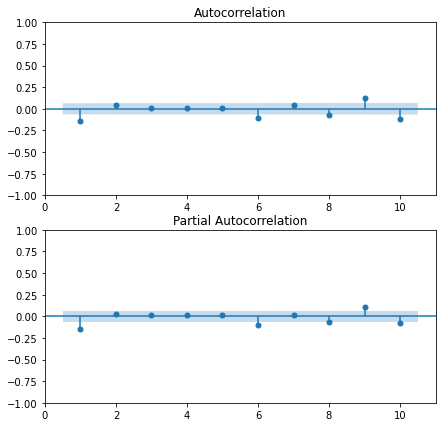

AR> 0 MA> 0 AIC> 5229.91051371749 BIC> 5234.749990155719
AR> 0 MA> 1 AIC> 5208.678599769579 BIC> 5218.357552646036
AR> 0 MA> 2 AIC> 5209.112869695773 BIC> 5223.63129901046
AR> 0 MA> 3 AIC> 5211.102742246545 BIC> 5230.46064799946
AR> 1 MA> 0 AIC> 5207.376613001004 BIC> 5217.055565877462
AR> 1 MA> 1 AIC> 5209.199486166473 BIC> 5223.71791548116
AR> 1 MA> 2 AIC> 5211.095879011425 BIC> 5230.45378476434
AR> 1 MA> 3 AIC> 5209.720226377518 BIC> 5233.917608568662
AR> 2 MA> 0 AIC> 5209.182758043389 BIC> 5223.701187358076
AR> 2 MA> 1 AIC> 5211.125725929505 BIC> 5230.48363168242
AR> 2 MA> 2 AIC> 5212.817481118484 BIC> 5237.014863309628
AR> 2 MA> 3 AIC> 5215.081339849913 BIC> 5244.118198479287


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 3 MA> 0 AIC> 5211.1287703963935 BIC> 5230.486676149309
AR> 3 MA> 1 AIC> 5213.1188501963625 BIC> 5237.316232387507
AR> 3 MA> 2 AIC> 5215.112613561001 BIC> 5244.149472190375
AR> 3 MA> 3 AIC> 5191.192216403188 BIC> 5225.068551470789
3 3 5191.192216403188 5225.068551470789
ADF TEST > (-10.227855971599126, 5.120487598314609e-18, 9, 925, {'1%': -3.437439232284603, '5%': -2.8646696476686477, '10%': -2.5684364181154127}, 5123.206059858396)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [142]:
orderplot('2018-12-21')

# 33 order 1,1,0

# 34th 2018-12-24

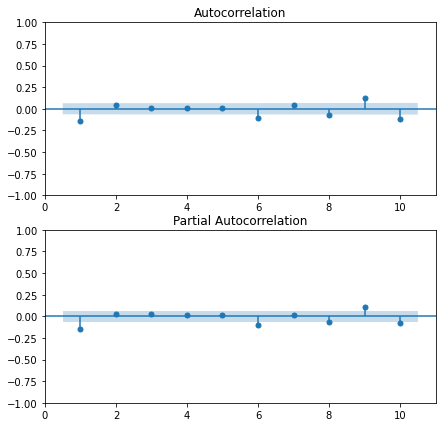

AR> 0 MA> 0 AIC> 5224.248661785761 BIC> 5229.087066986609
AR> 0 MA> 1 AIC> 5203.295228761586 BIC> 5212.972039163281
AR> 0 MA> 2 AIC> 5203.677847234843 BIC> 5218.193062837386
AR> 0 MA> 3 AIC> 5205.667550109556 BIC> 5225.021170912945
AR> 1 MA> 0 AIC> 5201.970930044465 BIC> 5211.647740446159
AR> 1 MA> 1 AIC> 5203.770940523496 BIC> 5218.286156126039
AR> 1 MA> 2 AIC> 5205.660604944499 BIC> 5225.014225747888
AR> 1 MA> 3 AIC> 5204.227169735326 BIC> 5228.419195739563
AR> 2 MA> 0 AIC> 5203.751010995957 BIC> 5218.266226598499
AR> 2 MA> 1 AIC> 5205.68976526024 BIC> 5225.043386063629
AR> 2 MA> 2 AIC> 5207.408797616783 BIC> 5231.60082362102
AR> 2 MA> 3 AIC> 5209.645578928115 BIC> 5238.676010133199


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 3 MA> 0 AIC> 5205.693026562167 BIC> 5225.046647365556
AR> 3 MA> 1 AIC> 5207.683055691867 BIC> 5231.875081696104
AR> 3 MA> 2 AIC> 5209.676588853856 BIC> 5238.70702005894
AR> 3 MA> 3 AIC> 5185.788139659954 BIC> 5219.656976065886
3 3 5185.788139659954 5219.656976065886
ADF TEST > (-10.215651409855152, 5.490682075570164e-18, 9, 924, {'1%': -3.437446926086526, '5%': -2.8646730402041443, '10%': -2.568438225155076}, 5118.212354473998)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [143]:
orderplot('2018-12-24')

# 34 order 1,1,0

# 35th 2018-12-25

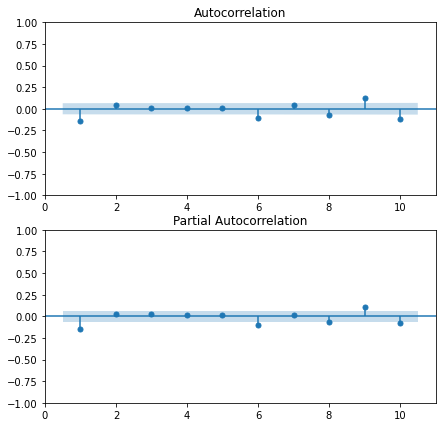

AR> 0 MA> 0 AIC> 5218.99673408815 BIC> 5223.834066902836
AR> 0 MA> 1 AIC> 5197.826257641021 BIC> 5207.5009232703915
AR> 0 MA> 2 AIC> 5198.206717600249 BIC> 5212.718716044306
AR> 0 MA> 3 AIC> 5200.195766441783 BIC> 5219.545097700526
AR> 1 MA> 0 AIC> 5196.494579239801 BIC> 5206.169244869172
AR> 1 MA> 1 AIC> 5198.302522075926 BIC> 5212.8145205199835
AR> 1 MA> 2 AIC> 5200.189151193489 BIC> 5219.538482452232
AR> 1 MA> 3 AIC> 5198.694316663269 BIC> 5222.880980736697
AR> 2 MA> 0 AIC> 5198.28308769674 BIC> 5212.795086140797
AR> 2 MA> 1 AIC> 5200.221313699085 BIC> 5219.570644957827
AR> 2 MA> 2 AIC> 5202.29445181636 BIC> 5226.481115889788
AR> 2 MA> 3 AIC> 5204.175434863885 BIC> 5233.199431751998


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 3 MA> 0 AIC> 5200.222273428083 BIC> 5219.571604686826
AR> 3 MA> 1 AIC> 5202.200988878782 BIC> 5226.3876529522095
AR> 3 MA> 2 AIC> 5204.206330032708 BIC> 5233.230326920821
AR> 3 MA> 3 AIC> 5180.389644090218 BIC> 5214.250973793018
3 3 5180.389644090218 5214.250973793018
ADF TEST > (-10.21032523628903, 5.660578008663127e-18, 9, 923, {'1%': -3.437454636606558, '5%': -2.8646764401027336, '10%': -2.5684400361180333}, 5113.565509825893)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [144]:
orderplot('2018-12-25')

# 35 order 1,1,0

# 36 2018-12-26

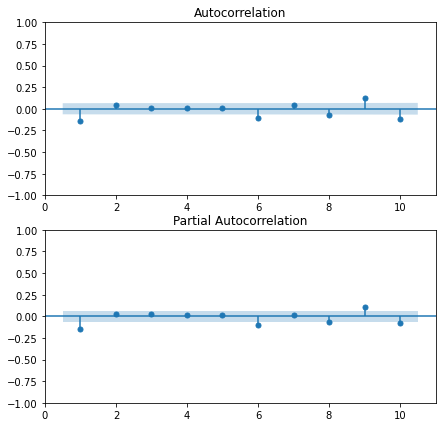

AR> 0 MA> 0 AIC> 5213.744678203816 BIC> 5218.580937481093
AR> 0 MA> 1 AIC> 5192.548655987961 BIC> 5202.221174542515
AR> 0 MA> 2 AIC> 5192.920931458724 BIC> 5207.429709290555
AR> 0 MA> 3 AIC> 5194.91184769946 BIC> 5214.256884808568
AR> 1 MA> 0 AIC> 5191.208924322222 BIC> 5200.8814428767755
AR> 1 MA> 1 AIC> 5193.012554797166 BIC> 5207.521332628997
AR> 1 MA> 2 AIC> 5194.905484214846 BIC> 5214.250521323955
AR> 1 MA> 3 AIC> 5193.473228133223 BIC> 5217.654524519608
AR> 2 MA> 0 AIC> 5192.992996850309 BIC> 5207.50177468214
AR> 2 MA> 1 AIC> 5194.933031488873 BIC> 5214.2780685979815
AR> 2 MA> 2 AIC> 5197.009622666725 BIC> 5221.19091905311
AR> 2 MA> 3 AIC> 5198.890145254208 BIC> 5227.90770091787


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 3 MA> 0 AIC> 5194.9357879375475 BIC> 5214.280825046656
AR> 3 MA> 1 AIC> 5196.9261386414855 BIC> 5221.10743502787
AR> 3 MA> 2 AIC> 5198.919924897969 BIC> 5227.937480561632
AR> 3 MA> 3 AIC> 5174.946147412911 BIC> 5208.799962353851
3 3 5174.946147412911 5208.799962353851
ADF TEST > (-10.20280359393621, 5.909564482539238e-18, 9, 922, {'1%': -3.437462363899248, '5%': -2.8646798473884134, '10%': -2.568441851017076}, 5108.955226708667)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [145]:
orderplot('2018-12-26')

# 36 1,1,0

# 37 2019-01-03

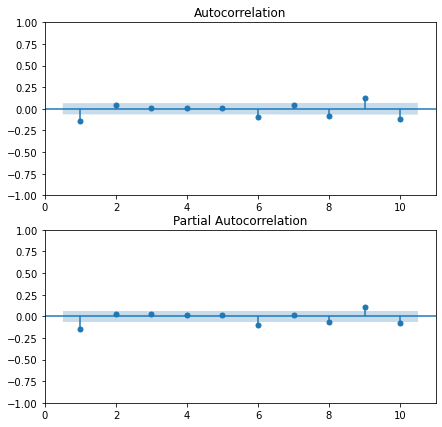

AR> 0 MA> 0 AIC> 5185.109264207349 BIC> 5189.939057944862
AR> 0 MA> 1 AIC> 5164.3389630922065 BIC> 5173.998550567231
AR> 0 MA> 2 AIC> 5164.705600692585 BIC> 5179.194981905122
AR> 0 MA> 3 AIC> 5166.6933040543245 BIC> 5186.012479004374
AR> 1 MA> 0 AIC> 5163.0103476710465 BIC> 5172.669935146071
AR> 1 MA> 1 AIC> 5164.807532432915 BIC> 5179.296913645452
AR> 1 MA> 2 AIC> 5166.686047446881 BIC> 5186.005222396931
AR> 1 MA> 3 AIC> 5165.234243630121 BIC> 5189.383212317683
AR> 2 MA> 0 AIC> 5164.786014678074 BIC> 5179.275395890611
AR> 2 MA> 1 AIC> 5166.720274146996 BIC> 5186.039449097046


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


AR> 2 MA> 2 AIC> 10.0 BIC> 34.148968687562125
AR> 2 MA> 3 AIC> 5170.672944994142 BIC> 5199.651707419217


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 3 MA> 0 AIC> 5166.720794740936 BIC> 5186.039969690985
AR> 3 MA> 1 AIC> 5168.710655750941 BIC> 5192.8596244385035
AR> 3 MA> 2 AIC> 5170.704330707806 BIC> 5199.6830931328805
AR> 3 MA> 3 AIC> 5146.8500365474665 BIC> 5180.658592710053
3 3 5146.8500365474665 5180.658592710053
ADF TEST > (-10.17514762203916, 6.923762038608103e-18, 9, 916, {'1%': -3.4375090829661534, '5%': -2.864700447588469, '10%': -2.5684528237924527}, 5079.653324300051)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [146]:
orderplot('2019-01-03')

# 37 1,1,0

# 38 2019-01-04

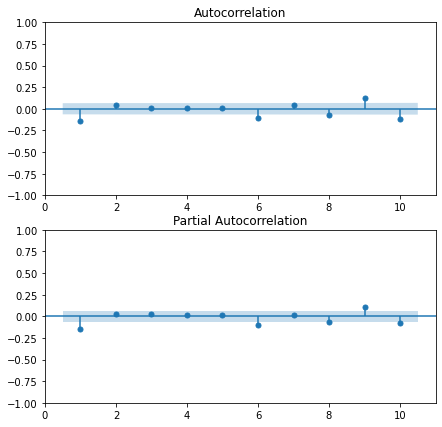

AR> 0 MA> 0 AIC> 5179.214156968725 BIC> 5184.042869040366
AR> 0 MA> 1 AIC> 5158.411767588421 BIC> 5168.069191731704
AR> 0 MA> 2 AIC> 5158.805084651914 BIC> 5173.291220866839
AR> 0 MA> 3 AIC> 5160.7952936949005 BIC> 5180.110141981467
AR> 1 MA> 0 AIC> 5157.094798641294 BIC> 5166.7522227845775
AR> 1 MA> 1 AIC> 5158.896987596514 BIC> 5173.383123811439
AR> 1 MA> 2 AIC> 5160.788284667227 BIC> 5180.103132953794
AR> 1 MA> 3 AIC> 5159.384813371725 BIC> 5183.528373729933
AR> 2 MA> 0 AIC> 5158.877293817328 BIC> 5173.363430032253
AR> 2 MA> 1 AIC> 5160.816313811254 BIC> 5180.13116209782


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


AR> 2 MA> 2 AIC> 5162.2921612054715 BIC> 5186.43572156368
AR> 2 MA> 3 AIC> 5164.773121120466 BIC> 5193.745393550316


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 3 MA> 0 AIC> 5160.8195918128185 BIC> 5180.134440099385
AR> 3 MA> 1 AIC> 5162.798112352962 BIC> 5186.94167271117
AR> 3 MA> 2 AIC> 5164.803190220027 BIC> 5193.775462649877
AR> 3 MA> 3 AIC> 5141.353266978021 BIC> 5175.154251479513
3 3 5141.353266978021 5175.154251479513
ADF TEST > (-10.168766057590817, 7.181668802029449e-18, 9, 915, {'1%': -3.437516929214992, '5%': -2.86470390726455, '10%': -2.5684546666069457}, 5074.559417091915)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [147]:
orderplot('2019-01-04')

# 38 1,1,0

# 39 2019-01-15

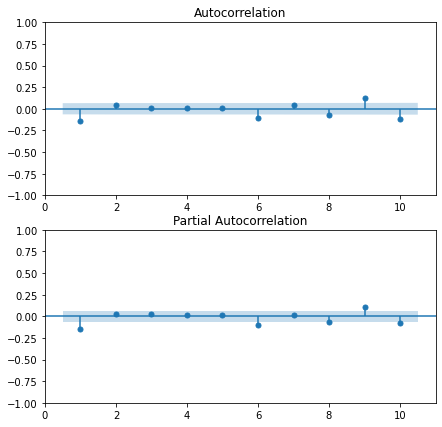

AR> 0 MA> 0 AIC> 5146.144890590778 BIC> 5150.965998063035
AR> 0 MA> 1 AIC> 5125.47490827135 BIC> 5135.117123215862
AR> 0 MA> 2 AIC> 5125.869863009302 BIC> 5140.333185426071
AR> 0 MA> 3 AIC> 5127.859852240554 BIC> 5147.14428212958
AR> 1 MA> 0 AIC> 5124.160429718466 BIC> 5133.802644662978
AR> 1 MA> 1 AIC> 5125.96200985959 BIC> 5140.425332276359
AR> 1 MA> 2 AIC> 5127.852676398235 BIC> 5147.137106287261
AR> 1 MA> 3 AIC> 5126.468436382085 BIC> 5150.573973743368
AR> 2 MA> 0 AIC> 5125.942200334348 BIC> 5140.405522751117
AR> 2 MA> 1 AIC> 5127.8808854106555 BIC> 5147.165315299681
AR> 2 MA> 2 AIC> 5129.415441571675 BIC> 5153.520978932957
AR> 2 MA> 3 AIC> 5131.837327538324 BIC> 5160.763972371862


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 3 MA> 0 AIC> 5127.88445312064 BIC> 5147.1688830096655
AR> 3 MA> 1 AIC> 5129.874588289582 BIC> 5153.9801256508645
AR> 3 MA> 2 AIC> 5131.867798664272 BIC> 5160.794443497811
AR> 3 MA> 3 AIC> 5108.216111582702 BIC> 5141.963863888497
3 3 5108.216111582702 5141.963863888497
ADF TEST > (-10.128502541389135, 9.047540477838421e-18, 9, 908, {'1%': -3.4375723382479735, '5%': -2.8647283387229963, '10%': -2.568467680189796}, 5042.00589911081)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [148]:
orderplot('2019-01-15')

# 39 1,1,0

# 40 2019-01-30

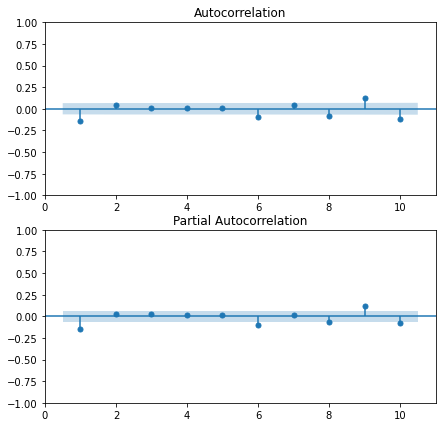

AR> 0 MA> 0 AIC> 5093.61988113695 BIC> 5098.428920442993
AR> 0 MA> 1 AIC> 5073.406022749653 BIC> 5083.024101361739
AR> 0 MA> 2 AIC> 5073.789541644257 BIC> 5088.216659562386
AR> 0 MA> 3 AIC> 5075.786136232795 BIC> 5095.0222934569665
AR> 1 MA> 0 AIC> 5072.085947201922 BIC> 5081.704025814008
AR> 1 MA> 1 AIC> 5073.8612338556895 BIC> 5088.288351773818
AR> 1 MA> 2 AIC> 5075.782634313271 BIC> 5095.018791537443
AR> 1 MA> 3 AIC> 5074.492694724471 BIC> 5098.537891254686
AR> 2 MA> 0 AIC> 5073.841464711839 BIC> 5088.268582629968
AR> 2 MA> 1 AIC> 5075.789944338145 BIC> 5095.026101562316
AR> 2 MA> 2 AIC> 5077.72751851261 BIC> 5101.7727150428245
AR> 2 MA> 3 AIC> 5079.759259311528 BIC> 5108.613495147785


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 3 MA> 0 AIC> 5075.798891572224 BIC> 5095.035048796396
AR> 3 MA> 1 AIC> 5077.790623185402 BIC> 5101.835819715617
AR> 3 MA> 2 AIC> 5079.783679420558 BIC> 5108.637915256815
AR> 3 MA> 3 AIC> 5056.7193960226605 BIC> 5090.382671164962
3 3 5056.7193960226605 5090.382671164962
ADF TEST > (-10.055337714551966, 1.3778340025720156e-17, 9, 897, {'1%': -3.4376611618861697, '5%': -2.864767502722044, '10%': -2.5684885413039127}, 4990.708249141629)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [149]:
orderplot('2019-01-30')

# 40 1,1,0

# 41 2019-02-04

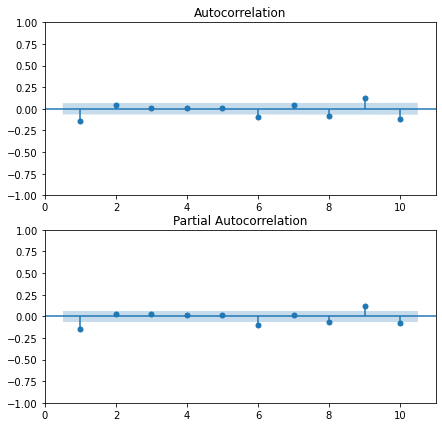

AR> 0 MA> 0 AIC> 5078.811430655505 BIC> 5083.617153208922
AR> 0 MA> 1 AIC> 5058.612141143454 BIC> 5068.2235862502885
AR> 0 MA> 2 AIC> 5058.927138025756 BIC> 5073.344305686007
AR> 0 MA> 3 AIC> 5060.923301237679 BIC> 5080.146191451347
AR> 1 MA> 0 AIC> 5057.253315715943 BIC> 5066.8647608227775
AR> 1 MA> 1 AIC> 5059.008616605652 BIC> 5073.425784265903
AR> 1 MA> 2 AIC> 5060.9199486641855 BIC> 5080.142838877853
AR> 1 MA> 3 AIC> 5059.629307200895 BIC> 5083.65791996798
AR> 2 MA> 0 AIC> 5058.985005781444 BIC> 5073.402173441695
AR> 2 MA> 1 AIC> 5060.92911848925 BIC> 5080.152008702918
AR> 2 MA> 2 AIC> 5062.468255922111 BIC> 5086.496868689196
AR> 2 MA> 3 AIC> 5064.897144547804 BIC> 5093.7314798683055


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 3 MA> 0 AIC> 5060.9367671901855 BIC> 5080.159657403853
AR> 3 MA> 1 AIC> 5062.928364543106 BIC> 5086.956977310191
AR> 3 MA> 2 AIC> 5064.921758361766 BIC> 5093.756093682267
AR> 3 MA> 3 AIC> 5041.547658507072 BIC> 5075.18771638099
3 3 5041.547658507072 5075.18771638099
ADF TEST > (-10.039360592986242, 1.5106092879957966e-17, 9, 894, {'1%': -3.4376857669714957, '5%': -2.864778351359889, '10%': -2.5684943199755765}, 4976.819841206257)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [150]:
orderplot('2019-02-04')

# 41 1,1,0

# 42 2019-04-25

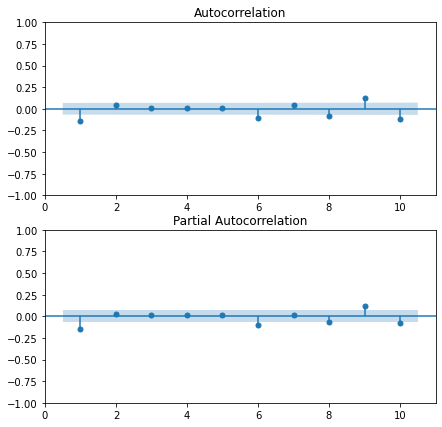

AR> 0 MA> 0 AIC> 4804.156033859128 BIC> 4808.895370486485
AR> 0 MA> 1 AIC> 4785.1733397146145 BIC> 4794.652012969329
AR> 0 MA> 2 AIC> 4785.654628754088 BIC> 4799.8726386361595
AR> 0 MA> 3 AIC> 4787.654090725864 BIC> 4806.611437235293
AR> 1 MA> 0 AIC> 4783.918554788236 BIC> 4793.397228042951
AR> 1 MA> 1 AIC> 4785.700876737363 BIC> 4799.9188866194345
AR> 1 MA> 2 AIC> 4787.653177101174 BIC> 4806.610523610603
AR> 1 MA> 3 AIC> 4786.674180049986 BIC> 4810.370863186772
AR> 2 MA> 0 AIC> 4785.684894225988 BIC> 4799.902904108059
AR> 2 MA> 1 AIC> 4787.648879726945 BIC> 4806.606226236374


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 4789.638587154497 BIC> 4813.335270291283
AR> 2 MA> 3 AIC> 4791.624266115358 BIC> 4820.060285879501
AR> 3 MA> 0 AIC> 4787.657759323323 BIC> 4806.615105832752
AR> 3 MA> 1 AIC> 4789.650982888543 BIC> 4813.347666025329
AR> 3 MA> 2 AIC> 4791.64446114812 BIC> 4820.080480912263
AR> 3 MA> 3 AIC> 4770.113006951962 BIC> 4803.288363343462
3 3 4770.113006951962 4803.288363343462
ADF TEST > (-9.688196969689594, 1.1552914227051455e-16, 9, 836, {'1%': -3.4381962830171444, '5%': -2.8650034233058093, '10%': -2.568614210583549}, 4700.218105498881)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [151]:
orderplot('2019-04-25')

# 42 1,1,0

# 43 2019-05-13

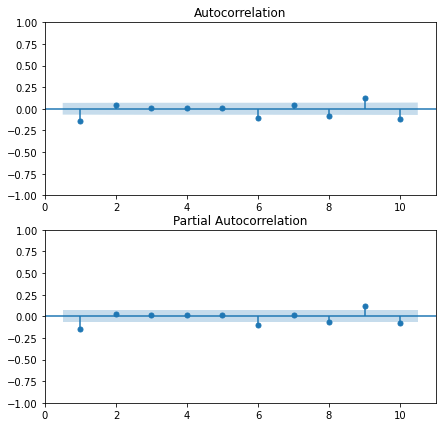

AR> 0 MA> 0 AIC> 4745.4008606046045 BIC> 4750.125894246771
AR> 0 MA> 1 AIC> 4726.890181439518 BIC> 4736.340248723851
AR> 0 MA> 2 AIC> 4727.298338793115 BIC> 4741.473439719616
AR> 0 MA> 3 AIC> 4729.297841426581 BIC> 4748.197975995248
AR> 1 MA> 0 AIC> 4725.607704222811 BIC> 4735.057771507144
AR> 1 MA> 1 AIC> 4727.3581728604095 BIC> 4741.53327378691
AR> 1 MA> 2 AIC> 4729.2972977183235 BIC> 4748.197432286991
AR> 1 MA> 3 AIC> 4728.294563070812 BIC> 4751.919731281646
AR> 2 MA> 0 AIC> 4727.336788189425 BIC> 4741.511889115925
AR> 2 MA> 1 AIC> 4729.294884154715 BIC> 4748.195018723382
AR> 2 MA> 2 AIC> 4730.923090215481 BIC> 4754.548258426315
AR> 2 MA> 3 AIC> 4733.273540125018 BIC> 4761.623741978019


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 3 MA> 0 AIC> 4729.301875209287 BIC> 4748.202009777954
AR> 3 MA> 1 AIC> 4731.295702417046 BIC> 4754.9208706278805
AR> 3 MA> 2 AIC> 4733.291189239932 BIC> 4761.641391092932
AR> 3 MA> 3 AIC> 4712.14849152568 BIC> 4745.223727020848
3 3 4712.14849152568 4745.223727020848
ADF TEST > (-9.613726355074524, 1.783291255352441e-16, 9, 824, {'1%': -3.438310908190086, '5%': -2.8650539530590673, '10%': -2.5686411274036196}, 4640.356965496853)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [152]:
orderplot('2019-05-13')

# 43 1,1,0

# 44 2019-06-03

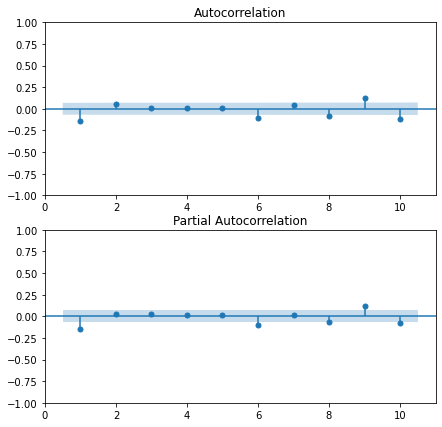

AR> 0 MA> 0 AIC> 4672.558412103985 BIC> 4677.265274440588
AR> 0 MA> 1 AIC> 4654.440653792586 BIC> 4663.854378465791
AR> 0 MA> 2 AIC> 4654.745229396067 BIC> 4668.865816405875
AR> 0 MA> 3 AIC> 4656.743072559619 BIC> 4675.57052190603
AR> 1 MA> 0 AIC> 4653.111709008932 BIC> 4662.525433682137
AR> 1 MA> 1 AIC> 4654.82343182474 BIC> 4668.944018834548
AR> 1 MA> 2 AIC> 4656.742181776065 BIC> 4675.5696311224765
AR> 1 MA> 3 AIC> 4655.787987331165 BIC> 4679.3222990141785
AR> 2 MA> 0 AIC> 4654.795379972311 BIC> 4668.915966982119
AR> 2 MA> 1 AIC> 4656.739680138531 BIC> 4675.567129484943


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 4658.727061864425 BIC> 4682.261373547439
AR> 2 MA> 3 AIC> 4660.712785083551 BIC> 4688.953959103168
AR> 3 MA> 0 AIC> 4656.750860689705 BIC> 4675.578310036117
AR> 3 MA> 1 AIC> 4658.742746342396 BIC> 4682.277058025409
AR> 3 MA> 2 AIC> 4660.7352948349235 BIC> 4688.97646885454
AR> 3 MA> 3 AIC> 4639.942560577658 BIC> 4672.890596933877
3 3 4639.942560577658 4672.890596933877
ADF TEST > (-9.526850626188503, 2.962029644185429e-16, 9, 809, {'1%': -3.4384589869479023, '5%': -2.8651192271940693, '10%': -2.5686758988725416}, 4568.1106466358815)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [153]:
orderplot('2019-06-03')

# 44 1,1,0

# 45 2019-06-04

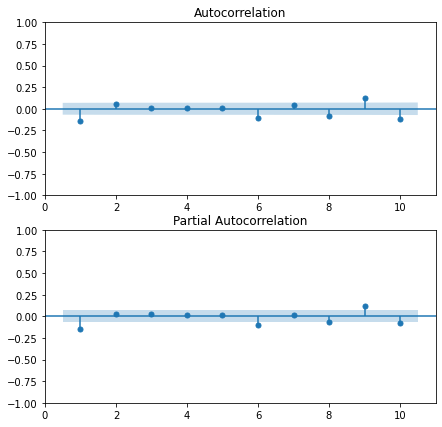

AR> 0 MA> 0 AIC> 4667.224791787236 BIC> 4671.9304308820965
AR> 0 MA> 1 AIC> 4648.925292005 BIC> 4658.3365701947205
AR> 0 MA> 2 AIC> 4649.281113651345 BIC> 4663.398030935925
AR> 0 MA> 3 AIC> 4651.280842469036 BIC> 4670.103398848476
AR> 1 MA> 0 AIC> 4647.610974775256 BIC> 4657.022252964976
AR> 1 MA> 1 AIC> 4649.338065349617 BIC> 4663.454982634197
AR> 1 MA> 2 AIC> 4651.280404542731 BIC> 4670.102960922171
AR> 1 MA> 3 AIC> 4650.34477241829 BIC> 4673.87296789259
AR> 2 MA> 0 AIC> 4649.3150330874305 BIC> 4663.431950372011
AR> 2 MA> 1 AIC> 4651.273012035168 BIC> 4670.095568414608


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 4653.263493124839 BIC> 4676.79168859914
AR> 2 MA> 3 AIC> 4655.250327126878 BIC> 4683.4841616960375
AR> 3 MA> 0 AIC> 4651.281895270848 BIC> 4670.104451650288
AR> 3 MA> 1 AIC> 4653.275170030784 BIC> 4676.803365505084
AR> 3 MA> 2 AIC> 4655.268625804687 BIC> 4683.502460373847
AR> 3 MA> 3 AIC> 4634.355271421039 BIC> 4667.294745085059
3 3 4634.355271421039 4667.294745085059
ADF TEST > (-9.51858006684919, 3.10878730395603e-16, 9, 808, {'1%': -3.4384690549764856, '5%': -2.8651236651346306, '10%': -2.568678262976669}, 4563.403018236566)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [154]:
orderplot('2019-06-04')

#  45 1.1.0

# 46 2019-06-07

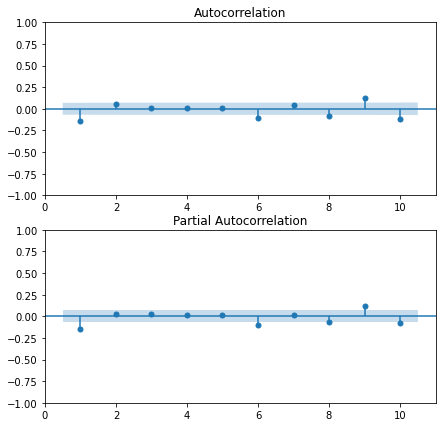

AR> 0 MA> 0 AIC> 4651.74028144709 BIC> 4656.442241813093
AR> 0 MA> 1 AIC> 4633.128576842377 BIC> 4642.5324975743815
AR> 0 MA> 2 AIC> 4633.529538829815 BIC> 4647.635419927822
AR> 0 MA> 3 AIC> 4635.529190793135 BIC> 4654.337032257145
AR> 1 MA> 0 AIC> 4631.827013900182 BIC> 4641.230934632186
AR> 1 MA> 1 AIC> 4633.583442906474 BIC> 4647.689324004482
AR> 1 MA> 2 AIC> 4635.528715424229 BIC> 4654.336556888239
AR> 1 MA> 3 AIC> 4634.626447928368 BIC> 4658.1362497583805
AR> 2 MA> 0 AIC> 4633.563651526125 BIC> 4647.669532624132
AR> 2 MA> 1 AIC> 4635.5250565207425 BIC> 4654.332897984753


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 4637.513130079049 BIC> 4661.022931909061
AR> 2 MA> 3 AIC> 4639.500085310365 BIC> 4667.71184750638
AR> 3 MA> 0 AIC> 4635.531649904406 BIC> 4654.339491368416
AR> 3 MA> 1 AIC> 4637.524972234924 BIC> 4661.034774064936
AR> 3 MA> 2 AIC> 4639.518832813725 BIC> 4667.73059500974
AR> 3 MA> 3 AIC> 4618.785386855274 BIC> 4651.699109417292
3 3 4618.785386855274 4651.699109417292
ADF TEST > (-9.51848289382141, 3.110554290290193e-16, 9, 805, {'1%': -3.4384994096285393, '5%': -2.8651370452361107, '10%': -2.56868539060993}, 4549.228486809553)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [155]:
orderplot('2019-06-07')

# 46 1,1,0

# 47 2019-06-25

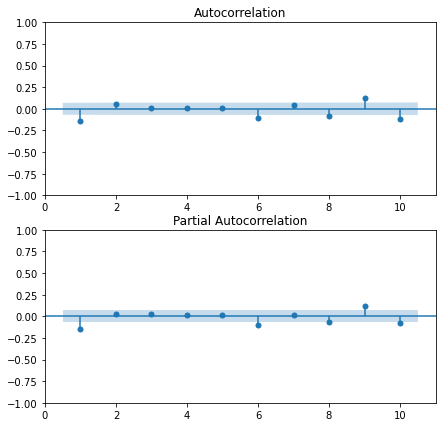

AR> 0 MA> 0 AIC> 4593.450546563485 BIC> 4598.137655171351
AR> 0 MA> 1 AIC> 4575.116372170866 BIC> 4584.490589386599
AR> 0 MA> 2 AIC> 4575.547698511801 BIC> 4589.609024335401
AR> 0 MA> 3 AIC> 4577.547049246672 BIC> 4596.295483678138
AR> 1 MA> 0 AIC> 4573.837068816438 BIC> 4583.21128603217
AR> 1 MA> 1 AIC> 4575.600984980963 BIC> 4589.662310804563
AR> 1 MA> 2 AIC> 4577.546007370216 BIC> 4596.294441801682
AR> 1 MA> 3 AIC> 4576.660401221373 BIC> 4600.095944260705
AR> 2 MA> 0 AIC> 4575.581988158503 BIC> 4589.643313982103
AR> 2 MA> 1 AIC> 4577.540754286227 BIC> 4596.289188717693


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 4579.529528104515 BIC> 4602.965071143847
AR> 2 MA> 3 AIC> 4581.51533585124 BIC> 4609.637987498439
AR> 3 MA> 0 AIC> 4577.550410358612 BIC> 4596.298844790078
AR> 3 MA> 1 AIC> 4579.543200244322 BIC> 4602.978743283655
AR> 3 MA> 2 AIC> 4581.5355412736535 BIC> 4609.658192920852
AR> 3 MA> 3 AIC> 4560.930857217668 BIC> 4593.740617472733
3 3 4560.930857217668 4593.740617472733
ADF TEST > (-9.444876781808725, 4.785305762076754e-16, 9, 793, {'1%': -3.438623132449471, '5%': -2.8651915799370014, '10%': -2.568714441670417}, 4491.833363879402)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [156]:
orderplot('2019-06-25')

# 47 order 1.1.0

# 48 2019-07-31

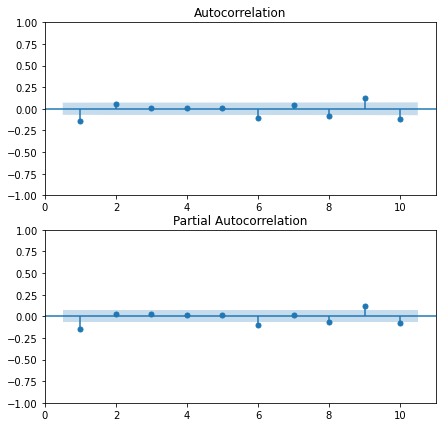

AR> 0 MA> 0 AIC> 4468.198029379462 BIC> 4472.852181899645
AR> 0 MA> 1 AIC> 4450.378767590853 BIC> 4459.68707263122
AR> 0 MA> 2 AIC> 4450.907949675715 BIC> 4464.870407236264
AR> 0 MA> 3 AIC> 4452.907905092516 BIC> 4471.524515173249
AR> 1 MA> 0 AIC> 4449.1580824735365 BIC> 4458.466387513903
AR> 1 MA> 1 AIC> 4450.943464755634 BIC> 4464.905922316183
AR> 1 MA> 2 AIC> 4452.908171189894 BIC> 4471.5247812706275
AR> 1 MA> 3 AIC> 4452.138587468229 BIC> 4475.409350069145
AR> 2 MA> 0 AIC> 4450.92876534973 BIC> 4464.89122291028
AR> 2 MA> 1 AIC> 4452.892084797185 BIC> 4471.508694877918


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 4454.887251896749 BIC> 4478.158014497665
AR> 2 MA> 3 AIC> 4456.873166236394 BIC> 4484.798081357494
AR> 3 MA> 0 AIC> 4452.906277127439 BIC> 4471.5228872081725
AR> 3 MA> 1 AIC> 4454.899828102744 BIC> 4478.17059070366
AR> 3 MA> 2 AIC> 4456.891088975008 BIC> 4484.8160040961075
AR> 3 MA> 3 AIC> 4436.957006859035 BIC> 4469.536074500317
3 3 4436.957006859035 4469.536074500317
ADF TEST > (-9.2737468475736, 1.3056972639403582e-15, 9, 767, {'1%': -3.4389045244994096, '5%': -2.8653156040031176, '10%': -2.5687805115003}, 4361.0134657208)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [157]:
orderplot('2019-07-31')

# 48 1,1,0

# 49 2019-08-05

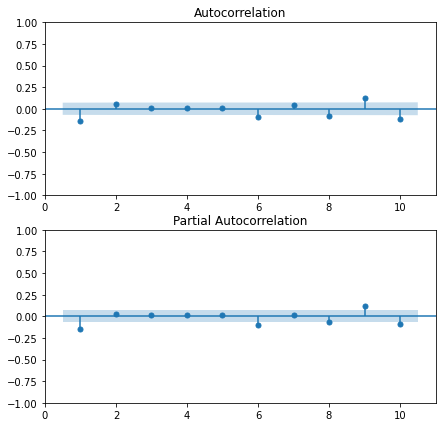

AR> 0 MA> 0 AIC> 4452.4949760066265 BIC> 4457.145255055214
AR> 0 MA> 1 AIC> 4434.860473963354 BIC> 4444.161032060529
AR> 0 MA> 2 AIC> 4435.308185974833 BIC> 4449.259023120595
AR> 0 MA> 3 AIC> 4437.30725792008 BIC> 4455.9083741144295
AR> 1 MA> 0 AIC> 4433.603205435351 BIC> 4442.903763532526
AR> 1 MA> 1 AIC> 4435.363364468349 BIC> 4449.314201614111
AR> 1 MA> 2 AIC> 4437.305833133481 BIC> 4455.906949327831
AR> 1 MA> 3 AIC> 4436.553182728597 BIC> 4459.804577971534
AR> 2 MA> 0 AIC> 4435.343609884587 BIC> 4449.294447030349
AR> 2 MA> 1 AIC> 4437.299026458135 BIC> 4455.900142652485


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 4439.2884814105 BIC> 4462.539876653437
AR> 2 MA> 3 AIC> 4441.2734246583495 BIC> 4469.175098949874
AR> 3 MA> 0 AIC> 4437.311292536413 BIC> 4455.912408730763
AR> 3 MA> 1 AIC> 4439.303608020611 BIC> 4462.555003263548
AR> 3 MA> 2 AIC> 4441.294769588372 BIC> 4469.196443879897
AR> 3 MA> 3 AIC> 4421.59354224536 BIC> 4454.145495585472
3 3 4421.59354224536 4454.145495585472
ADF TEST > (-9.263362241632906, 1.3878273375474873e-15, 9, 764, {'1%': -3.438938229437747, '5%': -2.8653304587462944, '10%': -2.568788425002056}, 4346.358061844314)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [158]:
orderplot('2019-08-05')

# 49 1,1,0

# 50 2019-08-08

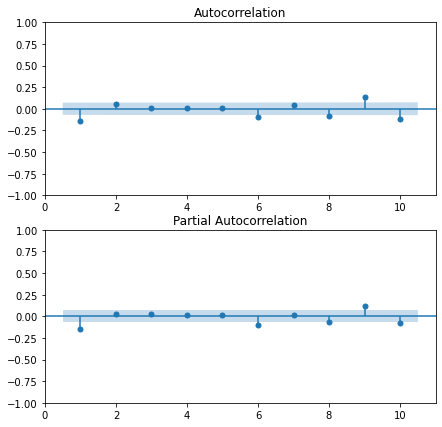

AR> 0 MA> 0 AIC> 4437.166399510976 BIC> 4441.812790025823
AR> 0 MA> 1 AIC> 4419.568302468005 BIC> 4428.8610834977
AR> 0 MA> 2 AIC> 4420.029143034292 BIC> 4433.968314578836
AR> 0 MA> 3 AIC> 4422.028024287558 BIC> 4440.613586346949
AR> 1 MA> 0 AIC> 4418.317070840849 BIC> 4427.609851870544
AR> 1 MA> 1 AIC> 4420.07977758929 BIC> 4434.018949133833
AR> 1 MA> 2 AIC> 4422.02640513117 BIC> 4440.611967190561
AR> 1 MA> 3 AIC> 4421.346462808196 BIC> 4444.578415382434
AR> 2 MA> 0 AIC> 4420.061095057321 BIC> 4434.0002666018645
AR> 2 MA> 1 AIC> 4422.0145899432655 BIC> 4440.600152002657


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 4424.00646101786 BIC> 4447.238413592098
AR> 2 MA> 3 AIC> 4425.988609264228 BIC> 4453.866952353314
AR> 3 MA> 0 AIC> 4422.032045738198 BIC> 4440.617607797589
AR> 3 MA> 1 AIC> 4424.009739582441 BIC> 4447.24169215668
AR> 3 MA> 2 AIC> 4426.01272692599 BIC> 4453.891070015076
AR> 3 MA> 3 AIC> 4406.332357778461 BIC> 4438.857091382395
3 3 4406.332357778461 4438.857091382395
ADF TEST > (-9.24169339074293, 1.5762652991449e-15, 9, 761, {'1%': -3.4389722010249386, '5%': -2.8653454308425705, '10%': -2.5687964010457227}, 4336.310456699506)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [159]:
orderplot('2019-08-08')

# 50 1,1,0

# 51 2019-08-14

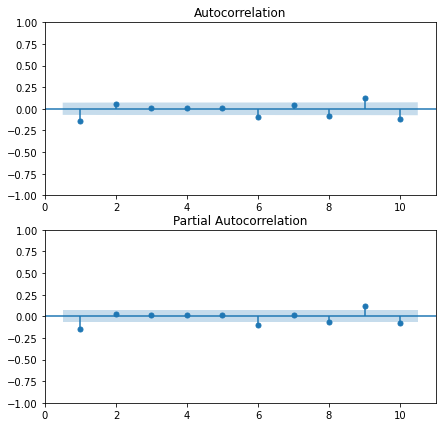

AR> 0 MA> 0 AIC> 4416.276421797362 BIC> 4420.917603967102
AR> 0 MA> 1 AIC> 4398.960821253139 BIC> 4408.243185592621
AR> 0 MA> 2 AIC> 4399.394171389934 BIC> 4413.3177178991555
AR> 0 MA> 3 AIC> 4401.393615633641 BIC> 4419.958344312604
AR> 1 MA> 0 AIC> 4397.701358037066 BIC> 4406.983722376547
AR> 1 MA> 1 AIC> 4399.443192882731 BIC> 4413.366739391952
AR> 1 MA> 2 AIC> 4401.392355405409 BIC> 4419.957084084372
AR> 1 MA> 3 AIC> 4400.7231363615065 BIC> 4423.929047210209
AR> 2 MA> 0 AIC> 4399.42287394373 BIC> 4413.346420452952
AR> 2 MA> 1 AIC> 4401.376474927123 BIC> 4419.941203606086


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 4403.370354047753 BIC> 4426.5762648964555
AR> 2 MA> 3 AIC> 4405.353635541539 BIC> 4433.200728559983
AR> 3 MA> 0 AIC> 4401.3941088853 BIC> 4419.9588375642625
AR> 3 MA> 1 AIC> 4403.3727642300855 BIC> 4426.578675078788
AR> 3 MA> 2 AIC> 4405.375263003383 BIC> 4433.222356021827
AR> 3 MA> 3 AIC> 4385.83082546195 BIC> 4418.319100650134
3 3 4385.83082546195 4418.319100650134
ADF TEST > (-9.223539335643098, 1.753748023014289e-15, 9, 757, {'1%': -3.4390179167598367, '5%': -2.8653655786032237, '10%': -2.5688071343462777}, 4316.800516109385)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [160]:
orderplot('2019-08-14')

# 51 1,1,0

# 52 2019-08-23

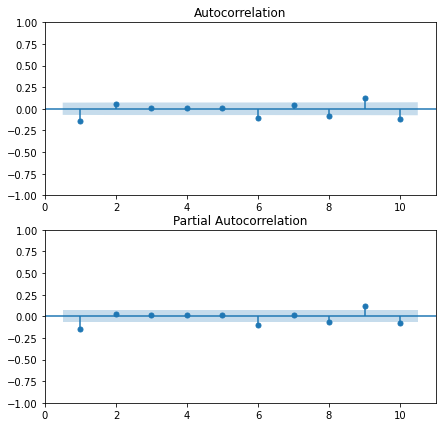

AR> 0 MA> 0 AIC> 4381.028256267033 BIC> 4385.660258044429
AR> 0 MA> 1 AIC> 4363.907608750078 BIC> 4373.171612304869
AR> 0 MA> 2 AIC> 4364.317146135041 BIC> 4378.213151467228
AR> 0 MA> 3 AIC> 4366.316775632273 BIC> 4384.844782741855
AR> 1 MA> 0 AIC> 4362.634532237951 BIC> 4371.898535792742
AR> 1 MA> 1 AIC> 4364.356977184002 BIC> 4378.252982516189
AR> 1 MA> 2 AIC> 4366.315409574119 BIC> 4384.843416683701
AR> 1 MA> 3 AIC> 4365.709416467674 BIC> 4388.869425354652
AR> 2 MA> 0 AIC> 4364.336996583364 BIC> 4378.2330019155515
AR> 2 MA> 1 AIC> 4366.291278268883 BIC> 4384.819285378465
AR> 2 MA> 2 AIC> 4368.315263196546 BIC> 4391.475272083524


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 3 AIC> 4371.8072017863 BIC> 4399.599212450674
AR> 3 MA> 0 AIC> 4366.313279910935 BIC> 4384.8412870205175
AR> 3 MA> 1 AIC> 4368.304870418974 BIC> 4391.464879305952
AR> 3 MA> 2 AIC> 4370.289879053415 BIC> 4398.081889717789
AR> 3 MA> 3 AIC> 4352.022875198521 BIC> 4384.446887640291
3 3 4352.022875198521 4384.446887640291
ADF TEST > (-9.177396779874227, 2.3003571548179856e-15, 9, 750, {'1%': -3.439099096730074, '5%': -2.8654013553540745, '10%': -2.568826193777778}, 4282.708253037097)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [161]:
orderplot('2019-08-23')

# 52 1,1,0

# 53 2020-01-30

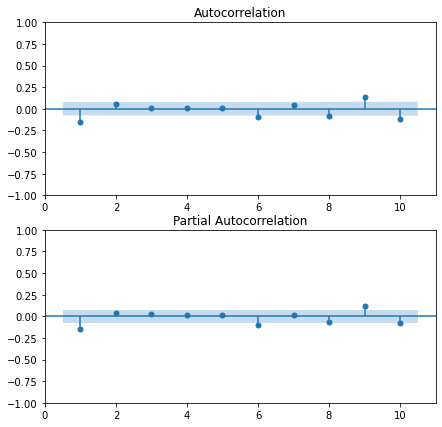

AR> 0 MA> 0 AIC> 3817.0013271613884 BIC> 3821.470577478184
AR> 0 MA> 1 AIC> 3802.159163615329 BIC> 3811.0976642489204
AR> 0 MA> 2 AIC> 3802.7535798564286 BIC> 3816.161330806816
AR> 0 MA> 3 AIC> 3804.753549839456 BIC> 3822.630551106639
AR> 1 MA> 0 AIC> 3801.0263329905133 BIC> 3809.964833624105
AR> 1 MA> 1 AIC> 3802.7939888862384 BIC> 3816.2017398366256
AR> 1 MA> 2 AIC> 3804.754095699113 BIC> 3822.631096966296
AR> 1 MA> 3 AIC> 3804.634000981513 BIC> 3826.980252565492
AR> 2 MA> 0 AIC> 3802.775946287895 BIC> 3816.183697238282
AR> 2 MA> 1 AIC> 3804.7419297784154 BIC> 3822.6189310455984
AR> 2 MA> 2 AIC> 3806.338301434097 BIC> 3828.684553018076


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 2 MA> 3 AIC> 3802.1456140372047 BIC> 3828.9611159379792
AR> 3 MA> 0 AIC> 3804.752139366336 BIC> 3822.629140633519
AR> 3 MA> 1 AIC> 3806.7386005056574 BIC> 3829.084852089636
AR> 3 MA> 2 AIC> 3808.740509986255 BIC> 3835.5560118870294


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 3 MA> 3 AIC> 3803.624925574688 BIC> 3834.909677792258
3 3 3803.624925574688 3834.909677792258
ADF TEST > (-8.452361990564443, 1.6492486252762964e-13, 9, 636, {'1%': -3.4406737255613256, '5%': -2.866095119842903, '10%': -2.5691958123689727}, 3702.831806026988)


(None, None, None)

In [162]:
orderplot('2020-01-30')

# 53 1,1,0

# 54 >> 2020-02-04

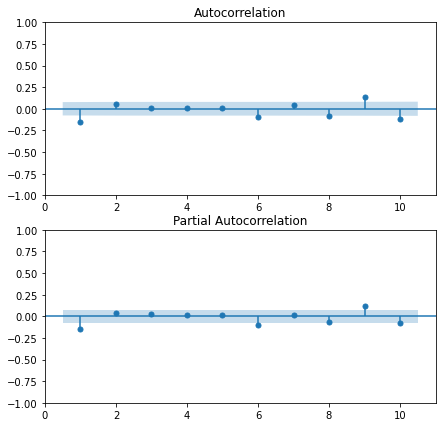

AR> 0 MA> 0 AIC> 3799.6441807036945 BIC> 3804.1087690073846
AR> 0 MA> 1 AIC> 3784.544723927565 BIC> 3793.4739005349447
AR> 0 MA> 2 AIC> 3785.1966772879305 BIC> 3798.5904421990003
AR> 0 MA> 3 AIC> 3787.194227378461 BIC> 3805.052580593221
AR> 1 MA> 0 AIC> 3783.4242350177174 BIC> 3792.353411625097
AR> 1 MA> 1 AIC> 3785.209196638279 BIC> 3798.602961549349
AR> 1 MA> 2 AIC> 3787.194685018175 BIC> 3805.053038232935
AR> 1 MA> 3 AIC> 3787.1502427999894 BIC> 3809.473184318439
AR> 2 MA> 0 AIC> 3785.1964153862154 BIC> 3798.5901802972853
AR> 2 MA> 1 AIC> 3787.1764580808363 BIC> 3805.0348112955962
AR> 2 MA> 2 AIC> 3789.183598136924 BIC> 3811.5065396553737


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 3 AIC> 3791.1665900698026 BIC> 3817.9541198919424
AR> 3 MA> 0 AIC> 3787.1835854241554 BIC> 3805.0419386389153
AR> 3 MA> 1 AIC> 3789.1800208754576 BIC> 3811.502962393907
AR> 3 MA> 2 AIC> 3791.176349194051 BIC> 3817.9638790161907
AR> 3 MA> 3 AIC> 3774.687452383127 BIC> 3805.939570508957
3 3 3774.687452383127 3805.939570508957
ADF TEST > (-8.434984122031036, 1.8269504823624696e-13, 9, 633, {'1%': -3.4407228537258865, '5%': -2.866116759417764, '10%': -2.5692073421780983}, 3679.814538276458)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [163]:
orderplot('2020-02-04')

# 54 1,1,0

# 55 2020-02-10

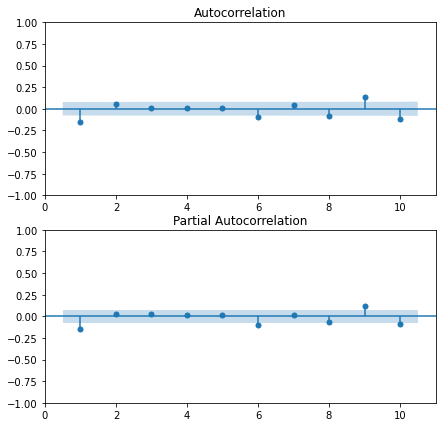

AR> 0 MA> 0 AIC> 3778.2663266380614 BIC> 3782.724664921406
AR> 0 MA> 1 AIC> 3763.415871091047 BIC> 3772.3325476577365
AR> 0 MA> 2 AIC> 3764.11722889684 BIC> 3777.4922437468745
AR> 0 MA> 3 AIC> 3766.1170335259512 BIC> 3783.9503866593304
AR> 1 MA> 0 AIC> 3762.3388443347176 BIC> 3771.255520901407
AR> 1 MA> 1 AIC> 3764.148018762757 BIC> 3777.5230336127916
AR> 1 MA> 2 AIC> 3766.1173135302843 BIC> 3783.9506666636635
AR> 1 MA> 3 AIC> 3765.970544717947 BIC> 3788.262236134671
AR> 2 MA> 0 AIC> 3764.1342021368605 BIC> 3777.509216986895
AR> 2 MA> 1 AIC> 3766.108028691281 BIC> 3783.9413818246603


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 3768.1038363989924 BIC> 3790.3955278157164
AR> 2 MA> 3 AIC> 3770.0946483365506 BIC> 3796.8446780366194
AR> 3 MA> 0 AIC> 3766.1141850124854 BIC> 3783.9475381458647
AR> 3 MA> 1 AIC> 3768.1099298099107 BIC> 3790.4016212266347
AR> 3 MA> 2 AIC> 3770.1066840588724 BIC> 3796.856713758941
AR> 3 MA> 3 AIC> 3753.5687863525854 BIC> 3784.777154335999
3 3 3753.5687863525854 3784.777154335999
ADF TEST > (-8.414621970549062, 2.0596329636590252e-13, 9, 629, {'1%': -3.4407890899441127, '5%': -2.8661459340578905, '10%': -2.5692228868342766}, 3650.1062426290473)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [164]:
orderplot('2020-02-10')

# 55 1,1,0

# 56 2020-02-21

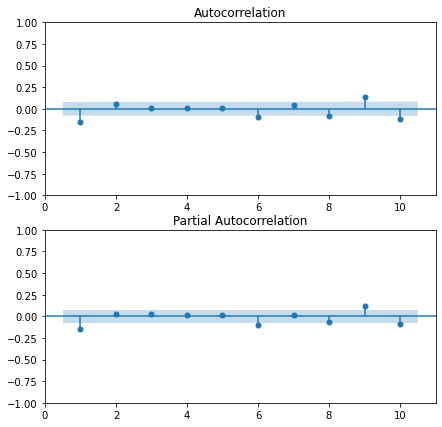

AR> 0 MA> 0 AIC> 3730.944690297801 BIC> 3735.3888215545016
AR> 0 MA> 1 AIC> 3715.0831284680394 BIC> 3723.9713909814404
AR> 0 MA> 2 AIC> 3715.943619452876 BIC> 3729.2760132229773
AR> 0 MA> 3 AIC> 3717.9435171498144 BIC> 3735.720042176616
AR> 1 MA> 0 AIC> 3714.076544536677 BIC> 3722.964807050078
AR> 1 MA> 1 AIC> 3715.9787126636093 BIC> 3729.3111064337104
AR> 1 MA> 2 AIC> 3717.9434813228136 BIC> 3735.7200063496152
AR> 1 MA> 3 AIC> 3717.7304446307144 BIC> 3739.9511009142166
AR> 2 MA> 0 AIC> 3715.9710533752905 BIC> 3729.3034471453916
AR> 2 MA> 1 AIC> 3717.949051909029 BIC> 3735.7255769358308
AR> 2 MA> 2 AIC> 3719.9454754802555 BIC> 3742.1661317637577


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 3 AIC> 3721.9349870747374 BIC> 3748.59977461494
AR> 3 MA> 0 AIC> 3717.9451476282456 BIC> 3735.7216726550473
AR> 3 MA> 1 AIC> 3719.942800159135 BIC> 3742.163456442637
AR> 3 MA> 2 AIC> 3721.942053814253 BIC> 3748.606841354456
AR> 3 MA> 3 AIC> 3706.4678493464044 BIC> 3737.5767681433076
3 3 3706.4678493464044 3737.5767681433076
ADF TEST > (-7.602050338987535, 2.3750560423330932e-11, 14, 615, {'1%': -3.4410277306083668, '5%': -2.8662510413264357, '10%': -2.569278890210853}, 3547.5770295423163)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [165]:
orderplot('2020-02-21')

# 56 1,1,0

# 57 2020-02-24

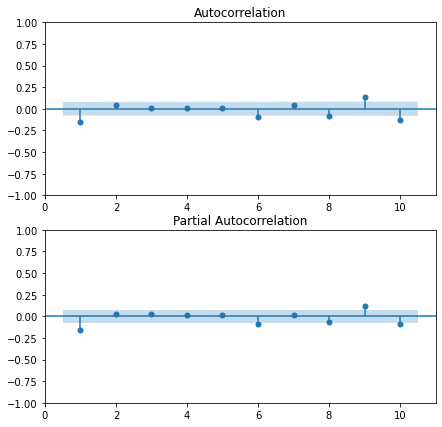

AR> 0 MA> 0 AIC> 3723.31754539529 BIC> 3727.760085561758
AR> 0 MA> 1 AIC> 3707.06797748176 BIC> 3715.9530578146964
AR> 0 MA> 2 AIC> 3707.9681470192036 BIC> 3721.295767518608
AR> 0 MA> 3 AIC> 3709.93592698088 BIC> 3727.706087646753
AR> 1 MA> 0 AIC> 3706.0328457207324 BIC> 3714.917926053669
AR> 1 MA> 1 AIC> 3707.9098763552074 BIC> 3721.237496854612
AR> 1 MA> 2 AIC> 3709.9098324181955 BIC> 3727.6799930840684
AR> 1 MA> 3 AIC> 3709.925665391592 BIC> 3732.1383662239327
AR> 2 MA> 0 AIC> 3707.9102676776806 BIC> 3721.237888177085
AR> 2 MA> 1 AIC> 3709.909842243179 BIC> 3727.680002909052


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 3711.909545747705 BIC> 3734.122246580046
AR> 2 MA> 3 AIC> 3713.9079069065574 BIC> 3740.563147905367
AR> 3 MA> 0 AIC> 3709.909958605918 BIC> 3727.6801192717908
AR> 3 MA> 1 AIC> 3711.910228219633 BIC> 3734.122929051974
AR> 3 MA> 2 AIC> 3713.9088954414965 BIC> 3740.564136440306
AR> 3 MA> 3 AIC> 3707.6301451858426 BIC> 3738.72792635112
3 3 3707.6301451858426 3738.72792635112
ADF TEST > (-7.159793086329185, 2.9887314597289543e-10, 14, 614, {'1%': -3.4410451945636207, '5%': -2.8662587328558566, '10%': -2.569282988466721}, 3542.719001719836)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [166]:
orderplot('2020-02-24')

# 57 1,1,0

# 58 2020-02-27

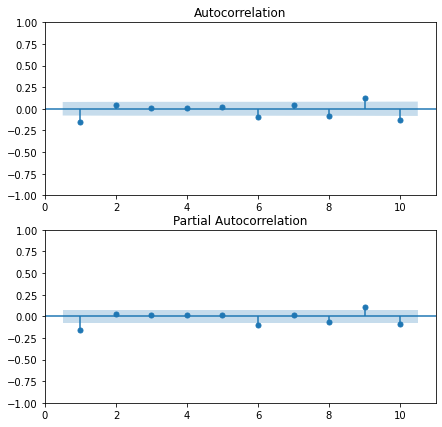

AR> 0 MA> 0 AIC> 3701.4073002413998 BIC> 3705.8450518911363
AR> 0 MA> 1 AIC> 3686.204872054973 BIC> 3695.0803753544456
AR> 0 MA> 2 AIC> 3686.870668621361 BIC> 3700.18392357057
AR> 0 MA> 3 AIC> 3688.778586899457 BIC> 3706.5295934984024
AR> 1 MA> 0 AIC> 3685.017431744443 BIC> 3693.8929350439157
AR> 1 MA> 1 AIC> 3686.6984471259443 BIC> 3700.0117020751536
AR> 1 MA> 2 AIC> 3688.694915040559 BIC> 3706.4459216395044
AR> 1 MA> 3 AIC> 3690.686628997374 BIC> 3712.875387246056
AR> 2 MA> 0 AIC> 3686.718482470966 BIC> 3700.0317374201754
AR> 2 MA> 1 AIC> 3688.6946223319896 BIC> 3706.445628930935
AR> 2 MA> 2 AIC> 3690.693093303725 BIC> 3712.881851552407


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 3 AIC> 3683.769195712248 BIC> 3710.3957056106665
AR> 3 MA> 0 AIC> 3688.6949051808742 BIC> 3706.4459117798197
AR> 3 MA> 1 AIC> 3690.7012851179097 BIC> 3712.8900433665917
AR> 3 MA> 2 AIC> 3692.6941561248404 BIC> 3719.320666023259
AR> 3 MA> 3 AIC> 3681.1860867358355 BIC> 3712.25034828399
3 3 3681.1860867358355 3712.25034828399
ADF TEST > (-7.452580048414732, 5.619814049938419e-11, 14, 611, {'1%': -3.4410979308822967, '5%': -2.8662819588823423, '10%': -2.5692953639629166}, 3525.694769853757)


(None, None, None)

In [167]:
orderplot('2020-02-27')

# 58 1,1,0

# 59 2020-03-02

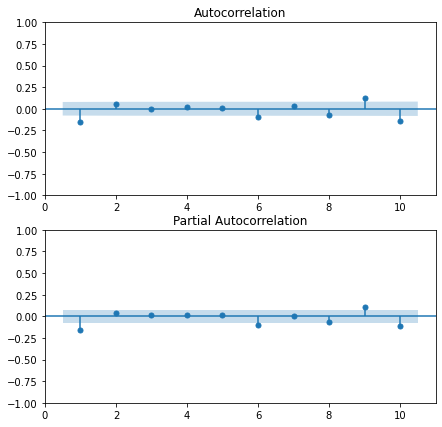

AR> 0 MA> 0 AIC> 3685.54828738515 BIC> 3689.9828339039377
AR> 0 MA> 1 AIC> 3670.712777110217 BIC> 3679.581870147792
AR> 0 MA> 2 AIC> 3671.411240225805 BIC> 3684.7148797821674
AR> 0 MA> 3 AIC> 3673.3508984157834 BIC> 3691.089084490933
AR> 1 MA> 0 AIC> 3669.557208517581 BIC> 3678.426301555156
AR> 1 MA> 1 AIC> 3671.2486741096754 BIC> 3684.5523136660377
AR> 1 MA> 2 AIC> 3673.24233261139 BIC> 3690.9805186865397
AR> 1 MA> 3 AIC> 3675.236818008535 BIC> 3697.4095506024723
AR> 2 MA> 0 AIC> 3671.2694714579848 BIC> 3684.573111014347
AR> 2 MA> 1 AIC> 3673.243417425031 BIC> 3690.981603500181


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 3675.2457743694335 BIC> 3697.418506963371
AR> 2 MA> 3 AIC> 3668.7943379033723 BIC> 3695.401617016097
AR> 3 MA> 0 AIC> 3673.247471335947 BIC> 3690.985657411097
AR> 3 MA> 1 AIC> 3675.256523700727 BIC> 3697.4292562946644
AR> 3 MA> 2 AIC> 3677.2428750440217 BIC> 3703.8501541567466
AR> 3 MA> 3 AIC> 3665.795190813114 BIC> 3696.837016444626
3 3 3665.795190813114 3696.837016444626
ADF TEST > (-29.230313074046798, 0.0, 0, 623, {'1%': -3.440890045708521, '5%': -2.8661904001753618, '10%': -2.569246579178572}, 3514.1483985743653)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [168]:
orderplot('2020-03-02')

# 59 1,1,0

# 60 2020-03-03

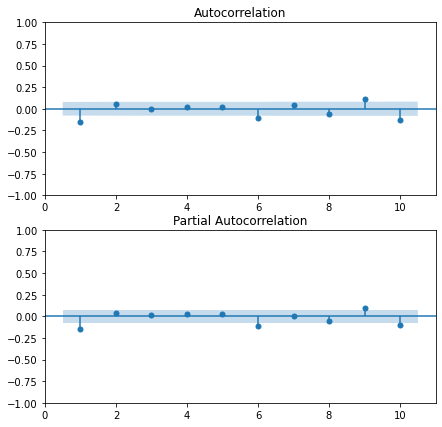

AR> 0 MA> 0 AIC> 3677.464332915384 BIC> 3681.897273008123
AR> 0 MA> 1 AIC> 3663.184532744331 BIC> 3672.0504129298097
AR> 0 MA> 2 AIC> 3664.0848291208567 BIC> 3677.3836493990743
AR> 0 MA> 3 AIC> 3665.95314858531 BIC> 3683.6849089562666
AR> 1 MA> 0 AIC> 3662.1597184759366 BIC> 3671.025598661415
AR> 1 MA> 1 AIC> 3663.892313296644 BIC> 3677.1911335748614
AR> 1 MA> 2 AIC> 3665.8823747565866 BIC> 3683.6141351275432
AR> 1 MA> 3 AIC> 3667.848637258392 BIC> 3690.0133377220877
AR> 2 MA> 0 AIC> 3663.9180485503243 BIC> 3677.216868828542
AR> 2 MA> 1 AIC> 3665.885098690431 BIC> 3683.6168590613875


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 3667.8785365494655 BIC> 3690.043237013161


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 2 MA> 3 AIC> 3660.1934418459487 BIC> 3686.791082402384
AR> 3 MA> 0 AIC> 3665.8674632357693 BIC> 3683.599223606726
AR> 3 MA> 1 AIC> 3667.8625839441 BIC> 3690.027284407796
AR> 3 MA> 2 AIC> 3669.874140220965 BIC> 3696.4717807774
AR> 3 MA> 3 AIC> 3661.262230194937 BIC> 3692.292810844111
3 3 3661.262230194937 3692.292810844111
ADF TEST > (-29.008544577701954, 0.0, 0, 622, {'1%': -3.4409070618215996, '5%': -2.8661978948030686, '10%': -2.569250572471335}, 3504.3031885694736)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [169]:
orderplot('2020-03-03')

# 60 1,1,0

# 61 2020-03-04

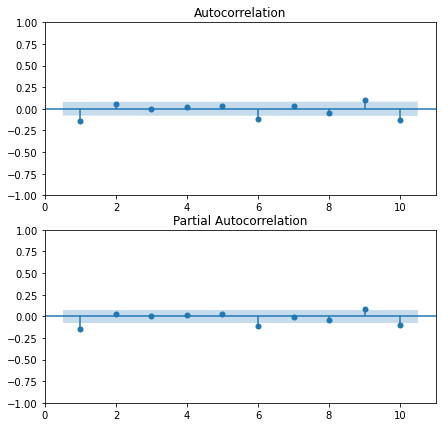

AR> 0 MA> 0 AIC> 3670.8633992920745 BIC> 3675.294730374008
AR> 0 MA> 1 AIC> 3657.0008997357704 BIC> 3665.8635618996373
AR> 0 MA> 2 AIC> 3657.7486699802066 BIC> 3671.042663226007
AR> 0 MA> 3 AIC> 3659.6651266017125 BIC> 3677.390450929446
AR> 1 MA> 0 AIC> 3655.9213418906 BIC> 3664.784004054467
AR> 1 MA> 1 AIC> 3657.6122259950325 BIC> 3670.906219240833
AR> 1 MA> 2 AIC> 3659.612204773937 BIC> 3677.337529101671
AR> 1 MA> 3 AIC> 3661.6016715606215 BIC> 3683.758326970289
AR> 2 MA> 0 AIC> 3657.62149280616 BIC> 3670.91548605196
AR> 2 MA> 1 AIC> 3659.615921209938 BIC> 3677.341245537672


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 3661.612220042971 BIC> 3683.7688754526384


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 2 MA> 3 AIC> 3656.2715266002583 BIC> 3682.8595130918593
AR> 3 MA> 0 AIC> 3659.6106944767753 BIC> 3677.336018804509
AR> 3 MA> 1 AIC> 3661.613669903622 BIC> 3683.7703253132895
AR> 3 MA> 2 AIC> 3663.6121568721446 BIC> 3690.2001433637456
AR> 3 MA> 3 AIC> 3659.272358536806 BIC> 3690.2916761103406
3 3 3659.272358536806 3690.2916761103406
ADF TEST > (-28.86286655464391, 0.0, 0, 621, {'1%': -3.440924132966757, '5%': -2.866205413627313, '10%': -2.5692545786625383}, 3499.2727802738314)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [170]:
orderplot('2020-03-04')

# 61 1,1,0

# 62 2020-03-09

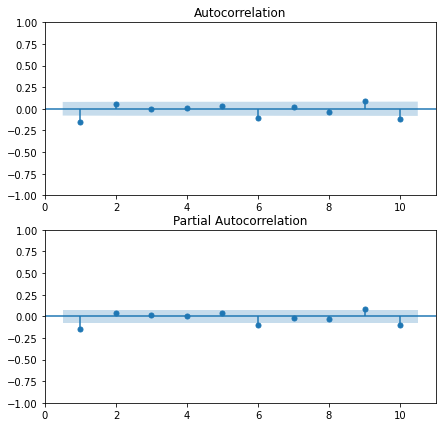

AR> 0 MA> 0 AIC> 3648.6824201511163 BIC> 3653.108908608574
AR> 0 MA> 1 AIC> 3634.846265955293 BIC> 3643.6992428702083
AR> 0 MA> 2 AIC> 3635.954673474742 BIC> 3649.234138847115
AR> 0 MA> 3 AIC> 3637.6898681551347 BIC> 3655.3958219849656
AR> 1 MA> 0 AIC> 3633.9442062022154 BIC> 3642.7971831171308
AR> 1 MA> 1 AIC> 3635.70318597839 BIC> 3648.9826513507633
AR> 1 MA> 2 AIC> 3637.661540833694 BIC> 3655.3674946635247
AR> 1 MA> 3 AIC> 3639.562508210124 BIC> 3661.6949504974127
AR> 2 MA> 0 AIC> 3635.7449860045053 BIC> 3649.0244513768785
AR> 2 MA> 1 AIC> 3637.191492166381 BIC> 3654.897445996212


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 3639.629112016177 BIC> 3661.7615543034653
AR> 2 MA> 3 AIC> 3631.853143648441 BIC> 3658.412074393187
AR> 3 MA> 0 AIC> 3637.5992399908914 BIC> 3655.3051938207223
AR> 3 MA> 1 AIC> 3639.5914870351653 BIC> 3661.723929322454


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 3 MA> 2 AIC> 3633.3455671709216 BIC> 3659.904497915668
AR> 3 MA> 3 AIC> 3625.1512810498743 BIC> 3656.1367002520783
3 3 3625.1512810498743 3656.1367002520783
ADF TEST > (-29.021467605491832, 0.0, 0, 618, {'1%': -3.440975679277454, '5%': -2.8662281164567927, '10%': -2.5692666752547626}, 3482.570775093206)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [171]:
orderplot('2020-03-09')

# 62 1,1,0

# 63 2020-03-09

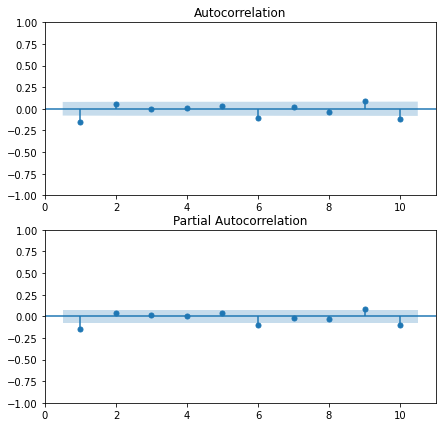

AR> 0 MA> 0 AIC> 3648.6824201511163 BIC> 3653.108908608574
AR> 0 MA> 1 AIC> 3634.846265955293 BIC> 3643.6992428702083
AR> 0 MA> 2 AIC> 3635.954673474742 BIC> 3649.234138847115
AR> 0 MA> 3 AIC> 3637.6898681551347 BIC> 3655.3958219849656
AR> 1 MA> 0 AIC> 3633.9442062022154 BIC> 3642.7971831171308
AR> 1 MA> 1 AIC> 3635.70318597839 BIC> 3648.9826513507633
AR> 1 MA> 2 AIC> 3637.661540833694 BIC> 3655.3674946635247
AR> 1 MA> 3 AIC> 3639.562508210124 BIC> 3661.6949504974127
AR> 2 MA> 0 AIC> 3635.7449860045053 BIC> 3649.0244513768785
AR> 2 MA> 1 AIC> 3637.191492166381 BIC> 3654.897445996212


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 3639.629112016177 BIC> 3661.7615543034653
AR> 2 MA> 3 AIC> 3631.853143648441 BIC> 3658.412074393187
AR> 3 MA> 0 AIC> 3637.5992399908914 BIC> 3655.3051938207223
AR> 3 MA> 1 AIC> 3639.5914870351653 BIC> 3661.723929322454


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 3 MA> 2 AIC> 3633.3455671709216 BIC> 3659.904497915668
AR> 3 MA> 3 AIC> 3625.1512810498743 BIC> 3656.1367002520783
3 3 3625.1512810498743 3656.1367002520783
ADF TEST > (-29.021467605491832, 0.0, 0, 618, {'1%': -3.440975679277454, '5%': -2.8662281164567927, '10%': -2.5692666752547626}, 3482.570775093206)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [172]:
orderplot('2020-03-09')

# 63 1,1,0

# 64 2020-03-11

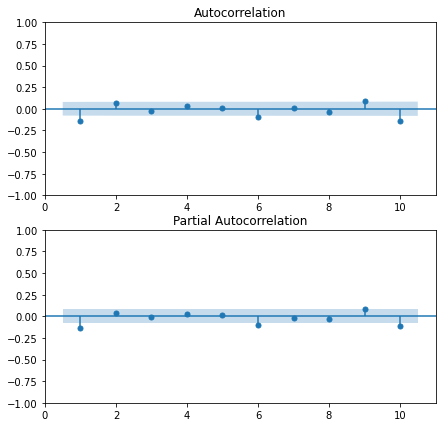

AR> 0 MA> 0 AIC> 3631.4121844096353 BIC> 3635.835431373169
AR> 0 MA> 1 AIC> 3617.264414244388 BIC> 3626.110908171455
AR> 0 MA> 2 AIC> 3617.49080791919 BIC> 3630.7605488097906
AR> 0 MA> 3 AIC> 3617.9075504563516 BIC> 3635.6005383104857
AR> 1 MA> 0 AIC> 3615.6573725523867 BIC> 3624.503866479454
AR> 1 MA> 1 AIC> 3615.5998280684817 BIC> 3628.8695689590822
AR> 1 MA> 2 AIC> 3617.531270208622 BIC> 3635.2242580627562
AR> 1 MA> 3 AIC> 3618.6242824980473 BIC> 3640.740517315715
AR> 2 MA> 0 AIC> 3616.483114666402 BIC> 3629.7528555570025
AR> 2 MA> 1 AIC> 3617.5459803944145 BIC> 3635.2389682485486


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 3618.6835466046987 BIC> 3640.7997814223663


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 2 MA> 3 AIC> 3611.2859719467187 BIC> 3637.82545372792
AR> 3 MA> 0 AIC> 3617.116391231543 BIC> 3634.809379085677
AR> 3 MA> 1 AIC> 3618.866484193031 BIC> 3640.9827190106985


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 3 MA> 2 AIC> 3614.13230170296 BIC> 3640.671783484161
AR> 3 MA> 3 AIC> 3604.5509964827515 BIC> 3635.5137252274862
3 3 3604.5509964827515 3635.5137252274862
ADF TEST > (-28.56754685050201, 0.0, 0, 616, {'1%': -3.4410103235939746, '5%': -2.866243374831338, '10%': -2.5692748053002195}, 3466.463856831028)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [173]:
orderplot('2020-03-11')

# 64 1,1,0

# 65 2020-03-11

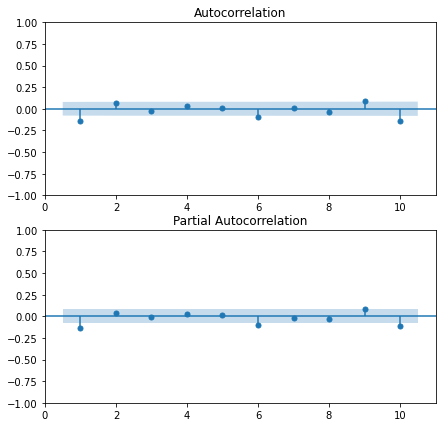

AR> 0 MA> 0 AIC> 3631.4121844096353 BIC> 3635.835431373169
AR> 0 MA> 1 AIC> 3617.264414244388 BIC> 3626.110908171455
AR> 0 MA> 2 AIC> 3617.49080791919 BIC> 3630.7605488097906
AR> 0 MA> 3 AIC> 3617.9075504563516 BIC> 3635.6005383104857
AR> 1 MA> 0 AIC> 3615.6573725523867 BIC> 3624.503866479454
AR> 1 MA> 1 AIC> 3615.5998280684817 BIC> 3628.8695689590822
AR> 1 MA> 2 AIC> 3617.531270208622 BIC> 3635.2242580627562
AR> 1 MA> 3 AIC> 3618.6242824980473 BIC> 3640.740517315715
AR> 2 MA> 0 AIC> 3616.483114666402 BIC> 3629.7528555570025
AR> 2 MA> 1 AIC> 3617.5459803944145 BIC> 3635.2389682485486


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 3618.6835466046987 BIC> 3640.7997814223663


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 2 MA> 3 AIC> 3611.2859719467187 BIC> 3637.82545372792
AR> 3 MA> 0 AIC> 3617.116391231543 BIC> 3634.809379085677
AR> 3 MA> 1 AIC> 3618.866484193031 BIC> 3640.9827190106985


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 3 MA> 2 AIC> 3614.13230170296 BIC> 3640.671783484161
AR> 3 MA> 3 AIC> 3604.5509964827515 BIC> 3635.5137252274862
3 3 3604.5509964827515 3635.5137252274862
ADF TEST > (-28.56754685050201, 0.0, 0, 616, {'1%': -3.4410103235939746, '5%': -2.866243374831338, '10%': -2.5692748053002195}, 3466.463856831028)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [174]:
orderplot('2020-03-11')

# 65 1,1,0

# 66 2020-03-12

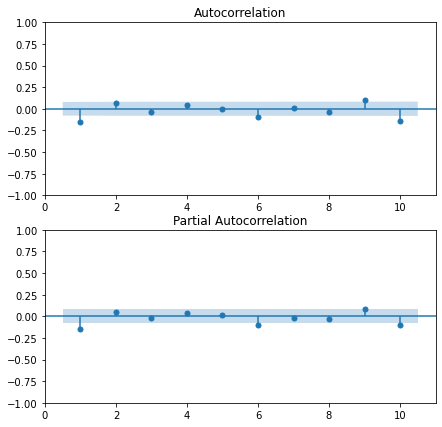

AR> 0 MA> 0 AIC> 3616.44038009875 BIC> 3620.8620023665567
AR> 0 MA> 1 AIC> 3605.2774648531413 BIC> 3614.120709388754
AR> 0 MA> 2 AIC> 3606.5403734548736 BIC> 3619.805240258293
AR> 0 MA> 3 AIC> 3607.531392633161 BIC> 3625.217881704387
AR> 1 MA> 0 AIC> 3604.47833548949 BIC> 3613.321580025103
AR> 1 MA> 1 AIC> 3605.6946481525742 BIC> 3618.9595149559937
AR> 1 MA> 2 AIC> 3607.517430958165 BIC> 3625.2039200293907
AR> 1 MA> 3 AIC> 3608.768134158379 BIC> 3630.8762454974117
AR> 2 MA> 0 AIC> 3606.088279334804 BIC> 3619.3531461382236
AR> 2 MA> 1 AIC> 3607.560356802812 BIC> 3625.2468458740377


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 3608.7917735698834 BIC> 3630.899884908916


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 2 MA> 3 AIC> 3604.015105126852 BIC> 3630.5448387336914
AR> 3 MA> 0 AIC> 3607.09748266304 BIC> 3624.783971734266
AR> 3 MA> 1 AIC> 3608.916891100613 BIC> 3631.025002439646


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 3 MA> 2 AIC> 3603.418347532364 BIC> 3629.948081139203
AR> 3 MA> 3 AIC> 3594.421802050356 BIC> 3625.3731579250016
3 3 3594.421802050356 3625.3731579250016
ADF TEST > (-28.98095712661458, 0.0, 0, 615, {'1%': -3.4410277306083668, '5%': -2.8662510413264357, '10%': -2.569278890210853}, 3461.56983656994)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [175]:
orderplot('2020-03-12')

# 66 1,1,0

# 67 2020-03-13

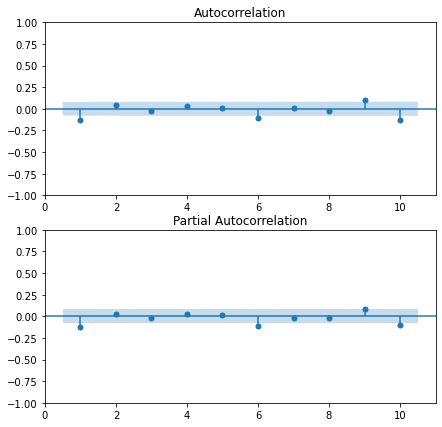

AR> 0 MA> 0 AIC> 3592.5925832939433 BIC> 3597.0125782220903
AR> 0 MA> 1 AIC> 3586.3189706209296 BIC> 3595.158960477224
AR> 0 MA> 2 AIC> 3588.0822777946005 BIC> 3601.3422625790417
AR> 0 MA> 3 AIC> 3589.419750588179 BIC> 3607.0997303007675
AR> 1 MA> 0 AIC> 3586.0348364553292 BIC> 3594.8748263116236
AR> 1 MA> 1 AIC> 3587.76300168598 BIC> 3601.022986470421
AR> 1 MA> 2 AIC> 3589.5955164011157 BIC> 3607.2754961137043
AR> 1 MA> 3 AIC> 3590.9913299025657 BIC> 3613.0913045433012
AR> 2 MA> 0 AIC> 3587.920983708704 BIC> 3601.1809684931454
AR> 2 MA> 1 AIC> 3589.6370146353543 BIC> 3607.316994347943


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 3590.644098016908 BIC> 3612.7440726576438


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 2 MA> 3 AIC> 3586.1426279862117 BIC> 3612.6625975550946
AR> 3 MA> 0 AIC> 3589.215712136083 BIC> 3606.8956918486715
AR> 3 MA> 1 AIC> 3591.075098522714 BIC> 3613.1750731634497


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 3 MA> 2 AIC> 3586.050190414284 BIC> 3612.570159983167
AR> 3 MA> 3 AIC> 3577.403400405916 BIC> 3608.3433649029457
3 3 3577.403400405916 3608.3433649029457
ADF TEST > (-28.578137779270232, 0.0, 0, 614, {'1%': -3.4410451945636207, '5%': -2.8662587328558566, '10%': -2.569282988466721}, 3456.7672609038127)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [176]:
orderplot('2020-03-13')

# 67 1,1,0

# 68 2020-03-16

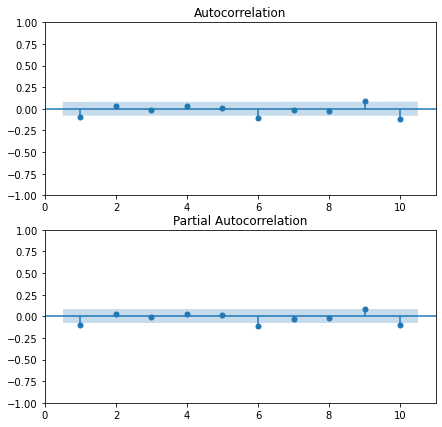

AR> 0 MA> 0 AIC> 3560.163220829392 BIC> 3564.581585765328
AR> 0 MA> 1 AIC> 3556.2091214138127 BIC> 3565.0458512856853
AR> 0 MA> 2 AIC> 3558.1676973040276 BIC> 3571.4227921118363
AR> 0 MA> 3 AIC> 3559.6045721652863 BIC> 3577.278031909031
AR> 1 MA> 0 AIC> 3556.13418276879 BIC> 3564.970912640663
AR> 1 MA> 1 AIC> 3558.1009903614604 BIC> 3571.356085169269
AR> 1 MA> 2 AIC> 3559.9325262103566 BIC> 3577.6059859541015
AR> 1 MA> 3 AIC> 3561.402389668093 BIC> 3583.494214347774
AR> 2 MA> 0 AIC> 3558.1229319452823 BIC> 3571.378026753091
AR> 2 MA> 1 AIC> 3560.1294131980717 BIC> 3577.8028729418165


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 3561.3813927234123 BIC> 3583.4732174030933
AR> 2 MA> 3 AIC> 3557.3830841870513 BIC> 3583.893273802669
AR> 3 MA> 0 AIC> 3559.519096022369 BIC> 3577.192555766114
AR> 3 MA> 1 AIC> 3561.4413015269856 BIC> 3583.5331262066666


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 3 MA> 2 AIC> 3557.4529643995875 BIC> 3583.963154015205
AR> 3 MA> 3 AIC> 3564.934200735165 BIC> 3595.8627552867188
3 3 3564.934200735165 3595.8627552867188
ADF TEST > (-27.84977467865941, 0.0, 0, 613, {'1%': -3.4410627157395908, '5%': -2.8662664495424255, '10%': -2.5692871001333266}, 3451.963449117938)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [177]:
orderplot('2020-03-16')

# 68 1,1,0

# 69 2020-03-17 <<<< SKIPPED >>>>

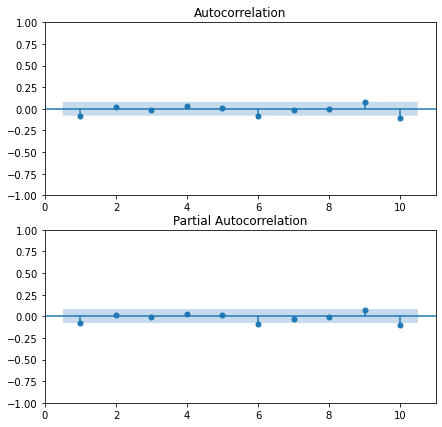

AR> 0 MA> 0 AIC> 3548.9350583705154 BIC> 3553.351790653028
AR> 0 MA> 1 AIC> 3545.581447598938 BIC> 3554.414912163963
AR> 0 MA> 2 AIC> 3547.5525277997904 BIC> 3560.8027246473275
AR> 0 MA> 3 AIC> 3549.162393126506 BIC> 3566.829322256555
AR> 1 MA> 0 AIC> 3545.5299060451343 BIC> 3554.363370610159
AR> 1 MA> 1 AIC> 3547.5183950340015 BIC> 3560.7685918815387
AR> 1 MA> 2 AIC> 3549.3601879314 BIC> 3567.027117061449
AR> 1 MA> 3 AIC> 3550.9697672754783 BIC> 3573.0534286880397
AR> 2 MA> 0 AIC> 3547.525310740262 BIC> 3560.775507587799
AR> 2 MA> 1 AIC> 3549.528490264623 BIC> 3567.195419394672


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 3550.6179442178786 BIC> 3572.70160563044
AR> 2 MA> 3 AIC> 3546.6978023274896 BIC> 3573.1981960225635
AR> 3 MA> 0 AIC> 3549.0819353012785 BIC> 3566.7488644313275
AR> 3 MA> 1 AIC> 3550.9816511631516 BIC> 3573.065312575713


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 3 MA> 2 AIC> 3546.9937900517325 BIC> 3573.4941837468064
AR> 3 MA> 3 AIC> 3540.1507979940375 BIC> 3571.0679239716237
3 3 3540.1507979940375 3571.0679239716237
ADF TEST > (-26.89404618520061, 0.0, 0, 612, {'1%': -3.4410802944179686, '5%': -2.8662741915097736, '10%': -2.569291225276603}, 3447.15617170778)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [178]:
orderplot('2020-03-17')

# 70 2020-03-18

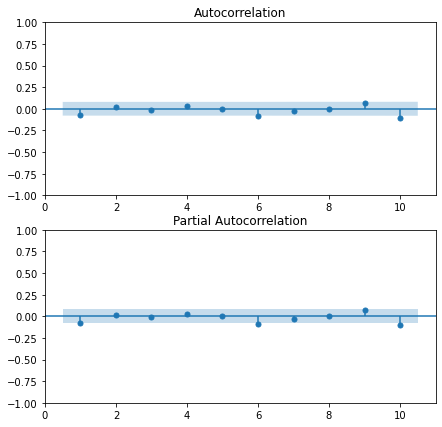

AR> 0 MA> 0 AIC> 3542.1615258844604 BIC> 3546.576622843632
AR> 0 MA> 1 AIC> 3538.906817363154 BIC> 3547.7370112814974
AR> 0 MA> 2 AIC> 3540.896201522033 BIC> 3554.141492399548
AR> 0 MA> 3 AIC> 3542.5280273978847 BIC> 3560.188415234571
AR> 1 MA> 0 AIC> 3538.8849589902375 BIC> 3547.715152908581
AR> 1 MA> 1 AIC> 3540.8849431765284 BIC> 3554.1302340540433
AR> 1 MA> 2 AIC> 3542.7028532156082 BIC> 3560.3632410522946
AR> 1 MA> 3 AIC> 3544.2564261107245 BIC> 3566.3319109065824
AR> 2 MA> 0 AIC> 3540.88495074304 BIC> 3554.130241620555
AR> 2 MA> 1 AIC> 3542.884182347877 BIC> 3560.5445701845633


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 3544.1426917289664 BIC> 3566.2181765248242


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 2 MA> 3 AIC> 3539.4712792746514 BIC> 3565.961861029681
AR> 3 MA> 0 AIC> 3542.408719523378 BIC> 3560.069107360064
AR> 3 MA> 1 AIC> 3544.241665469034 BIC> 3566.317150264892


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 3 MA> 2 AIC> 3539.7562223518908 BIC> 3566.2468041069205
AR> 3 MA> 3 AIC> 3531.646583955269 BIC> 3562.55226266947
3 3 3531.646583955269 3562.55226266947
ADF TEST > (-26.65304854123389, 0.0, 0, 611, {'1%': -3.4410979308822967, '5%': -2.8662819588823423, '10%': -2.5692953639629166}, 3439.0376904994314)


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(None, None, None)

In [179]:
orderplot('2020-03-18')

In [180]:
all_dates.iloc[75]

Timestamp('2020-03-30 00:00:00')

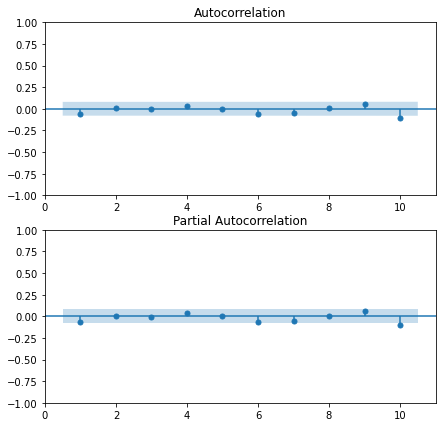

AR> 0 MA> 0 AIC> 3481.4191880798635 BIC> 3485.8211052765905
AR> 0 MA> 1 AIC> 3479.6878113333346 BIC> 3488.491645726789
AR> 0 MA> 2 AIC> 3481.6760108690096 BIC> 3494.881762459191
AR> 0 MA> 3 AIC> 3483.322987924016 BIC> 3500.9306567109247
AR> 1 MA> 0 AIC> 3479.7314662773824 BIC> 3488.535300670837
AR> 1 MA> 1 AIC> 3481.6654621431917 BIC> 3494.871213733373
AR> 1 MA> 2 AIC> 3483.539954301169 BIC> 3501.1476230880776
AR> 1 MA> 3 AIC> 3484.7255712128062 BIC> 3506.7351571964423
AR> 2 MA> 0 AIC> 3481.702490192491 BIC> 3494.9082417826726
AR> 2 MA> 1 AIC> 3482.788733540711 BIC> 3500.3964023276194


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR> 2 MA> 2 AIC> 3484.479901105885 BIC> 3506.489487089521


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 2 MA> 3 AIC> 3469.341602562371 BIC> 3495.753105742734
AR> 3 MA> 0 AIC> 3483.2251738847317 BIC> 3500.8328426716403
AR> 3 MA> 1 AIC> 3484.926496766502 BIC> 3506.936082750138


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 3 MA> 2 AIC> 3475.5901270009804 BIC> 3502.0016301813434
AR> 3 MA> 3 AIC> 3472.745849640437 BIC> 3503.559270017527
3 3 3472.745849640437 3503.559270017527
ADF TEST > (-26.17123791552631, 0.0, 0, 603, {'1%': -3.441241137539733, '5%': -2.8663450276569797, '10%': -2.569328969112426}, 3393.47815381299)


(None, None, None)

In [181]:
orderplot('2020-03-30')

In [182]:
all_dates.iloc[130]

Timestamp('2022-03-09 00:00:00')

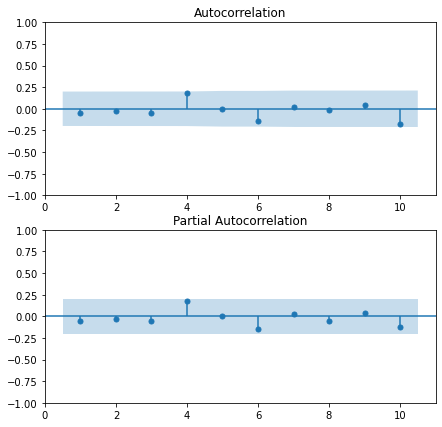

AR> 0 MA> 0 AIC> 612.6922344402374 BIC> 615.2565826317052
AR> 0 MA> 1 AIC> 614.2361574852705 BIC> 619.3648538682062
AR> 0 MA> 2 AIC> 616.2310765260052 BIC> 623.9241211004087
AR> 0 MA> 3 AIC> 618.0147350438108 BIC> 628.2721278096822
AR> 1 MA> 0 AIC> 614.2432699682544 BIC> 619.37196635119
AR> 1 MA> 1 AIC> 616.2264292804055 BIC> 623.919473854809
AR> 1 MA> 2 AIC> 618.0567595589389 BIC> 628.3141523248103
AR> 1 MA> 3 AIC> 619.2950599944194 BIC> 632.1168009517586
AR> 2 MA> 0 AIC> 616.2387081107136 BIC> 623.9317526851171
AR> 2 MA> 1 AIC> 618.2258302168063 BIC> 628.4832229826777
AR> 2 MA> 2 AIC> 617.2320246081262 BIC> 630.0537655654654


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 2 MA> 3 AIC> 615.5463502820935 BIC> 630.9324394309006
AR> 3 MA> 0 AIC> 617.9289787944787 BIC> 628.18637156035
AR> 3 MA> 1 AIC> 619.4003721055603 BIC> 632.2221130628996


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR> 3 MA> 2 AIC> 615.2441942035894 BIC> 630.6302833523964
AR> 3 MA> 3 AIC> 617.6325981341499 BIC> 635.5830354744248
3 3 617.6325981341499 635.5830354744248
ADF TEST > (-10.428870878962307, 1.6304179961598493e-18, 0, 96, {'1%': -3.5003788874873405, '5%': -2.8921519665075235, '10%': -2.5830997960069446}, 542.5031713203996)


(None, None, None)

In [183]:
orderplot('2022-03-09')

### Residuals of models and average prediction

####  RMSE =$\sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$

##### forward_model = SARIMAX(df.loc['2017-05-17':]['Msft Close'], order=(1,1,0), exog=df.loc['2017-05-17':]['dj shifted'], 
                       trend='c')

###### result_forward_model = forward_model.fit()

#### forecast_result_forward_model = result_forward_model.get_forecast(steps=1)

#### mean_forecast_result_forward_model = forecast_result_forward_model.predicted_mean

##### mean_forecast_result_forward_model

### result=seasonal_decompose(df['Msft Close'], model='multiplicable', period=12)

In [184]:
df.index[-1] - df.index[0]

Timedelta('2024 days 00:00:00')

In [185]:
ts_dicomposition = seasonal_decompose(df['Msft Close'], model='additive', period=366)
trend_estimate = ts_dicomposition.trend
seasonal_estimate = ts_dicomposition.seasonal
residual_estimate = ts_dicomposition.resid

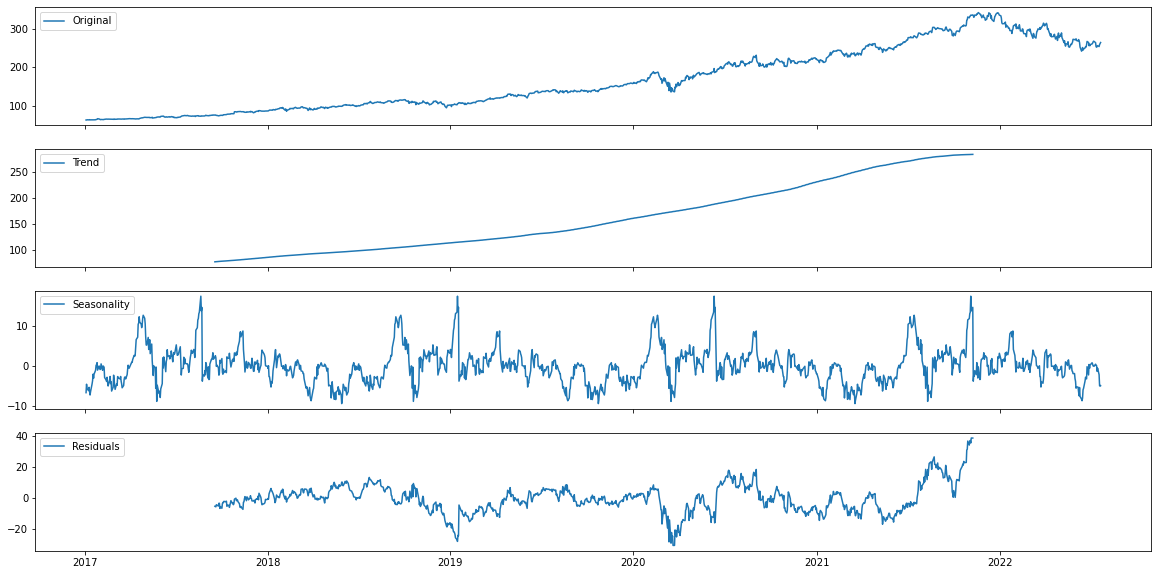

In [186]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(20)
# First plot to the Original time series
axes[0].plot(df['Msft Close'], label='Original') 
axes[0].legend(loc='upper left');
# second plot to be for trend
axes[1].plot(trend_estimate, label='Trend')
axes[1].legend(loc='upper left');
# third plot to be Seasonality component
axes[2].plot(seasonal_estimate, label='Seasonality')
axes[2].legend(loc='upper left');
# last last plot to be Residual component
axes[3].plot(residual_estimate, label='Residuals')
axes[3].legend(loc='upper left'); plt.show()

In [187]:
### 2017-01-04

In [188]:
'''
model = SARIMAX(df['2017-01-04':]['Msft Close'], order = (1, 1, 0), trend='c')
result = model.fit()
forecast = result.get_prediction(start=-20)
prediction = forecast.predicted_mean '''

"\nmodel = SARIMAX(df['2017-01-04':]['Msft Close'], order = (1, 1, 0), trend='c')\nresult = model.fit()\nforecast = result.get_prediction(start=-20)\nprediction = forecast.predicted_mean "

In [189]:
model_future = SARIMAX(df['2017-01-04':]['Msft Close'], order = (1, 1, 0), trend='c')

In [190]:
result_future = model_future.fit()

In [191]:
forecast_result_future = result_future.get_forecast(steps = 20)

In [192]:
values_forecast_result_future = result_future.forecast(steps = 20)

In [193]:
print(values_forecast_result_future)
print(values_forecast_result_future.shape)

2022-07-22    264.589432
2022-07-25    264.792040
2022-07-26    264.921838
2022-07-27    265.063335
2022-07-28    265.202951
2022-07-29    265.342870
2022-08-01    265.482741
2022-08-02    265.622619
2022-08-03    265.762496
2022-08-04    265.902373
2022-08-05    266.042250
2022-08-08    266.182127
2022-08-09    266.322004
2022-08-10    266.461881
2022-08-11    266.601758
2022-08-12    266.741635
2022-08-15    266.881512
2022-08-16    267.021389
2022-08-17    267.161266
2022-08-18    267.301143
Freq: B, Name: predicted_mean, dtype: float64
(20,)


In [194]:
msft_predict_20 = msft_predict.loc['2022-07-22':'2022-08-18']['Close']
msft_predict_20.head()

Date
2022-07-22    260.359985
2022-07-25    258.829987
2022-07-26    251.899994
2022-07-27    268.739990
2022-07-28    276.410004
Name: Close, dtype: float64

In [195]:
msft_predict_20

Date
2022-07-22    260.359985
2022-07-25    258.829987
2022-07-26    251.899994
2022-07-27    268.739990
2022-07-28    276.410004
2022-07-29    280.739990
2022-08-01    278.010010
2022-08-02    274.820007
2022-08-03    282.470001
2022-08-04    283.649994
2022-08-05    282.910004
2022-08-08    280.320007
2022-08-09    282.299988
2022-08-10    289.160004
2022-08-11    287.019989
2022-08-12    291.910004
2022-08-15    293.470001
2022-08-16    292.709991
2022-08-17    291.320007
2022-08-18    290.170013
Name: Close, dtype: float64

In [196]:
msft_predict_21 = msft_predict.loc['2022-07-22':'2022-08-19']['Close']
msft_predict_21

Date
2022-07-22    260.359985
2022-07-25    258.829987
2022-07-26    251.899994
2022-07-27    268.739990
2022-07-28    276.410004
2022-07-29    280.739990
2022-08-01    278.010010
2022-08-02    274.820007
2022-08-03    282.470001
2022-08-04    283.649994
2022-08-05    282.910004
2022-08-08    280.320007
2022-08-09    282.299988
2022-08-10    289.160004
2022-08-11    287.019989
2022-08-12    291.910004
2022-08-15    293.470001
2022-08-16    292.709991
2022-08-17    291.320007
2022-08-18    290.170013
2022-08-19    286.149994
Name: Close, dtype: float64

In [197]:
msft_predict_20.isnull().sum()

0

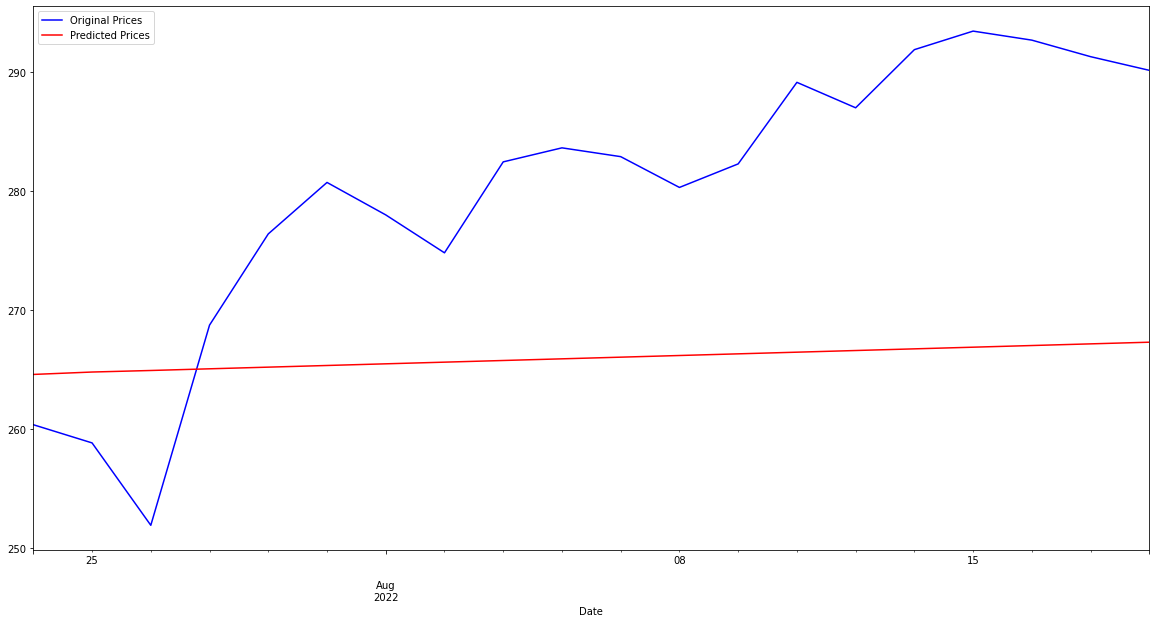

In [198]:
fig, ax = plt.subplots(figsize=(20,10))
msft_predict_20.plot(color='b', ax=ax, label = 'Original Prices')
values_forecast_result_future.plot(color='r', ax=ax, label='Predicted Prices')
plt.legend()
plt.show()

In [199]:
def forval(dd):
    modelfct = SARIMAX(df[dd:]['Msft Close'], order = (1, 1, 0), trend='c')
    resultfct = modelfct.fit()
    forecastfct = resultfct.forecast(steps = 20)
    return forecastfct

In [200]:
results_daily_auto = pm.auto_arima(df['2020-03-16':]['Msft Close'],
                         start_p=0,  # initial guess for AR(p)
                         start_d=0,  # initial guess for I(d)
                         start_q=0,  # initial guess for MA(q)
                         max_p=4,    # max guess for AR(p)
                         max_d=4,    # max guess for I(d)
                         max_q=4,    # max guess for MA(q)
                         trend='c',
                         information_criterion='aic',
                         trace=True,
                         error_action='ignore'
                         )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3560.755, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3556.444, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3556.490, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3560.755, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3558.442, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3558.438, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3560.444, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3556.444, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.785 seconds


In [201]:
modelfcrt = SARIMAX(df['2020-03-16':]['Msft Close'], order = (1, 1, 0), trend='c')

In [202]:
resultfctt = modelfcrt.fit()

In [203]:
forecastfct = resultfctt.forecast(steps = 20)

Figure(720x864)


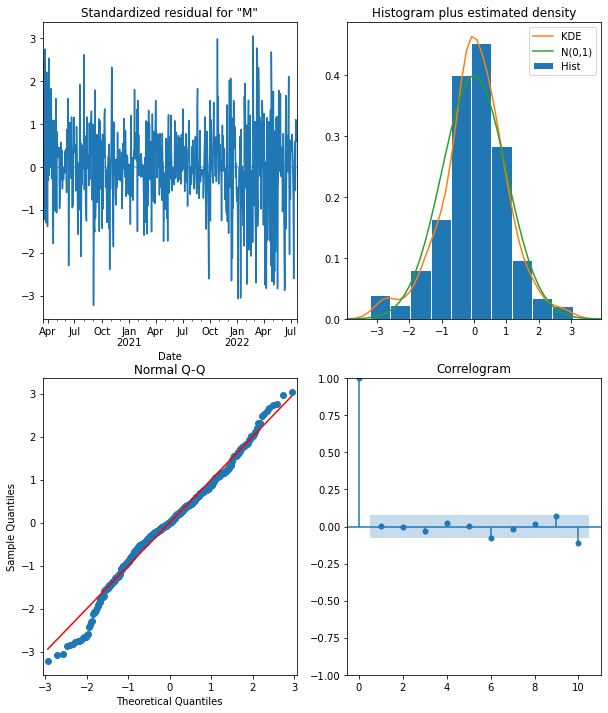

In [204]:
diag_resultfct = resultfctt.plot_diagnostics(figsize = (10,12))
print(diag_resultfct)

In [205]:
ppred_1 = forval('2017-01-04')
ppred_2 = forval('2017-05-17')
ppred_3 = forval('2017-10-27')
ppred_4 = forval('2017-12-15')
ppred_5 = forval('2018-02-05')
ppred_6 = forval('2018-02-06')
ppred_7 = forval('2018-02-08')
ppred_8 = forval('2018-02-09')
ppred_9 = forval('2018-02-23')
ppred_10 = forval('2018-03-23')
ppred_11 = forval('2018-03-26')
ppred_12 = forval('2018-03-27')
ppred_13 = forval('2018-04-04')
ppred_14 = forval('2018-07-25')
ppred_15 = forval('2018-09-05')
ppred_16 = forval('2018-10-10')
ppred_17 = forval('2018-10-12')
ppred_18 = forval('2018-10-16')
ppred_19 = forval('2018-10-24')
ppred_20 = forval('2018-10-25')
ppred_21 = forval('2018-10-29')
ppred_22 = forval('2018-10-31')
ppred_23 = forval('2018-11-07')
ppred_24 = forval('2018-11-19')
ppred_25 = forval('2018-11-20')
ppred_26 = forval('2018-11-26')
ppred_27 = forval('2018-11-28')
ppred_28 = forval('2018-12-04')
ppred_29 = forval('2018-12-07')
ppred_30 = forval('2018-12-10')
ppred_31 = forval('2018-12-14')
ppred_32 = forval('2018-12-17')
ppred_33 = forval('2018-12-21')
ppred_34 = forval('2018-12-24')
ppred_35 = forval('2018-12-25')
ppred_36 = forval('2018-12-26')
ppred_37 = forval('2019-01-03')
ppred_38 = forval('2019-01-04')
ppred_39 = forval('2019-01-15')
ppred_40 = forval('2019-01-30')
ppred_41 = forval('2019-02-04')
ppred_42 = forval('2019-04-25')
ppred_43 = forval('2019-05-13')
ppred_44 = forval('2019-06-03')
ppred_45 = forval('2019-06-04')
ppred_46 = forval('2019-06-07')
ppred_47 = forval('2019-06-25')
ppred_48 = forval('2019-07-31')
ppred_49 = forval('2019-08-05')
ppred_50 = forval('2019-08-08')
ppred_51 = forval('2019-08-14')
ppred_52 = forval('2019-08-23')
ppred_53 = forval('2020-01-30')
ppred_54 = forval('2020-02-04')
ppred_55 = forval('2020-02-10')
ppred_56 = forval('2020-02-21')
ppred_57 = forval('2020-02-24')
ppred_58 = forval('2020-02-27')
ppred_59 = forval('2020-03-02')
ppred_60 = forval('2020-03-03')
ppred_61 = forval('2020-03-04')
ppred_62 = forval('2020-03-09')
ppred_63 = forval('2020-03-11')
ppred_64 = forval('2020-03-12')
ppred_65 = forval('2020-03-13')
ppred_66 = forval('2020-03-16')



In [206]:
mean_of_forecasts = (ppred_1+ppred_2+ppred_3+ppred_4+ppred_5+ppred_6+ppred_7+ppred_8+ppred_9+ppred_10+ppred_11+ppred_12+ppred_13+
ppred_14+ppred_15+
ppred_16+ppred_17+ppred_18+
ppred_19+ppred_20+
ppred_21+
ppred_22+
ppred_23+
ppred_24+
ppred_25+
ppred_26+
ppred_27+
ppred_28+
ppred_29+
ppred_30+
ppred_31+
ppred_32+
ppred_33+
ppred_34+
ppred_35+
ppred_36+
ppred_37+
ppred_38+
ppred_39+
ppred_40+
ppred_41+
ppred_42+
ppred_43+
ppred_44+
ppred_45+
ppred_46+
ppred_47+
ppred_48+
ppred_49+
ppred_50+
ppred_51+
ppred_52+
ppred_53+
ppred_54+
ppred_55+
ppred_56+
ppred_57+
ppred_58+
ppred_59+
ppred_60+
ppred_61+
ppred_62+
ppred_63+
ppred_64+
ppred_65+
ppred_66)/66

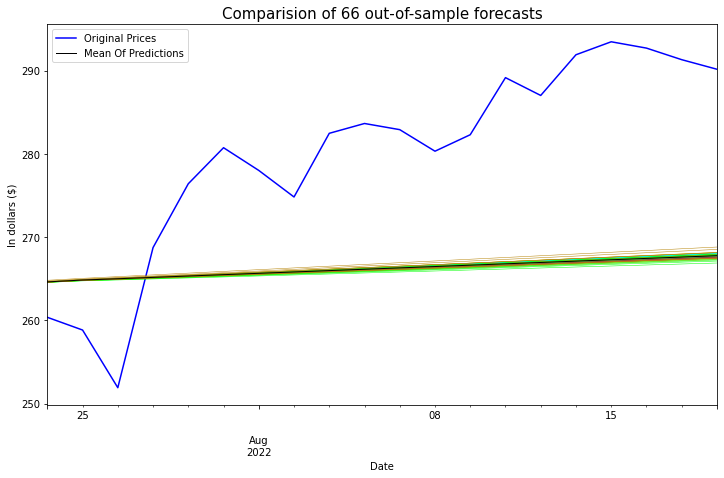

In [207]:
fig, ax = plt.subplots(figsize = (12,7))
msft_predict_20.plot(color='b', ax=ax, label = 'Original Prices')
ppred_1.plot(ax=ax, color='orange', label='_nolegend_', linewidth=0.5)
ppred_2.plot(ax=ax, color='orange', label='_nolegend_', linewidth=0.5)
ppred_3.plot(ax=ax, color='orange', label='_nolegend_', linewidth=0.5)
ppred_4.plot(ax=ax, color='orange', label='_nolegend_', linewidth=0.5)
ppred_5.plot(ax=ax, color='orange', label='_nolegend_', linewidth=0.5)
ppred_6.plot(ax=ax, color='orange', label='_nolegend_', linewidth=0.5)
ppred_7.plot(ax=ax, color='orange', label='_nolegend_', linewidth=0.5)
ppred_8.plot(ax=ax, color='orange', label='_nolegend_', linewidth=0.5)
ppred_9.plot(ax=ax, color='orange', label='_nolegend_', linewidth=0.5)
ppred_10.plot(ax=ax, color='orange', label='_nolegend_', linewidth=0.5)
ppred_11.plot(ax=ax, color='purple', label='_nolegend_', linewidth=0.5)
ppred_12.plot(ax=ax, color='purple', label='_nolegend_', linewidth=0.5)
ppred_13.plot(ax=ax, color='purple', label='_nolegend_', linewidth=0.5)
ppred_14.plot(ax=ax, color='purple', label='_nolegend_', linewidth=0.5)
ppred_15.plot(ax=ax, color='purple', label='_nolegend_', linewidth=0.5)
ppred_16.plot(ax=ax, color='purple', label='_nolegend_', linewidth=0.5)
ppred_17.plot(ax=ax, color='purple', label='_nolegend_', linewidth=0.5)
ppred_18.plot(ax=ax, color='purple', label='_nolegend_', linewidth=0.5)
ppred_19.plot(ax=ax, color='green', label='_nolegend_', linewidth=0.5)
ppred_20.plot(ax=ax, color='green', label='_nolegend_', linewidth=0.5)
ppred_21.plot(ax=ax, color='green', label='_nolegend_', linewidth=0.5)
ppred_22.plot(ax=ax, color='green', label='_nolegend_', linewidth=0.5)
ppred_23.plot(ax=ax, color='green', label='_nolegend_', linewidth=0.5)
ppred_24.plot(ax=ax, color='green', label='_nolegend_', linewidth=0.5)
ppred_25.plot(ax=ax, color='green', label='_nolegend_', linewidth=0.5)
ppred_26.plot(ax=ax, color='green', label='_nolegend_', linewidth=0.5)
ppred_27.plot(ax=ax, color='yellow', label='_nolegend_', linewidth=0.5)
ppred_28.plot(ax=ax, color='yellow', label='_nolegend_', linewidth=0.5)
ppred_29.plot(ax=ax, color='yellow', label='_nolegend_', linewidth=0.5)
ppred_30.plot(ax=ax, color='yellow', label='_nolegend_', linewidth=0.5)
ppred_31.plot(ax=ax, color='yellow', label='_nolegend_', linewidth=0.5)
ppred_32.plot(ax=ax, color='yellow', label='_nolegend_', linewidth=0.5)
ppred_33.plot(ax=ax, color='yellow', label='_nolegend_', linewidth=0.5)
ppred_34.plot(ax=ax, color='yellow', label='_nolegend_', linewidth=0.5)
ppred_35.plot(ax=ax, color='yellow', label='_nolegend_', linewidth=0.5)
ppred_36.plot(ax=ax, color='yellow', label='_nolegend_', linewidth=0.5)
ppred_37.plot(ax=ax, color='cyan', label='_nolegend_', linewidth=0.5)
ppred_38.plot(ax=ax, color='cyan', label='_nolegend_', linewidth=0.5)
ppred_39.plot(ax=ax, color='cyan', label='_nolegend_', linewidth=0.5)
ppred_40.plot(ax=ax, color='cyan', label='_nolegend_', linewidth=0.5)
ppred_41.plot(ax=ax, color='cyan', label='_nolegend_', linewidth=0.5)
ppred_42.plot(ax=ax, color='cyan', label='_nolegend_', linewidth=0.5)
ppred_43.plot(ax=ax, color='cyan', label='_nolegend_', linewidth=0.5)
ppred_44.plot(ax=ax, color='cyan', label='_nolegend_', linewidth=0.5)
ppred_45.plot(ax=ax, color='cyan', label='_nolegend_', linewidth=0.5)
ppred_46.plot(ax=ax, color='cyan', label='_nolegend_', linewidth=0.5)
ppred_47.plot(ax=ax, color='lime', label='_nolegend_', linewidth=0.5)
ppred_48.plot(ax=ax, color='lime', label='_nolegend_', linewidth=0.5)
ppred_49.plot(ax=ax, color='lime', label='_nolegend_', linewidth=0.5)
ppred_50.plot(ax=ax, color='lime', label='_nolegend_', linewidth=0.5)
ppred_51.plot(ax=ax, color='lime', label='_nolegend_', linewidth=0.5)
ppred_52.plot(ax=ax, color='lime', label='_nolegend_', linewidth=0.5)
ppred_53.plot(ax=ax, color='lime', label='_nolegend_', linewidth=0.5)
ppred_54.plot(ax=ax, color='lime', label='_nolegend_', linewidth=0.5)
ppred_55.plot(ax=ax, color='lime', label='_nolegend_', linewidth=0.5)
ppred_56.plot(ax=ax, color='lime', label='_nolegend_', linewidth=0.5)
ppred_57.plot(ax=ax, color='darkgoldenrod', label='_nolegend_', linewidth=0.5)
ppred_58.plot(ax=ax, color='darkgoldenrod', label='_nolegend_', linewidth=0.5)
ppred_59.plot(ax=ax, color='darkgoldenrod', label='_nolegend_', linewidth=0.5)
ppred_60.plot(ax=ax, color='darkgoldenrod', label='_nolegend_', linewidth=0.5)
ppred_61.plot(ax=ax, color='darkgoldenrod', label='_nolegend_', linewidth=0.5)
ppred_62.plot(ax=ax, color='darkgoldenrod', label='_nolegend_', linewidth=0.5)
ppred_63.plot(ax=ax, color='darkgoldenrod', label='_nolegend_', linewidth=0.5)
ppred_64.plot(ax=ax, color='darkgoldenrod', label='_nolegend_', linewidth=0.5)
ppred_65.plot(ax=ax, color='darkgoldenrod', label='_nolegend_', linewidth=0.5)
ppred_66.plot(ax=ax, color='darkgoldenrod', label='_nolegend_', linewidth=0.5)
mean_of_forecasts.plot(ax=ax, color='black', linewidth=1,label='Mean Of Predictions')
plt.legend()
plt.title('Comparision of 66 out-of-sample forecasts',fontsize = 15)
plt.ylabel('In dollars ($)')
plt.show()

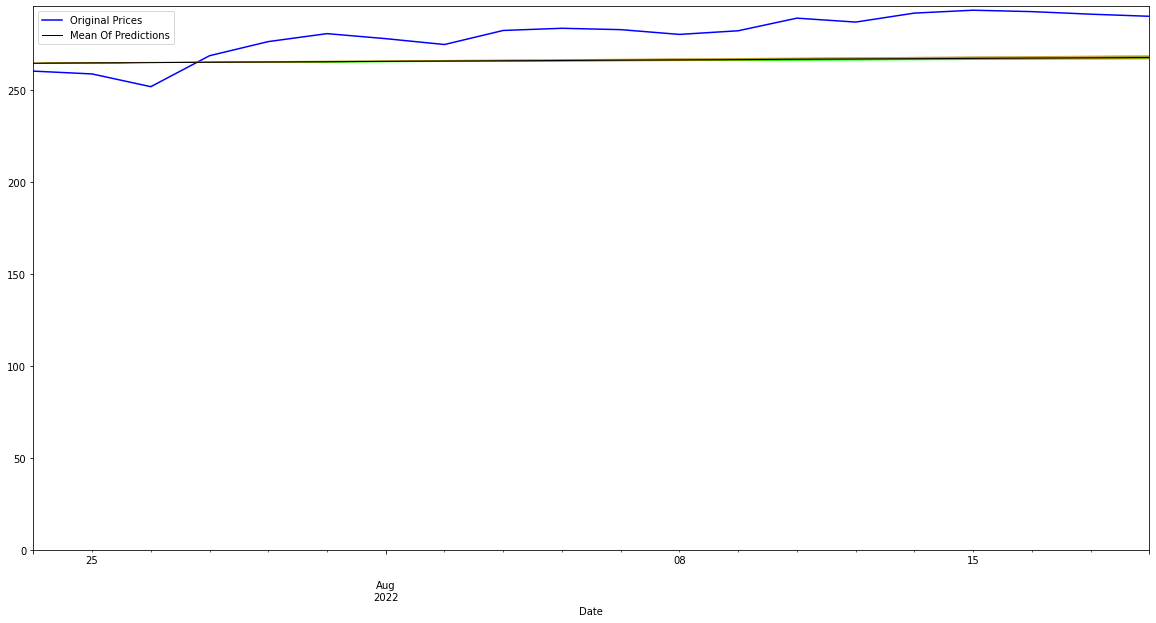

In [208]:
fig, ax = plt.subplots(figsize = (20,10))
msft_predict_20.plot(color='b', ax=ax, label = 'Original Prices')
ppred_1.plot(ax=ax, color='orange', label='_nolegend_', linewidth=0.5)
ppred_2.plot(ax=ax, color='orange', label='_nolegend_', linewidth=0.5)
ppred_3.plot(ax=ax, color='orange', label='_nolegend_', linewidth=0.5)
ppred_4.plot(ax=ax, color='orange', label='_nolegend_', linewidth=0.5)
ppred_5.plot(ax=ax, color='orange', label='_nolegend_', linewidth=0.5)
ppred_6.plot(ax=ax, color='orange', label='_nolegend_', linewidth=0.5)
ppred_7.plot(ax=ax, color='orange', label='_nolegend_', linewidth=0.5)
ppred_8.plot(ax=ax, color='orange', label='_nolegend_', linewidth=0.5)
ppred_9.plot(ax=ax, color='orange', label='_nolegend_', linewidth=0.5)
ppred_10.plot(ax=ax, color='orange', label='_nolegend_', linewidth=0.5)
ppred_11.plot(ax=ax, color='purple', label='_nolegend_', linewidth=0.5)
ppred_12.plot(ax=ax, color='purple', label='_nolegend_', linewidth=0.5)
ppred_13.plot(ax=ax, color='purple', label='_nolegend_', linewidth=0.5)
ppred_14.plot(ax=ax, color='purple', label='_nolegend_', linewidth=0.5)
ppred_15.plot(ax=ax, color='purple', label='_nolegend_', linewidth=0.5)
ppred_16.plot(ax=ax, color='purple', label='_nolegend_', linewidth=0.5)
ppred_17.plot(ax=ax, color='purple', label='_nolegend_', linewidth=0.5)
ppred_18.plot(ax=ax, color='purple', label='_nolegend_', linewidth=0.5)
ppred_19.plot(ax=ax, color='green', label='_nolegend_', linewidth=0.5)
ppred_20.plot(ax=ax, color='green', label='_nolegend_', linewidth=0.5)
ppred_21.plot(ax=ax, color='green', label='_nolegend_', linewidth=0.5)
ppred_22.plot(ax=ax, color='green', label='_nolegend_', linewidth=0.5)
ppred_23.plot(ax=ax, color='green', label='_nolegend_', linewidth=0.5)
ppred_24.plot(ax=ax, color='green', label='_nolegend_', linewidth=0.5)
ppred_25.plot(ax=ax, color='green', label='_nolegend_', linewidth=0.5)
ppred_26.plot(ax=ax, color='green', label='_nolegend_', linewidth=0.5)
ppred_27.plot(ax=ax, color='yellow', label='_nolegend_', linewidth=0.5)
ppred_28.plot(ax=ax, color='yellow', label='_nolegend_', linewidth=0.5)
ppred_29.plot(ax=ax, color='yellow', label='_nolegend_', linewidth=0.5)
ppred_30.plot(ax=ax, color='yellow', label='_nolegend_', linewidth=0.5)
ppred_31.plot(ax=ax, color='yellow', label='_nolegend_', linewidth=0.5)
ppred_32.plot(ax=ax, color='yellow', label='_nolegend_', linewidth=0.5)
ppred_33.plot(ax=ax, color='yellow', label='_nolegend_', linewidth=0.5)
ppred_34.plot(ax=ax, color='yellow', label='_nolegend_', linewidth=0.5)
ppred_35.plot(ax=ax, color='yellow', label='_nolegend_', linewidth=0.5)
ppred_36.plot(ax=ax, color='yellow', label='_nolegend_', linewidth=0.5)
ppred_37.plot(ax=ax, color='cyan', label='_nolegend_', linewidth=0.5)
ppred_38.plot(ax=ax, color='cyan', label='_nolegend_', linewidth=0.5)
ppred_39.plot(ax=ax, color='cyan', label='_nolegend_', linewidth=0.5)
ppred_40.plot(ax=ax, color='cyan', label='_nolegend_', linewidth=0.5)
ppred_41.plot(ax=ax, color='cyan', label='_nolegend_', linewidth=0.5)
ppred_42.plot(ax=ax, color='cyan', label='_nolegend_', linewidth=0.5)
ppred_43.plot(ax=ax, color='cyan', label='_nolegend_', linewidth=0.5)
ppred_44.plot(ax=ax, color='cyan', label='_nolegend_', linewidth=0.5)
ppred_45.plot(ax=ax, color='cyan', label='_nolegend_', linewidth=0.5)
ppred_46.plot(ax=ax, color='cyan', label='_nolegend_', linewidth=0.5)
ppred_47.plot(ax=ax, color='lime', label='_nolegend_', linewidth=0.5)
ppred_48.plot(ax=ax, color='lime', label='_nolegend_', linewidth=0.5)
ppred_49.plot(ax=ax, color='lime', label='_nolegend_', linewidth=0.5)
ppred_50.plot(ax=ax, color='lime', label='_nolegend_', linewidth=0.5)
ppred_51.plot(ax=ax, color='lime', label='_nolegend_', linewidth=0.5)
ppred_52.plot(ax=ax, color='lime', label='_nolegend_', linewidth=0.5)
ppred_53.plot(ax=ax, color='lime', label='_nolegend_', linewidth=0.5)
ppred_54.plot(ax=ax, color='lime', label='_nolegend_', linewidth=0.5)
ppred_55.plot(ax=ax, color='lime', label='_nolegend_', linewidth=0.5)
ppred_56.plot(ax=ax, color='lime', label='_nolegend_', linewidth=0.5)
ppred_57.plot(ax=ax, color='darkgoldenrod', label='_nolegend_', linewidth=0.5)
ppred_58.plot(ax=ax, color='darkgoldenrod', label='_nolegend_', linewidth=0.5)
ppred_59.plot(ax=ax, color='darkgoldenrod', label='_nolegend_', linewidth=0.5)
ppred_60.plot(ax=ax, color='darkgoldenrod', label='_nolegend_', linewidth=0.5)
ppred_61.plot(ax=ax, color='darkgoldenrod', label='_nolegend_', linewidth=0.5)
ppred_62.plot(ax=ax, color='darkgoldenrod', label='_nolegend_', linewidth=0.5)
ppred_63.plot(ax=ax, color='darkgoldenrod', label='_nolegend_', linewidth=0.5)
ppred_64.plot(ax=ax, color='darkgoldenrod', label='_nolegend_', linewidth=0.5)
ppred_65.plot(ax=ax, color='darkgoldenrod', label='_nolegend_', linewidth=0.5)
ppred_66.plot(ax=ax, color='darkgoldenrod', label='_nolegend_', linewidth=0.5)
mean_of_forecasts.plot(ax=ax, color='black', linewidth=1,label='Mean Of Predictions')
plt.legend()
plt.ylim(ymin=0)
plt.show()

In [209]:
b_dict = {}
for variable in ["ppred_1", "ppred_2", "ppred_3", "ppred_4","ppred_5","ppred_6","ppred_7","ppred_8","ppred_9","ppred_10",
                "ppred_11","ppred_12","ppred_13","ppred_14","ppred_15","ppred_16","ppred_17","ppred_18","ppred_19",
                "ppred_20","ppred_21","ppred_22","ppred_23","ppred_24","ppred_25","ppred_26","ppred_27","ppred_28","ppred_29",
                "ppred_30","ppred_31","ppred_32","ppred_33","ppred_34","ppred_35","ppred_36","ppred_37","ppred_38","ppred_39",
                "ppred_40","ppred_41","ppred_42","ppred_43","ppred_44","ppred_45","ppred_46","ppred_47","ppred_48","ppred_49",
                "ppred_50","ppred_51","ppred_52","ppred_53","ppred_54","ppred_55","ppred_56","ppred_57","ppred_58","ppred_59",
                "ppred_60","ppred_61","ppred_62","ppred_63","ppred_64","ppred_65","ppred_66",
                 'msft_predict_20', "mean_of_forecasts"]:
    b_dict[variable] = eval(variable)

print(b_dict) 

{'ppred_1': 2022-07-22    264.589432
2022-07-25    264.792040
2022-07-26    264.921838
2022-07-27    265.063335
2022-07-28    265.202951
2022-07-29    265.342870
2022-08-01    265.482741
2022-08-02    265.622619
2022-08-03    265.762496
2022-08-04    265.902373
2022-08-05    266.042250
2022-08-08    266.182127
2022-08-09    266.322004
2022-08-10    266.461881
2022-08-11    266.601758
2022-08-12    266.741635
2022-08-15    266.881512
2022-08-16    267.021389
2022-08-17    267.161266
2022-08-18    267.301143
Freq: B, Name: predicted_mean, dtype: float64, 'ppred_2': 2022-07-22    264.596081
2022-07-25    264.804552
2022-07-26    264.940294
2022-07-27    265.087728
2022-07-28    265.233283
2022-07-29    265.379140
2022-08-01    265.524948
2022-08-02    265.670764
2022-08-03    265.816579
2022-08-04    265.962394
2022-08-05    266.108209
2022-08-08    266.254024
2022-08-09    266.399839
2022-08-10    266.545654
2022-08-11    266.691469
2022-08-12    266.837284
2022-08-15    266.983099
2022-

In [210]:
df_forecast = pd.DataFrame(b_dict)
df_forecast.head()

ppred_1     ppred_2     ppred_3     ppred_4     ppred_5  \
2022-07-22  264.589432  264.596081  264.595498  264.597815  264.600717   
2022-07-25  264.792040  264.804552  264.805015  264.809121  264.815191   
2022-07-26  264.921838  264.940294  264.941293  264.947298  264.956376   
2022-07-27  265.063335  265.087728  265.089386  265.097268  265.109397   
2022-07-28  265.202951  265.233283  265.235572  265.245336  265.260507   

               ppred_6     ppred_7     ppred_8     ppred_9    ppred_10  ...  \
2022-07-22  264.599198  264.605083  264.601885  264.596550  264.605166  ...   
2022-07-25  264.811450  264.822169  264.816736  264.807899  264.824792  ...   
2022-07-26  264.950678  264.966417  264.958522  264.945730  264.970785  ...   
2022-07-27  265.101676  265.122403  265.112093  265.095445  265.128708  ...   
2022-07-28  265.250778  265.276498  265.263763  265.243239  265.284698  ...   

              ppred_59    ppred_60    ppred_61    ppred_62    ppred_63  \
2022-07-22  264.576794  264.596709  264.592593  264.626308  264.613218   
2022-07-25  264.796169  264.823365  264.811021  264.873799  264.867219   
2022-07-26  264.933347  264.971520  264.952429  265.044886  265.038572   
2022-07-27  265.084526  265.132789  265.106572  265.228630  265.224133   
2022-07-28  265.233320  265.291866  265.258609  265.410278  265.407251   

              ppred_64    ppred_65    ppred_66  msft_predict_20  \
2022-07-22  264.674790  264.723550  264.809123       260.359985   
2022-07-25  264.930745  264.935794  265.042640       258.829987   
2022-07-26  265.121851  265.107823  265.249281       251.899994   
2022-07-27  265.322943  265.284772  265.458653       268.739990   
2022-07-28  265.522497  265.461118  265.667748       276.410004   

            mean_of_forecasts  
2022-07-22         264.614128  
2022-07-25         264.840060  
2022-07-26         264.992739  
2022-07-27         265.157323  
2022-07-28         265.319969  

[5 rows x 68 columns]

In [211]:
name_list = ["pred_1", "pred_2", "pred_3", "pred_4","pred_5","pred_6","pred_7","pred_8","pred_9","pred_10",
                "pred_11","pred_12","pred_13","pred_14","pred_15","pred_16","pred_17","pred_18","pred_19",
                "pred_20","pred_21","pred_22","pred_23","pred_24","pred_25","pred_26","pred_27","pred_28","pred_29",
                "pred_30","pred_31","pred_32","pred_33","pred_34","pred_35","pred_36","pred_37","pred_38","pred_39",
                "pred_40","pred_41","pred_42","pred_43","pred_44","pred_45","pred_46","pred_47","pred_48","pred_49",
                "pred_50","pred_51","pred_52","pred_53","pred_54","pred_55","pred_56","pred_57","pred_58","pred_59",
                "pred_60","pred_61","pred_62","pred_63","pred_64","pred_65","pred_66",
                 'msft_predict_20', "mean_of_forecasts"]
names_column = pd.Series(name_list)

In [212]:
msft_predict_20_array = (np.array(msft_predict_20)).reshape(20,1)

In [213]:
rmse_for_20 = rmse(df_forecast, msft_predict_20_array)
type(rmse_for_20)

numpy.ndarray

In [214]:
rmse_for_20_series = pd.Series(rmse_for_20)

# RMSE of BD Predictions

In [215]:
df_for_rmse = pd.concat([names_column, rmse_for_20_series], axis=1)
df_for_rmse

0          1
0              pred_1  17.626071
1              pred_2  17.557909
2              pred_3  17.551358
3              pred_4  17.529652
4              pred_5  17.495026
..                ...        ...
63            pred_64  16.929383
64            pred_65  17.151298
65            pred_66  16.746724
66    msft_predict_20   0.000000
67  mean_of_forecasts  17.362273

[68 rows x 2 columns]

In [216]:
df_for_rmse.columns = ['model', 'rmse']

### rmse of average forecasts is 35th small value compared to other models. 

In [217]:
rmse_sorted = df_for_rmse.sort_values('rmse')
rmse_sorted.iloc[1:6]

model       rmse
65  pred_66  16.746724
63  pred_64  16.929383
62  pred_63  17.140618
33  pred_34  17.143329
61  pred_62  17.149684

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1447 entries, 2017-01-04 to 2022-07-21
Freq: B
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Msft Close       1447 non-null   float64
 1   Dow Jones Close  1447 non-null   float64
 2   dj shifted       1447 non-null   float64
 3   msft diffed      1447 non-null   float64
 4   msft sdiffed     1446 non-null   float64
dtypes: float64(5)
memory usage: 100.1 KB


In [219]:
df.head()

Msft Close  Dow Jones Close  dj shifted  msft diffed  msft sdiffed
Date                                                                          
2017-01-04   62.299999       199.421602  198.817598    -0.280003           NaN
2017-01-05   62.299999       198.992891  199.421602     0.000000      0.280003
2017-01-06   62.840000       199.638008  198.992891     0.540001      0.540001
2017-01-09   62.639999       198.873809  199.638008    -0.200001     -0.740002
2017-01-10   62.619999       198.555293  198.873809    -0.020000      0.180000

In [220]:
df.tail()

Msft Close  Dow Jones Close  dj shifted  msft diffed  msft sdiffed
Date                                                                          
2022-07-15  256.720001       312.882598  306.301699     2.639999      1.279999
2022-07-18  254.250000       310.726094  312.882598    -2.470001     -5.110001
2022-07-19  259.529999       318.270508  310.726094     5.279999      7.750000
2022-07-20  262.269989       318.748398  318.270508     2.739990     -2.540009
2022-07-21  264.839996       320.369004  318.748398     2.570007     -0.169983

In [221]:
dow_close_100

Date
2017-01-03    198.817598
2017-01-04    199.421602
2017-01-05    198.992891
2017-01-06    199.638008
2017-01-09    198.873809
                 ...    
2022-07-15    312.882598
2022-07-18    310.726094
2022-07-19    318.270508
2022-07-20    318.748398
2022-07-21    320.369004
Name: Close, Length: 1397, dtype: float64

### def forval(dd):
    modelfct = SARIMAX(df[dd:]['Msft Close'], order = (1, 1, 0), trend='c')
    resultfct = modelfct.fit()
    forecastfct = resultfct.forecast(steps = 20)
    return forecastfct

In [222]:
type(dow_close_100)

pandas.core.series.Series

In [223]:
print(dow_close_100.head())
print(dow_close_100.tail())

Date
2017-01-03    198.817598
2017-01-04    199.421602
2017-01-05    198.992891
2017-01-06    199.638008
2017-01-09    198.873809
Name: Close, dtype: float64
Date
2022-07-15    312.882598
2022-07-18    310.726094
2022-07-19    318.270508
2022-07-20    318.748398
2022-07-21    320.369004
Name: Close, dtype: float64


In [224]:
dow_not_delayed = pd.DataFrame(dow_close_100)

In [225]:
dow_not_delayed

Close
Date                  
2017-01-03  198.817598
2017-01-04  199.421602
2017-01-05  198.992891
2017-01-06  199.638008
2017-01-09  198.873809
...                ...
2022-07-15  312.882598
2022-07-18  310.726094
2022-07-19  318.270508
2022-07-20  318.748398
2022-07-21  320.369004

[1397 rows x 1 columns]

In [226]:
dow_100 = (pd.DataFrame(dow_close_100)).asfreq('B').interpolate()

In [227]:
dow_100.index += timedelta(days=1)

In [228]:
dow_100['Close']

Date
2017-01-04    198.817598
2017-01-05    199.421602
2017-01-06    198.992891
2017-01-07    199.638008
2017-01-10    198.873809
                 ...    
2022-07-16    312.882598
2022-07-19    310.726094
2022-07-20    318.270508
2022-07-21    318.748398
2022-07-22    320.369004
Name: Close, Length: 1448, dtype: float64

In [229]:
dow_100.loc[:'2022-07-21']['Close']

Date
2017-01-04    198.817598
2017-01-05    199.421602
2017-01-06    198.992891
2017-01-07    199.638008
2017-01-10    198.873809
                 ...    
2022-07-15    306.301699
2022-07-16    312.882598
2022-07-19    310.726094
2022-07-20    318.270508
2022-07-21    318.748398
Name: Close, Length: 1447, dtype: float64

In [230]:
df['Msft Close']

Date
2017-01-04     62.299999
2017-01-05     62.299999
2017-01-06     62.840000
2017-01-09     62.639999
2017-01-10     62.619999
                 ...    
2022-07-15    256.720001
2022-07-18    254.250000
2022-07-19    259.529999
2022-07-20    262.269989
2022-07-21    264.839996
Freq: B, Name: Msft Close, Length: 1447, dtype: float64

In [231]:
df.tail()

Msft Close  Dow Jones Close  dj shifted  msft diffed  msft sdiffed
Date                                                                          
2022-07-15  256.720001       312.882598  306.301699     2.639999      1.279999
2022-07-18  254.250000       310.726094  312.882598    -2.470001     -5.110001
2022-07-19  259.529999       318.270508  310.726094     5.279999      7.750000
2022-07-20  262.269989       318.748398  318.270508     2.739990     -2.540009
2022-07-21  264.839996       320.369004  318.748398     2.570007     -0.169983

In [232]:
df.head()

Msft Close  Dow Jones Close  dj shifted  msft diffed  msft sdiffed
Date                                                                          
2017-01-04   62.299999       199.421602  198.817598    -0.280003           NaN
2017-01-05   62.299999       198.992891  199.421602     0.000000      0.280003
2017-01-06   62.840000       199.638008  198.992891     0.540001      0.540001
2017-01-09   62.639999       198.873809  199.638008    -0.200001     -0.740002
2017-01-10   62.619999       198.555293  198.873809    -0.020000      0.180000

In [233]:
mod_arimax_1 = SARIMAX(df['Msft Close'], order = (1,1,0), exog = df['dj shifted'], trend = 'c')

In [234]:
result_mod_arimax_1 = mod_arimax_1.fit()

### Price of the 2022-07-22 actually price of the wednesday. Because of its weekday, timedelta can be usable.

In [235]:
dow_100.loc['2022-07-22':]['Close']

Date
2022-07-22    320.369004
Name: Close, dtype: float64

In [236]:
forecast_result_mod_arimax_1 = result_mod_arimax_1.forecast(steps=1, exog = dow_100.loc['2022-07-22':]['Close'])

In [237]:
forecast_result_mod_arimax_1

2022-07-22    264.624298
Freq: B, dtype: float64

In [238]:
msft_predict_20.loc[:'2022-07-22']

Date
2022-07-22    260.359985
Name: Close, dtype: float64

In [239]:
rmse_one_step = rmse(forecast_result_mod_arimax_1, msft_predict_20.loc[:'2022-07-22'])

# one step arima prediction from '2020-03-16' ppred66...

In [240]:
ppred_66

2022-07-22    264.809123
2022-07-25    265.042640
2022-07-26    265.249281
2022-07-27    265.458653
2022-07-28    265.667748
2022-07-29    265.876872
2022-08-01    266.085992
2022-08-02    266.295113
2022-08-03    266.504233
2022-08-04    266.713354
2022-08-05    266.922475
2022-08-08    267.131595
2022-08-09    267.340716
2022-08-10    267.549836
2022-08-11    267.758957
2022-08-12    267.968078
2022-08-15    268.177198
2022-08-16    268.386319
2022-08-17    268.595440
2022-08-18    268.804560
Freq: B, Name: predicted_mean, dtype: float64

In [241]:
arima_1_stepp = rmse(264.809123,msft_predict_20.loc[:'2022-07-22'])
print(arima_1_stepp)

4.4491376484375


In [242]:
((4.449-4.426))/(4.449*100)

5.169701056417102e-05

### 1 step of ARIMAX from 4th of January 2017

In [243]:
rmse_one_step

4.264313114823949

# difference RMSE value between 1 step arima pred and 1 step arimax pred

In [244]:
print('ARIMAXs rmse value ' ,4.4491376484375-4.264313114823949, 'less than ARIMA 1 step prediction')

ARIMAXs rmse value  0.18482453361355056 less than ARIMA 1 step prediction


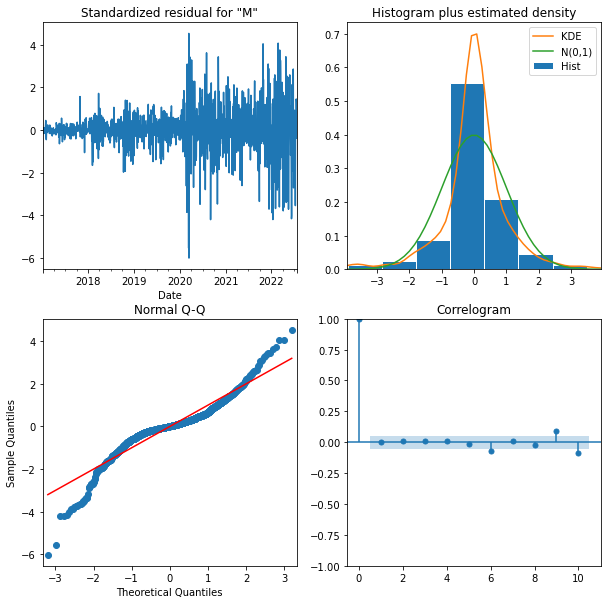

In [245]:
result_mod_arimax_1.plot_diagnostics(figsize=(10,10))
plt.show()

### ARIMAX version of ppred_66 for one step ahead prediction

In [246]:
mod_arimax_2 = SARIMAX(df.loc['2020-03-16':]['Msft Close'], order = (1,1,0), exog = df.loc['2020-03-16':]['dj shifted'], trend = 'c')

In [247]:
result_mod_arimax_2 = mod_arimax_2.fit()

In [248]:
forecast_result_mod_arimax_2 = result_mod_arimax_2.forecast(steps=1, exog = dow_100.loc['2022-07-22':]['Close'])

In [249]:
forecast_result_mod_arimax_2

2022-07-22    264.786573
Freq: B, dtype: float64

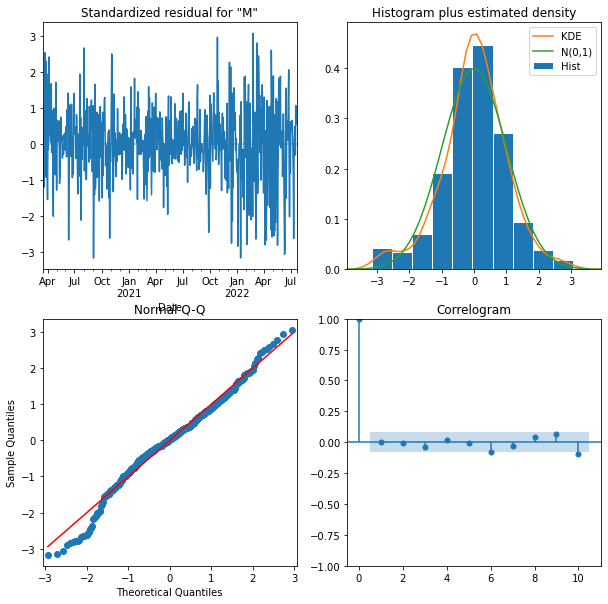

In [250]:
result_mod_arimax_2.plot_diagnostics(figsize=(10,10))
plt.show()

In [251]:
arimax_2_stepp = rmse(forecast_result_mod_arimax_2,msft_predict_20.loc[:'2022-07-22'])
print(arimax_2_stepp)

4.4265880074023585


In [252]:
print('ARIMAXs rmse value ' ,4.4491376484375-4.264313114823949, 'less than ARIMA 1 step prediction')

ARIMAXs rmse value  0.18482453361355056 less than ARIMA 1 step prediction


In [253]:
 0.1622/4.4491376484375

0.036456502993779775

### DAILY ARIMA PREDICTION OF 7 days (for RMSE comparision with weekly prediction, to make horizon of predictions equal) 2022-08-01

In [254]:
comp_daily = SARIMAX(df['Msft Close'], order = (1,1,0), trend = 'c')

In [255]:
result_comp_daily = comp_daily.fit()

In [256]:
fore_result_comp_daily = result_comp_daily.forecast(steps=7)

In [257]:
rmse_7_horison = rmse(fore_result_comp_daily, msft_predict_20.loc[:'2022-08-01'])
print(rmse_7_horison)

10.393145566890665


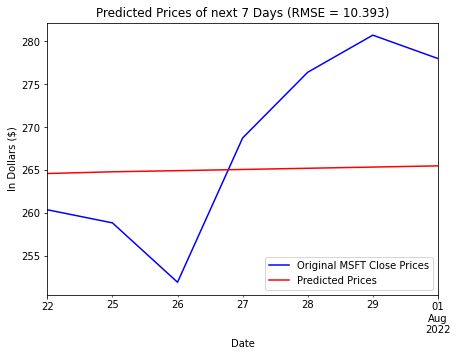

In [258]:
fig, ax = plt.subplots(figsize=(7,5))
msft_predict_20.loc[:'2022-08-01'].plot(ax=ax, c='b', label='Original MSFT Close Prices')
fore_result_comp_daily.plot(ax=ax, c='r', label = 'Predicted Prices')
plt.title('Predicted Prices of next 7 Days (RMSE = 10.393)')
plt.ylabel('In Dollars ($)')
plt.legend(loc='lower right')
plt.show()

# covid comparision test size 21 with pred_66

In [259]:
comp_daily_ccomp = SARIMAX(df.loc['2020-03-16':]['Msft Close'], order=(1,1,0), trend = 'c')

In [260]:
result_comp_daily_ccom = comp_daily_ccomp.fit()

In [261]:
fore_result_comp_daily_ccomp = result_comp_daily_ccom.forecast(steps=21)

In [262]:
rmse_21_horison = rmse(fore_result_comp_daily_ccomp, msft_predict_21)
print(rmse_21_horison)

16.765481467476192


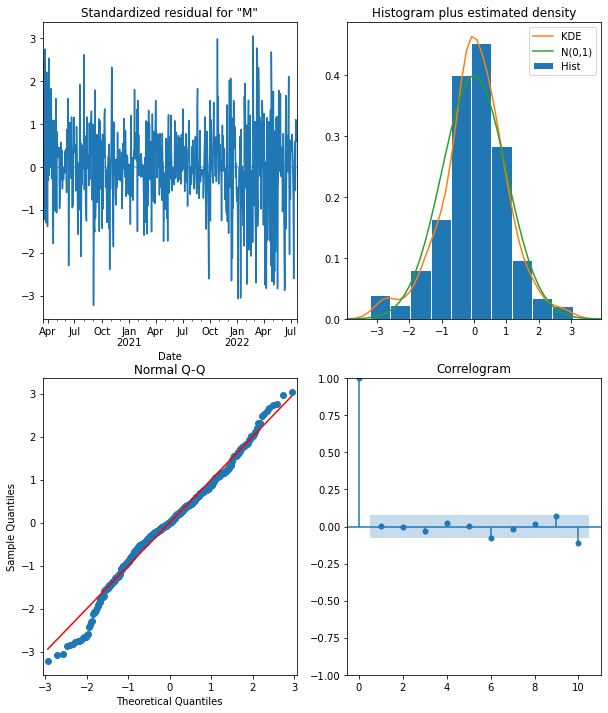

In [263]:
result_comp_daily_ccom.plot_diagnostics(figsize = (10, 12))
plt.show()

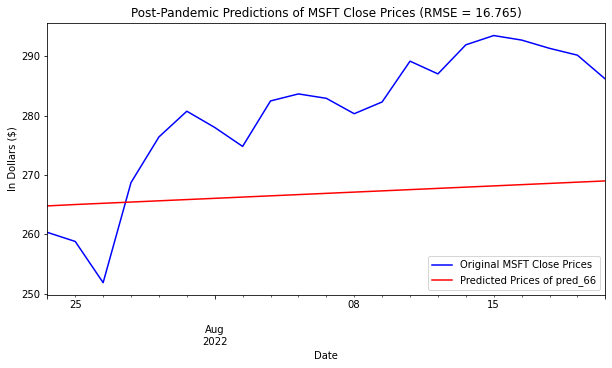

In [264]:
fig, ax = plt.subplots(figsize=(10,5))
msft_predict_21.plot(ax=ax, c='b', label='Original MSFT Close Prices')
fore_result_comp_daily_ccomp.plot(ax=ax, c='r', label = 'Predicted Prices of pred_66')
plt.title('Post-Pandemic Predictions of MSFT Close Prices (RMSE = 16.765)')
plt.ylabel('In Dollars ($)')
plt.legend(loc='lower right')
plt.show()

## WEEKLY FREQUENCY 2020-03-16

In [265]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1447 entries, 2017-01-04 to 2022-07-21
Freq: B
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Msft Close       1447 non-null   float64
 1   Dow Jones Close  1447 non-null   float64
 2   dj shifted       1447 non-null   float64
 3   msft diffed      1447 non-null   float64
 4   msft sdiffed     1446 non-null   float64
dtypes: float64(5)
memory usage: 100.1 KB


In [266]:
df_week = pd.concat([msft['Close'], dow_close_100], axis=1)

In [267]:
df_week.columns = ['Msft Close', 'Dow Jones Close']
print(df_week.head())

            Msft Close  Dow Jones Close
Date                                   
2017-01-03   62.580002       198.817598
2017-01-04   62.299999       199.421602
2017-01-05   62.299999       198.992891
2017-01-06   62.840000       199.638008
2017-01-09   62.639999       198.873809


In [268]:
df_week = df_week.asfreq('B').interpolate()

## I did not use .mean() because it was dividing the total of the values to the 7 since there is 7 days in one week. So, I used sum() and divide the total value to the 5 to get more accurate average. 

In [269]:
df_week = df_week.resample('W-FRI').sum()
df_week = df_week[['Msft Close', 'Dow Jones Close']]/5
print(df_week)

            Msft Close  Dow Jones Close
Date                                   
2017-01-06   50.004000       159.374020
2017-01-13   62.752000       198.947840
2017-01-20   62.537000       198.094781
2017-01-27   64.041999       199.951520
2017-02-03   64.042000       199.365062
...                ...              ...
2022-06-24  256.825002       306.801869
2022-07-01  259.608002       310.574500
2022-07-08  265.266998       311.521482
2022-07-15  256.340002       309.692777
2022-07-22  208.177997       253.622801

[290 rows x 2 columns]


## I'm removing the incompleted weeks, which first week and the last week in the dataset, since they can't divided to the 5. 

In [270]:
df_week

Msft Close  Dow Jones Close
Date                                   
2017-01-06   50.004000       159.374020
2017-01-13   62.752000       198.947840
2017-01-20   62.537000       198.094781
2017-01-27   64.041999       199.951520
2017-02-03   64.042000       199.365062
...                ...              ...
2022-06-24  256.825002       306.801869
2022-07-01  259.608002       310.574500
2022-07-08  265.266998       311.521482
2022-07-15  256.340002       309.692777
2022-07-22  208.177997       253.622801

[290 rows x 2 columns]

In [271]:
df_week = df_week.loc['2017-01-13':'2022-07-15']
print(df_week)

            Msft Close  Dow Jones Close
Date                                   
2017-01-13   62.752000       198.947840
2017-01-20   62.537000       198.094781
2017-01-27   64.041999       199.951520
2017-02-03   64.042000       199.365062
2017-02-10   63.693999       201.277637
...                ...              ...
2022-06-17  246.225998       302.731898
2022-06-24  256.825002       306.801869
2022-07-01  259.608002       310.574500
2022-07-08  265.266998       311.521482
2022-07-15  256.340002       309.692777

[288 rows x 2 columns]


### Weekly train data

In [272]:
df_week

Msft Close  Dow Jones Close
Date                                   
2017-01-13   62.752000       198.947840
2017-01-20   62.537000       198.094781
2017-01-27   64.041999       199.951520
2017-02-03   64.042000       199.365062
2017-02-10   63.693999       201.277637
...                ...              ...
2022-06-17  246.225998       302.731898
2022-06-24  256.825002       306.801869
2022-07-01  259.608002       310.574500
2022-07-08  265.266998       311.521482
2022-07-15  256.340002       309.692777

[288 rows x 2 columns]

# Weekly Data Decomposition

In [273]:
ts_dicomposition_week = seasonal_decompose(df_week['Msft Close'], model='additive', period=52)
trend_estimate_week = ts_dicomposition_week.trend
seasonal_estimate_week = ts_dicomposition_week.seasonal
residual_estimate_week = ts_dicomposition_week.resid

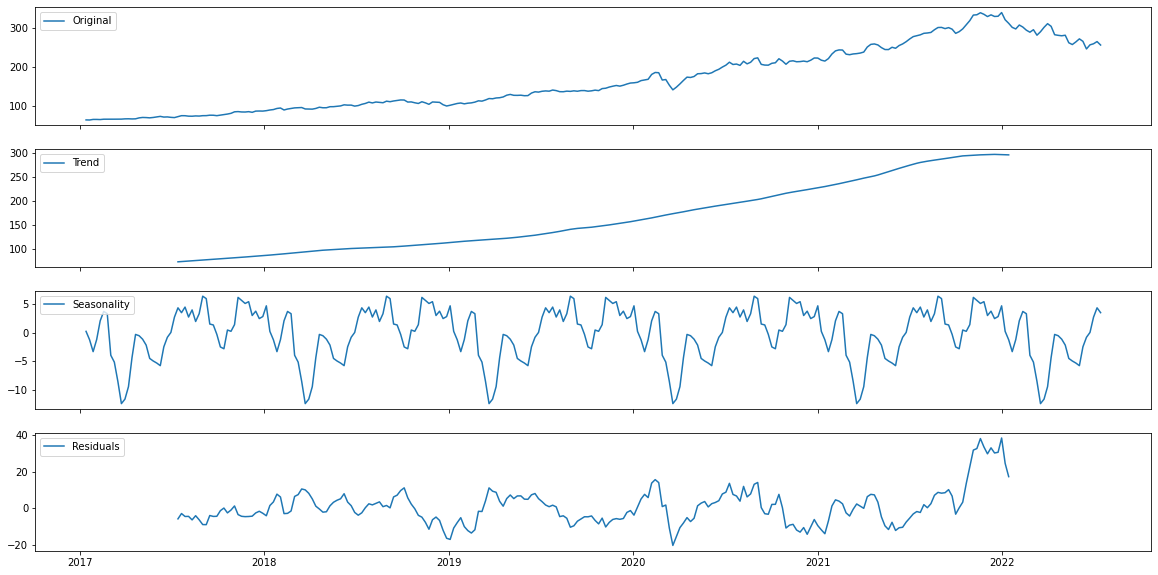

In [274]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(20)
# First plot to the Original time series
axes[0].plot(df_week['Msft Close'], label='Original') 
axes[0].legend(loc='upper left');
# second plot to be for trend
axes[1].plot(trend_estimate_week, label='Trend')
axes[1].legend(loc='upper left');
# third plot to be Seasonality component
axes[2].plot(seasonal_estimate_week, label='Seasonality')
axes[2].legend(loc='upper left');
# last last plot to be Residual component
axes[3].plot(residual_estimate_week, label='Residuals')
axes[3].legend(loc='upper left'); plt.show()

In [275]:
(261.214996 + 262.850006 +266.209991 +268.399994+267.660004)/5

265.2669982

In [276]:
actual_values_daily =  pd.DataFrame(msft_predict_20)
actual_values_daily = actual_values_daily.asfreq('B').interpolate()

### Weekly Test Data

In [277]:
msft_week = pd.read_csv('msft_week.csv', parse_dates=['Date'], index_col='Date')
dj_week = pd.read_csv('dj_week.csv', parse_dates=['Date'], index_col='Date')

In [278]:
test_df = pd.concat([msft_week['Close'], dj_week['Close']], axis=1)
print(test_df)

                 Close         Close
Date                                
2022-07-18  254.250000  31072.609375
2022-07-19  259.529999  31827.050781
2022-07-20  262.269989  31874.839844
2022-07-21  264.839996  32036.900391
2022-07-22  260.359985  31899.289062
2022-07-25  258.829987  31990.039062
2022-07-26  251.899994  31761.539062
2022-07-27  268.739990  32197.589844
2022-07-28  276.410004  32529.630859
2022-07-29  280.739990  32845.128906
2022-08-01  278.010010  32798.398438
2022-08-02  274.820007  32396.169922
2022-08-03  282.470001  32812.500000
2022-08-04  283.649994  32726.820312
2022-08-05  282.910004  32803.468750
2022-08-08  280.320007  32832.539062
2022-08-09  282.299988  32774.410156
2022-08-10  289.160004  33309.511719
2022-08-11  287.019989  33336.671875
2022-08-12  291.910004  33761.050781
2022-08-15  293.470001  33912.441406
2022-08-16  292.709991  34152.011719
2022-08-17  291.320007  33980.320312
2022-08-18  290.170013  33999.039062
2022-08-19  286.149994  33706.738281
2

In [279]:
test_df.columns = ['Msft Close', 'Dow Jones Close']

In [280]:
test_df['Dow Jones Close'] = test_df['Dow Jones Close']/100
print(test_df)

            Msft Close  Dow Jones Close
Date                                   
2022-07-18  254.250000       310.726094
2022-07-19  259.529999       318.270508
2022-07-20  262.269989       318.748398
2022-07-21  264.839996       320.369004
2022-07-22  260.359985       318.992891
2022-07-25  258.829987       319.900391
2022-07-26  251.899994       317.615391
2022-07-27  268.739990       321.975898
2022-07-28  276.410004       325.296309
2022-07-29  280.739990       328.451289
2022-08-01  278.010010       327.983984
2022-08-02  274.820007       323.961699
2022-08-03  282.470001       328.125000
2022-08-04  283.649994       327.268203
2022-08-05  282.910004       328.034688
2022-08-08  280.320007       328.325391
2022-08-09  282.299988       327.744102
2022-08-10  289.160004       333.095117
2022-08-11  287.019989       333.366719
2022-08-12  291.910004       337.610508
2022-08-15  293.470001       339.124414
2022-08-16  292.709991       341.520117
2022-08-17  291.320007       339.803203


In [281]:
test_df = test_df.asfreq('B').interpolate()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35 entries, 2022-07-18 to 2022-09-02
Freq: B
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Msft Close       35 non-null     float64
 1   Dow Jones Close  35 non-null     float64
dtypes: float64(2)
memory usage: 840.0 bytes


In [282]:
weekly_test_df = test_df.resample('W-FRI').sum()

In [283]:
weekly_test_df = weekly_test_df[['Msft Close', 'Dow Jones Close']]/5

In [284]:
weekly_test_df

Msft Close  Dow Jones Close
Date                                   
2022-07-22  260.249994       317.421379
2022-07-29  267.323993       322.647855
2022-08-05  280.372003       327.074715
2022-08-12  286.141998       332.028367
2022-08-19  290.764001       339.501102
2022-08-26  275.384003       329.035223
2022-09-02  261.226001       316.750297

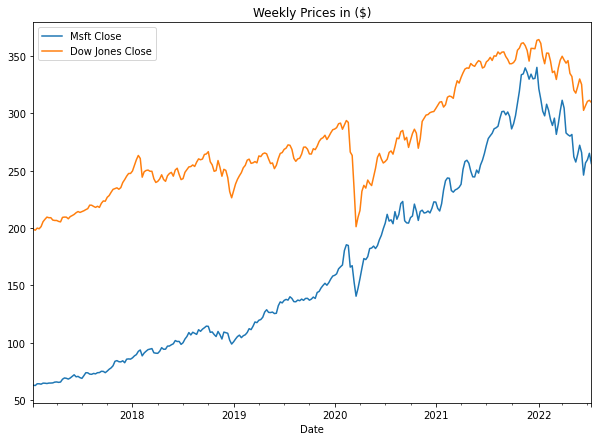

In [285]:
df_week.plot(figsize = (10,7), title='Weekly Prices in ($)')
plt.show()

In [286]:
raw_df_week = adfuller(df_week['Msft Close'])
print(raw_df_week)

(-0.7894763254649225, 0.8221937890382913, 2, 285, {'1%': -3.4535050041524245, '5%': -2.8717352599720294, '10%': -2.5722024776854417}, 1678.333443291796)


In [287]:
df_week_dif11 = df_week['Msft Close'].diff().dropna()

In [288]:
dif1_raw_df_week = adfuller(df_week_dif11)
print(dif1_raw_df_week)

(-11.946019875016987, 4.428446725695881e-22, 1, 285, {'1%': -3.4535050041524245, '5%': -2.8717352599720294, '10%': -2.5722024776854417}, 1671.9039830915826)


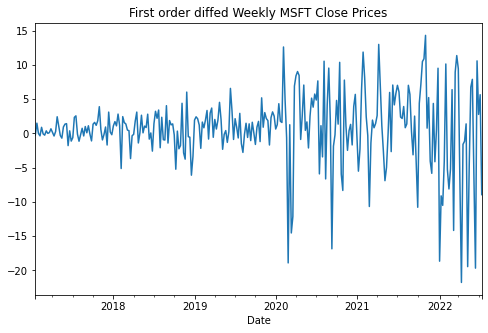

In [289]:
df_week_dif11.plot(figsize = (8,5))
plt.title('First order diffed Weekly MSFT Close Prices')
plt.show()

In [290]:
log_msft_week = np.log(df_week['Msft Close'])

In [291]:
log_week_dif1 = log_msft_week.diff().dropna()

In [292]:
adf_log_dif = adfuller(log_week_dif1)
print(adf_log_dif)

(-12.141725721474725, 1.6451279198704714e-22, 1, 285, {'1%': -3.4535050041524245, '5%': -2.8717352599720294, '10%': -2.5722024776854417}, -1196.2037458977193)


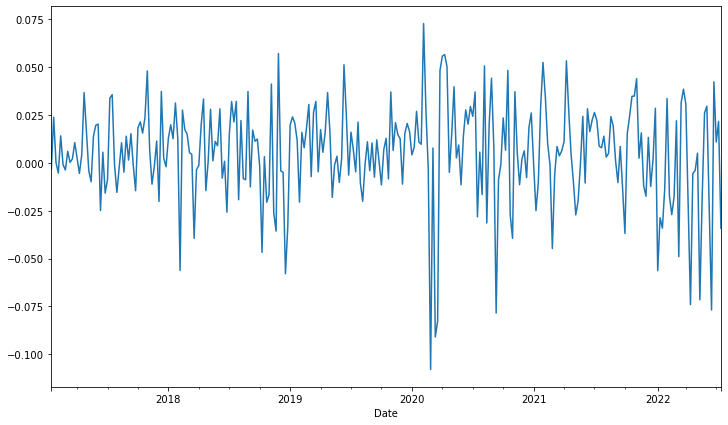

In [293]:
log_week_dif1.plot(figsize=(12,7))
plt.show()

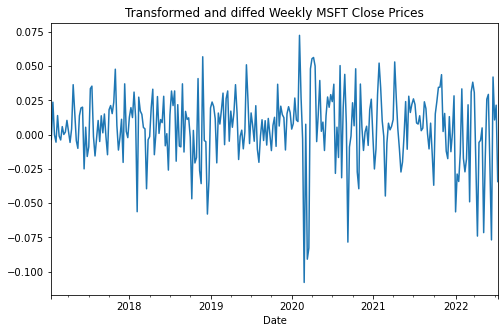

In [294]:
log_week_dif1.plot(figsize = (8,5))
plt.title('Transformed and diffed Weekly MSFT Close Prices')
plt.show()

In [295]:
df_week.head()

Msft Close  Dow Jones Close
Date                                   
2017-01-13   62.752000       198.947840
2017-01-20   62.537000       198.094781
2017-01-27   64.041999       199.951520
2017-02-03   64.042000       199.365062
2017-02-10   63.693999       201.277637

In [296]:
log_msft = pd.Series(np.log(df_week['Msft Close']))
log_dj = pd.Series(np.log(df_week['Dow Jones Close']))
df_week = pd.concat([df_week, log_msft, log_dj], axis=1)
df_week.head()

Msft Close  Dow Jones Close  Msft Close  Dow Jones Close
Date                                                                
2017-01-13   62.752000       198.947840    4.139190         5.293043
2017-01-20   62.537000       198.094781    4.135758         5.288746
2017-01-27   64.041999       199.951520    4.159539         5.298075
2017-02-03   64.042000       199.365062    4.159539         5.295138
2017-02-10   63.693999       201.277637    4.154090         5.304685

In [297]:
df_week.columns = ['Msft Close', 'Dow Jones Close', 'log_msft', 'log_dj']
print(df_week.head())

            Msft Close  Dow Jones Close  log_msft    log_dj
Date                                                       
2017-01-13   62.752000       198.947840  4.139190  5.293043
2017-01-20   62.537000       198.094781  4.135758  5.288746
2017-01-27   64.041999       199.951520  4.159539  5.298075
2017-02-03   64.042000       199.365062  4.159539  5.295138
2017-02-10   63.693999       201.277637  4.154090  5.304685


In [298]:
df_week['dj shifted'] = df_week['log_dj'].shift(periods=1)

In [299]:
df_week['log_dif_msft'] = df_week['log_msft'].diff()

In [300]:
df_week.head()

Msft Close  Dow Jones Close  log_msft    log_dj  dj shifted  \
Date                                                                      
2017-01-13   62.752000       198.947840  4.139190  5.293043         NaN   
2017-01-20   62.537000       198.094781  4.135758  5.288746    5.293043   
2017-01-27   64.041999       199.951520  4.159539  5.298075    5.288746   
2017-02-03   64.042000       199.365062  4.159539  5.295138    5.298075   
2017-02-10   63.693999       201.277637  4.154090  5.304685    5.295138   

            log_dif_msft  
Date                      
2017-01-13           NaN  
2017-01-20 -3.432065e-03  
2017-01-27  2.378072e-02  
2017-02-03  1.191311e-08  
2017-02-10 -5.448757e-03

In [301]:
df_week = df_week.dropna()
print(df_week)

            Msft Close  Dow Jones Close  log_msft    log_dj  dj shifted  \
Date                                                                      
2017-01-20   62.537000       198.094781  4.135758  5.288746    5.293043   
2017-01-27   64.041999       199.951520  4.159539  5.298075    5.288746   
2017-02-03   64.042000       199.365062  4.159539  5.295138    5.298075   
2017-02-10   63.693999       201.277637  4.154090  5.304685    5.295138   
2017-02-17   64.592000       205.544500  4.168091  5.325663    5.304685   
...                ...              ...       ...       ...         ...   
2022-06-17  246.225998       302.731898  5.506250  5.712848    5.784886   
2022-06-24  256.825002       306.801869  5.548395  5.726202    5.712848   
2022-07-01  259.608002       310.574500  5.559173  5.738424    5.726202   
2022-07-08  265.266998       311.521482  5.580737  5.741468    5.738424   
2022-07-15  256.340002       309.692777  5.546505  5.735581    5.741468   

            log_dif_msft

In [302]:
df_week.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 287 entries, 2017-01-20 to 2022-07-15
Freq: W-FRI
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Msft Close       287 non-null    float64
 1   Dow Jones Close  287 non-null    float64
 2   log_msft         287 non-null    float64
 3   log_dj           287 non-null    float64
 4   dj shifted       287 non-null    float64
 5   log_dif_msft     287 non-null    float64
dtypes: float64(6)
memory usage: 15.7 KB


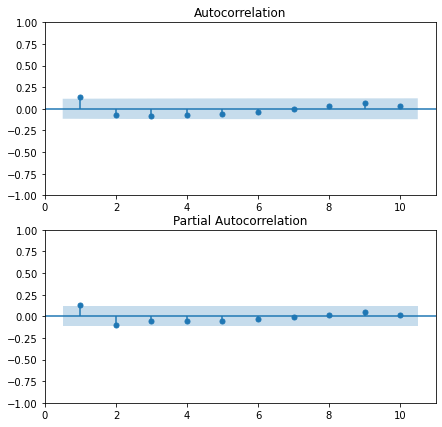

In [303]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7, 7))
plot_acf(df_week['log_dif_msft'], lags=10, zero=False, ax=ax1)
plot_pacf(df_week['log_dif_msft'], lags=10, zero=False, ax=ax2, method='ywm')
plt.show()

### order of the model is 1,1,1

In [304]:
for p in range(4):
    for q in range(4):
        model_1 = SARIMAX(df_week['log_msft'], order=(p,1,q))
        results_aic_bic = model_1.fit()
        print(p, q, results_aic_bic.aic, results_aic_bic.bic)

0 0 -1266.6248347947044 -1262.9688429838845
0 1 -1273.5591063020763 -1266.2471226804366
0 2 -1271.7776807571422 -1260.8097053246827
0 3 -1270.1613598317995 -1255.53739258852
1 0 -1272.6861517916964 -1265.3741681700567
1 1 -1271.720740968876 -1260.7527655364165
1 2 -1269.5595053592951 -1254.9355381160158
1 3 -1267.9259418966012 -1249.645982842502
2 0 -1272.0699860709228 -1261.1020106384633


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2 1 -1270.369505916227 -1255.7455386729475
2 2 -1268.3526920385984 -1250.0727329844992


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2 3 -1270.4420055470473 -1248.5060546821283
3 0 -1270.2618121156665 -1255.6378448723872
3 1 -1268.2280561028924 -1249.9480970487932
3 2 -1266.169409582805 -1244.233458717886
3 3 -1265.854301245256 -1240.2623585695171


C:\Users\kutay\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [305]:
results_weekly_auto = pm.auto_arima(df_week['log_msft'],
                         start_p=0,  # initial guess for AR(p)
                         start_d=0,  # initial guess for I(d)
                         start_q=0,  # initial guess for MA(q)
                         max_p=4,    # max guess for AR(p)
                         max_d=4,    # max guess for I(d)
                         max_q=4,    # max guess for MA(q)
                         trend='c',
                         information_criterion='aic',
                         trace=True,
                         error_action='ignore'
                         )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1274.838, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1278.177, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1279.162, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1274.838, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1277.726, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1278.247, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1278.783, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1279.162, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.651 seconds


## ARIMA WEEKLY

In [306]:
model_week_1 = SARIMAX(df_week['log_msft'], order = (1,1,1), trend = 'c')

In [307]:
result_model_week_1 = model_week_1.fit()

In [308]:
fore_result_model_week_1 = result_model_week_1.forecast(steps=7)

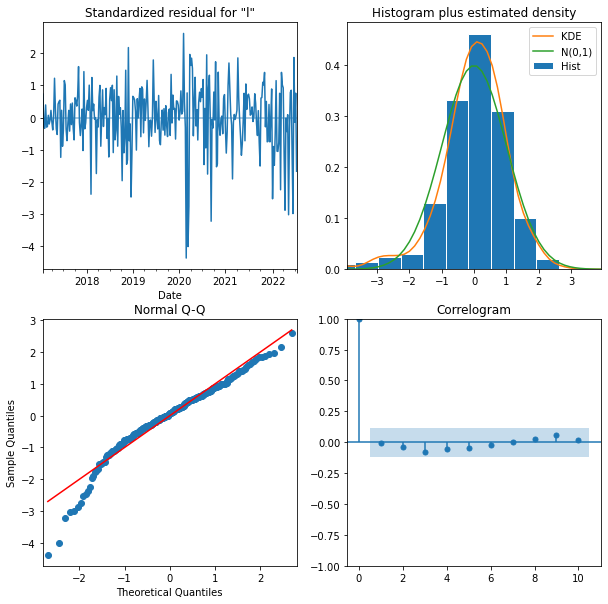

In [309]:
result_model_week_1.plot_diagnostics(figsize = (10,10)); plt.show()

In [310]:
model_week_2 = SARIMAX(df_week['log_msft'], order = (0,1,1), trend = 'c')

In [311]:
result_model_week_2 = model_week_2.fit()

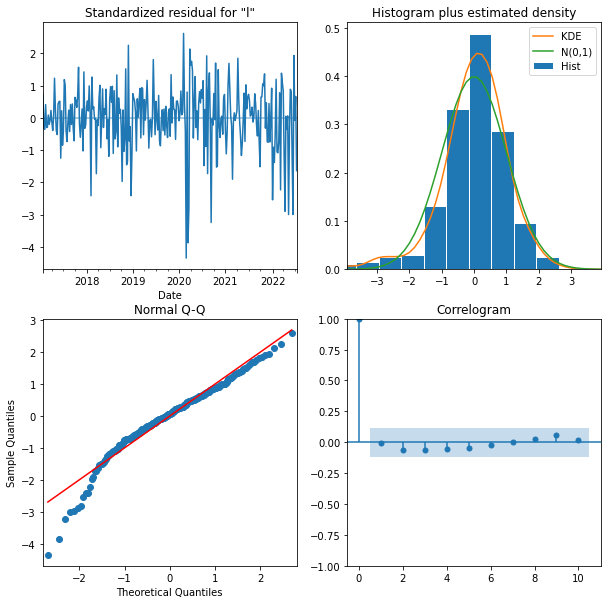

In [312]:
result_model_week_2.plot_diagnostics(figsize = (10,10))
plt.show()

# Back transforming

In [313]:
fore_result_model_week_1_org = np.exp(fore_result_model_week_1)

In [314]:
weekly_test_df

Msft Close  Dow Jones Close
Date                                   
2022-07-22  260.249994       317.421379
2022-07-29  267.323993       322.647855
2022-08-05  280.372003       327.074715
2022-08-12  286.141998       332.028367
2022-08-19  290.764001       339.501102
2022-08-26  275.384003       329.035223
2022-09-02  261.226001       316.750297

In [315]:
pred_week_df = pd.concat([fore_result_model_week_1_org, weekly_test_df['Msft Close']], axis=1)
pred_week_df.columns= ['predictions', 'actual prices']

In [316]:
pred_week_df

predictions  actual prices
2022-07-22   255.723683     260.249994
2022-07-29   257.400402     267.323993
2022-08-05   258.576255     280.372003
2022-08-12   259.871102     286.141998
2022-08-19   261.147177     290.764001
2022-08-26   262.435130     275.384003
2022-09-02   263.728188     261.226001

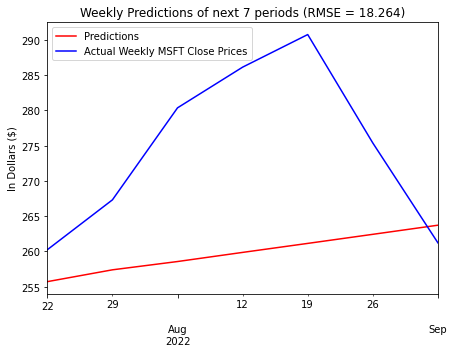

In [317]:
fig, ax = plt.subplots(figsize=(7,5))
pred_week_df['predictions'].plot(ax=ax, color='r', label='Predictions')
pred_week_df['actual prices'].plot(ax=ax, color = 'b', label='Actual Weekly MSFT Close Prices')
plt.legend(loc='upper left')
plt.ylabel('In Dollars ($)')
plt.title('Weekly Predictions of next 7 periods (RMSE = 18.264)')
plt.show()

In [318]:
weekly_rmse_1 = rmse(pred_week_df['actual prices'], pred_week_df['predictions'])
print(weekly_rmse_1)

18.26499513726582


## ARIMAX WEEKLY

In [319]:
df_week.tail()

Msft Close  Dow Jones Close  log_msft    log_dj  dj shifted  \
Date                                                                      
2022-06-17  246.225998       302.731898  5.506250  5.712848    5.784886   
2022-06-24  256.825002       306.801869  5.548395  5.726202    5.712848   
2022-07-01  259.608002       310.574500  5.559173  5.738424    5.726202   
2022-07-08  265.266998       311.521482  5.580737  5.741468    5.738424   
2022-07-15  256.340002       309.692777  5.546505  5.735581    5.741468   

            log_dif_msft  
Date                      
2022-06-17     -0.076825  
2022-06-24      0.042145  
2022-07-01      0.010778  
2022-07-08      0.021564  
2022-07-15     -0.034232

In [320]:
weekly_test_df.head()

Msft Close  Dow Jones Close
Date                                   
2022-07-22  260.249994       317.421379
2022-07-29  267.323993       322.647855
2022-08-05  280.372003       327.074715
2022-08-12  286.141998       332.028367
2022-08-19  290.764001       339.501102

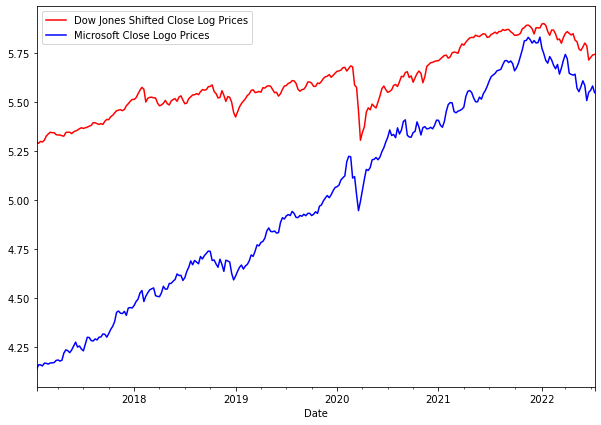

In [321]:
fig, ax = plt.subplots(figsize = (10,7))
df_week['dj shifted'].plot(ax=ax, color='r', label='Dow Jones Shifted Close Log Prices')
df_week['log_msft'].plot(ax=ax, color='b', label='Microsoft Close Logo Prices')
plt.legend()
plt.show()

## Correlation

In [322]:
df_week['log_msft'].corr(df_week['dj shifted'])

0.9246861036609281

In [323]:
df_delta_dj_log = pd.DataFrame(df_week['log_dj'])
print(df_delta_dj_log.head())

              log_dj
Date                
2017-01-20  5.288746
2017-01-27  5.298075
2017-02-03  5.295138
2017-02-10  5.304685
2017-02-17  5.325663


In [324]:
df_delta_dj_log.index += timedelta(weeks=1)

In [325]:
df_delta_dj_log.tail()

log_dj
Date                
2022-06-24  5.712848
2022-07-01  5.726202
2022-07-08  5.738424
2022-07-15  5.741468
2022-07-22  5.735581

#  Weekly one-step-ahead predictions

## ARIMA one-step-ahead

In [326]:
week_arima_model_c = SARIMAX(df_week['log_msft'], order = (0,1,1), trend = 'c')

In [327]:
result_week_arimax_model_1_c = week_arima_model_c.fit()

In [328]:
fore_result_week_arimax_model_1_c = result_week_arimax_model_1_c.forecast(steps=1)

In [329]:
fore_result_week_arimax_model_1_orgcc = pd.DataFrame(np.exp(fore_result_week_arimax_model_1_c))
fore_result_week_arimax_model_1_orgcc.columns = ['prediction']
fore_result_week_arimax_model_1_orgcc

prediction
2022-07-22  255.888404

In [330]:
arima_week_1_rmsecc = rmse(weekly_test_df.loc['2022-07-22']['Msft Close'], fore_result_week_arimax_model_1_orgcc)
print(arima_week_1_rmsecc)

[4.36159002]


In [331]:
arima_week_1_rmse_orgcc = rmse(msft_predict_20.loc['2022-07-22'], fore_result_week_arimax_model_1_orgcc)
print(arima_week_1_rmse_orgcc)

[4.47158147]


## ARIMAX one-step-ahead

In [332]:
week_arimax_model_1 = SARIMAX(df_week['log_msft'], order = (0,1,1), trend = 'c', exog = df_week['dj shifted'])

In [333]:
result_week_arimax_model_1 = week_arimax_model_1.fit()

In [334]:
fore_result_week_arimax_model_1 = result_week_arimax_model_1.forecast(steps=1, exog=df_delta_dj_log.loc['2022-07-22']['log_dj'])

In [335]:
fore_result_week_arimax_model_1_org = pd.DataFrame(np.exp(fore_result_week_arimax_model_1))
fore_result_week_arimax_model_1_org.columns = ['prediction']
fore_result_week_arimax_model_1_org

prediction
2022-07-22  255.979349

In [336]:
weekly_test_df.loc['2022-07-22']['Msft Close']

260.2499938964844

In [337]:
arimax_week_1_rmse = rmse(weekly_test_df.loc['2022-07-22']['Msft Close'], fore_result_week_arimax_model_1_org)
print(arimax_week_1_rmse)

[4.27064518]


## Original (org) close price of 2022-07-22

In [338]:
msft_predict_20.loc['2022-07-22']

260.3599853515625

In [339]:
arimax_week_1_rmse_org = rmse(msft_predict_20.loc['2022-07-22'], fore_result_week_arimax_model_1_org)
print(arimax_week_1_rmse_org)

[4.38063664]


# Monthly Arima Dataset Prepration (Canceled)

In [340]:
df.tail()

Msft Close  Dow Jones Close  dj shifted  msft diffed  msft sdiffed
Date                                                                          
2022-07-15  256.720001       312.882598  306.301699     2.639999      1.279999
2022-07-18  254.250000       310.726094  312.882598    -2.470001     -5.110001
2022-07-19  259.529999       318.270508  310.726094     5.279999      7.750000
2022-07-20  262.269989       318.748398  318.270508     2.739990     -2.540009
2022-07-21  264.839996       320.369004  318.748398     2.570007     -0.169983

In [341]:
msft_dow.tail()

Msft Close  Dow Jones Close  dj shifted  msft diffed
Date                                                            
2022-07-15  256.720001       312.882598  306.301699     2.639999
2022-07-18  254.250000       310.726094  312.882598    -2.470001
2022-07-19  259.529999       318.270508  310.726094     5.279999
2022-07-20  262.269989       318.748398  318.270508     2.739990
2022-07-21  264.839996       320.369004  318.748398     2.570007

In [342]:
monthly_df = pd.concat([msft_close, dow_close_100], axis=1)

In [343]:
monthly_df = monthly_df.loc['2017-02-01':'2022-06-30']

### Converting to the Business Days to fullfill Busines Month Days. For train dataset

In [344]:
monthly_df = monthly_df.asfreq('B').interpolate()
monthly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1412 entries, 2017-02-01 to 2022-06-30
Freq: B
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Msft Close  1412 non-null   float64
 1   Close       1412 non-null   float64
dtypes: float64(2)
memory usage: 33.1 KB


In [345]:
monthly_df.head()

Msft Close       Close
Date                              
2017-02-01   63.580002  198.909395
2017-02-02   63.169998  198.849102
2017-02-03   63.680000  200.714609
2017-02-06   63.639999  200.524199
2017-02-07   63.430000  200.902891

In [346]:
monthly_df_train = monthly_df.resample('BM').mean()
monthly_df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65 entries, 2017-02-28 to 2022-06-30
Freq: BM
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Msft Close  65 non-null     float64
 1   Close       65 non-null     float64
dtypes: float64(2)
memory usage: 1.5 KB


In [347]:
monthly_df_train.columns = ['Msft Close', 'Dow Jones Close']

In [348]:
monthly_df_train

Msft Close  Dow Jones Close
Date                                   
2017-02-28   64.135750       204.371132
2017-03-31   64.841305       208.230580
2017-04-28   66.123750       206.777132
2017-05-31   68.972392       209.419445
2017-06-30   70.518182       213.177954
...                ...              ...
2022-02-28  298.184251       346.079510
2022-03-31  295.749566       340.297407
2022-04-29  288.399283       343.205363
2022-05-31  266.993862       324.122845
2022-06-30  259.098865       313.904765

[65 rows x 2 columns]

## Preparing monthly test dataset.

In [349]:
prep_part1_test = pd.concat([msft_close.loc['2022-07-01':'2022-07-17'], dow_close_100.loc['2022-07-01':'2022-07-17']], axis=1)

In [350]:
prep_part1_test.columns = ['Msft Close', 'Dow Jones Close']

In [351]:
prep_part1_test = prep_part1_test.asfreq('B').interpolate()

In [352]:
prep_part1_test

Msft Close  Dow Jones Close
Date                                   
2022-07-01  259.579987       310.972598
2022-07-04  261.214996       310.325400
2022-07-05  262.850006       309.678203
2022-07-06  266.209991       310.376797
2022-07-07  268.399994       313.845508
2022-07-08  267.660004       313.381504
2022-07-11  264.510010       311.738398
2022-07-12  253.669998       309.813301
2022-07-13  252.720001       307.727891
2022-07-14  254.080002       306.301699
2022-07-15  256.720001       312.882598

In [353]:
test_df

Msft Close  Dow Jones Close
Date                                   
2022-07-18  254.250000       310.726094
2022-07-19  259.529999       318.270508
2022-07-20  262.269989       318.748398
2022-07-21  264.839996       320.369004
2022-07-22  260.359985       318.992891
2022-07-25  258.829987       319.900391
2022-07-26  251.899994       317.615391
2022-07-27  268.739990       321.975898
2022-07-28  276.410004       325.296309
2022-07-29  280.739990       328.451289
2022-08-01  278.010010       327.983984
2022-08-02  274.820007       323.961699
2022-08-03  282.470001       328.125000
2022-08-04  283.649994       327.268203
2022-08-05  282.910004       328.034688
2022-08-08  280.320007       328.325391
2022-08-09  282.299988       327.744102
2022-08-10  289.160004       333.095117
2022-08-11  287.019989       333.366719
2022-08-12  291.910004       337.610508
2022-08-15  293.470001       339.124414
2022-08-16  292.709991       341.520117
2022-08-17  291.320007       339.803203
2022-08-18  290.170013       339.990391
2022-08-19  286.149994       337.067383
2022-08-22  277.750000       330.636094
2022-08-23  276.440002       329.095898
2022-08-24  275.790009       329.692305
2022-08-25  278.850006       332.917813
2022-08-26  268.089996       322.834004
2022-08-29  265.230011       320.989902
2022-08-30  262.970001       317.908691
2022-08-31  261.470001       315.104297
2022-09-01  260.399994       316.564199
2022-09-02  256.059998       313.184395

In [354]:
monthly_test = pd.concat([prep_part1_test, test_df], axis=0)
print(monthly_test)

            Msft Close  Dow Jones Close
Date                                   
2022-07-01  259.579987       310.972598
2022-07-04  261.214996       310.325400
2022-07-05  262.850006       309.678203
2022-07-06  266.209991       310.376797
2022-07-07  268.399994       313.845508
2022-07-08  267.660004       313.381504
2022-07-11  264.510010       311.738398
2022-07-12  253.669998       309.813301
2022-07-13  252.720001       307.727891
2022-07-14  254.080002       306.301699
2022-07-15  256.720001       312.882598
2022-07-18  254.250000       310.726094
2022-07-19  259.529999       318.270508
2022-07-20  262.269989       318.748398
2022-07-21  264.839996       320.369004
2022-07-22  260.359985       318.992891
2022-07-25  258.829987       319.900391
2022-07-26  251.899994       317.615391
2022-07-27  268.739990       321.975898
2022-07-28  276.410004       325.296309
2022-07-29  280.739990       328.451289
2022-08-01  278.010010       327.983984
2022-08-02  274.820007       323.961699


In [355]:
monthly_test = monthly_test.loc[:'2022-08-31']

In [356]:
monthly_test = monthly_test.resample('BM').mean()
print(monthly_test)

            Msft Close  Dow Jones Close
Date                                   
2022-07-29  262.165949       315.113813
2022-08-31  280.564350       330.095649


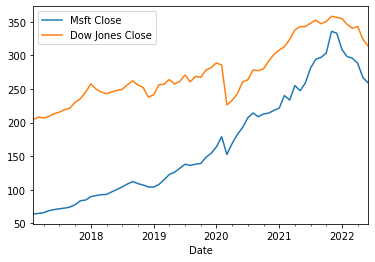

In [357]:
monthly_df_train.plot()
plt.show()

In [358]:
monthly_df_train

Msft Close  Dow Jones Close
Date                                   
2017-02-28   64.135750       204.371132
2017-03-31   64.841305       208.230580
2017-04-28   66.123750       206.777132
2017-05-31   68.972392       209.419445
2017-06-30   70.518182       213.177954
...                ...              ...
2022-02-28  298.184251       346.079510
2022-03-31  295.749566       340.297407
2022-04-29  288.399283       343.205363
2022-05-31  266.993862       324.122845
2022-06-30  259.098865       313.904765

[65 rows x 2 columns]

# Monthly Data Decomposition

In [359]:
ts_dicomposition_month = seasonal_decompose(monthly_df_train['Msft Close'], model='additive', period=12)
trend_estimate_month = ts_dicomposition_month.trend
seasonal_estimate_month = ts_dicomposition_month.seasonal
residual_estimate_month = ts_dicomposition_month.resid

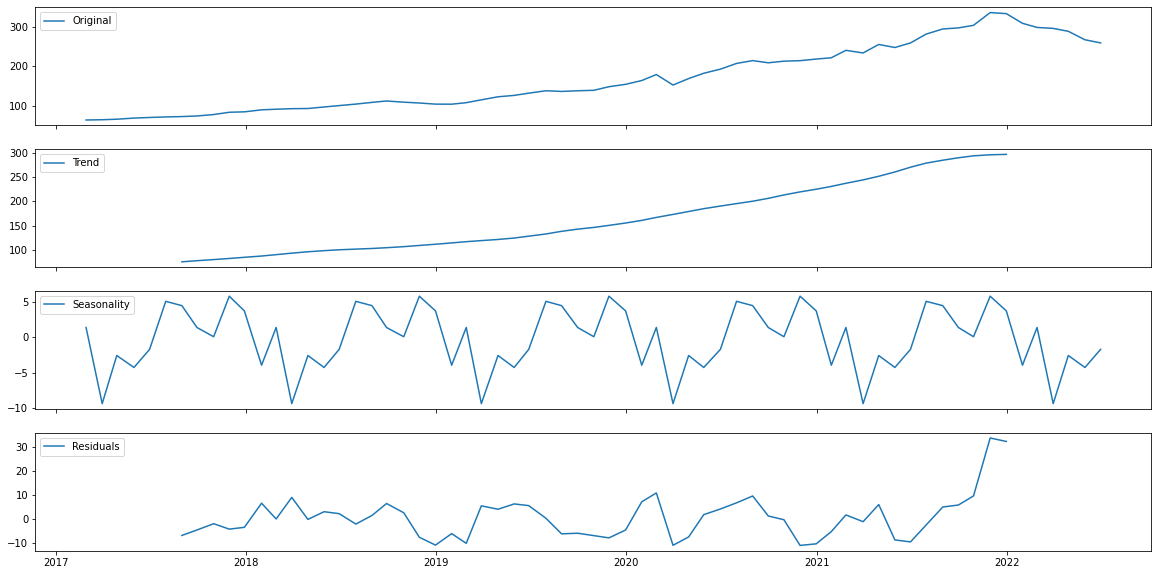

In [360]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(20)
# First plot to the Original time series
axes[0].plot(monthly_df_train['Msft Close'], label='Original') 
axes[0].legend(loc='upper left');
# second plot to be for trend
axes[1].plot(trend_estimate_month, label='Trend')
axes[1].legend(loc='upper left');
# third plot to be Seasonality component
axes[2].plot(seasonal_estimate_month, label='Seasonality')
axes[2].legend(loc='upper left');
# last last plot to be Residual component
axes[3].plot(residual_estimate_month, label='Residuals')
axes[3].legend(loc='upper left'); plt.show()

In [361]:
monthly_df_train['dj shifted'] = monthly_df_train['Dow Jones Close'].shift(periods=1)

In [362]:
monthly_df_train['msft diffed'] = monthly_df_train['Msft Close'].diff()

In [363]:
monthly_df_train = monthly_df_train.dropna()

In [364]:
monthly_df_train.tail()

Msft Close  Dow Jones Close  dj shifted  msft diffed
Date                                                            
2022-02-28  298.184251       346.079510  354.649063   -10.447416
2022-03-31  295.749566       340.297407  346.079510    -2.434685
2022-04-29  288.399283       343.205363  340.297407    -7.350283
2022-05-31  266.993862       324.122845  343.205363   -21.405421
2022-06-30  259.098865       313.904765  324.122845    -7.894997

In [365]:
adf_month_org = adfuller(monthly_df_train['Msft Close'])
print(adf_month_org)

(-0.7073020460321066, 0.8448490661198286, 0, 63, {'1%': -3.5386953618719676, '5%': -2.9086446751210775, '10%': -2.591896782564878}, 396.78982927408634)


In [366]:
adf_month_dif1 = adfuller(monthly_df_train['msft diffed'])
print(adf_month_dif1)

(-6.954721191880117, 9.493544496242931e-10, 0, 63, {'1%': -3.5386953618719676, '5%': -2.9086446751210775, '10%': -2.591896782564878}, 397.07446530825973)


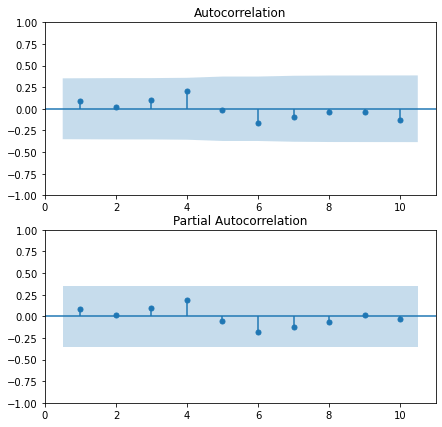

In [367]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7, 7))
plot_acf(monthly_df_train.loc['2019-12-01':]['msft diffed'], lags=10, zero=False, ax=ax1)
plot_pacf(monthly_df_train.loc['2019-12-01':]['msft diffed'], lags=10, zero=False, ax=ax2, method='ywm')
plt.show()

In [368]:
model_monthly = SARIMAX(monthly_df_train['Msft Close'], order = (0,1,0), trend='c')

In [369]:
result_model_monthly = model_monthly.fit()

In [370]:
fore_result_model_monthly = result_model_monthly.forecast(steps=2)

In [371]:
fore_result_model_monthly

2022-07-29    262.182318
2022-08-31    265.265771
Freq: BM, Name: predicted_mean, dtype: float64

In [372]:
monthly_test

Msft Close  Dow Jones Close
Date                                   
2022-07-29  262.165949       315.113813
2022-08-31  280.564350       330.095649

In [373]:
monthly_comparision = pd.concat([fore_result_model_monthly, monthly_test['Msft Close']], axis=1)
monthly_comparision.columns = ['predictions', 'actual result']
print(monthly_comparision)

            predictions  actual result
2022-07-29   262.182318     262.165949
2022-08-31   265.265771     280.564350


In [374]:
monthly_arima_rmse_1 = rmse(fore_result_model_monthly, monthly_test['Msft Close'])
print(monthly_arima_rmse_1)

10.817734546737338


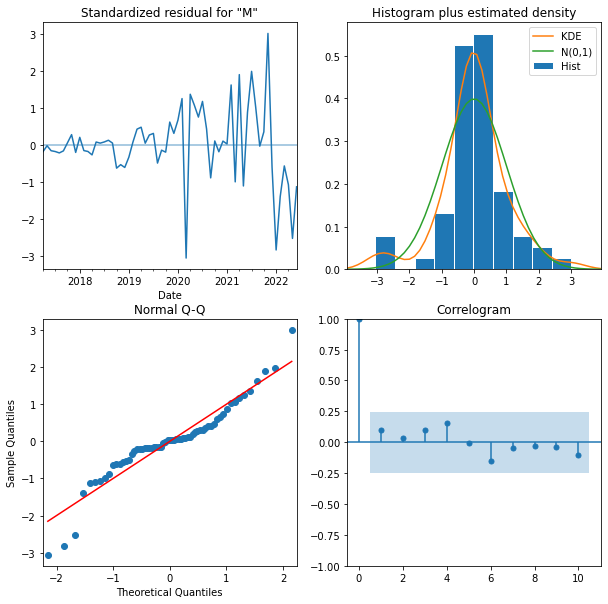

In [375]:
result_model_monthly.plot_diagnostics(figsize = (10,10))
plt.show()

In [376]:
monthly_df = pd.DataFrame(monthly_df_train['Msft Close'])

In [377]:
monthly_df_train

Msft Close  Dow Jones Close  dj shifted  msft diffed
Date                                                            
2017-03-31   64.841305       208.230580  204.371132     0.705555
2017-04-28   66.123750       206.777132  208.230580     1.282446
2017-05-31   68.972392       209.419445  206.777132     2.848641
2017-06-30   70.518182       213.177954  209.419445     1.545790
2017-07-31   71.849286       215.763685  213.177954     1.331104
...                ...              ...         ...          ...
2022-02-28  298.184251       346.079510  354.649063   -10.447416
2022-03-31  295.749566       340.297407  346.079510    -2.434685
2022-04-29  288.399283       343.205363  340.297407    -7.350283
2022-05-31  266.993862       324.122845  343.205363   -21.405421
2022-06-30  259.098865       313.904765  324.122845    -7.894997

[64 rows x 4 columns]

### monthly_df.to_csv('C:/Users/kutay/Desktop/microsoft/monthly_df.csv')

### Daily 
#### training set >>> def forval(dd):
    #### modelfct = SARIMAX(df[dd:]['Msft Close'], order = (1, 1, 0), trend='c')
    #### resultfct = modelfct.fit()
    #### forecastfct = resultfct.forecast(steps = 20)
    #### return forecastfct
#### test set >>> msft_predict_20

### Weekly
#### training set >>>  df_week
#### test set >>> weekly_test_df

### Monthly
#### training set >>> monthly_df_train
#### test set >>> monthly_test

In [378]:
df.tail()

Msft Close  Dow Jones Close  dj shifted  msft diffed  msft sdiffed
Date                                                                          
2022-07-15  256.720001       312.882598  306.301699     2.639999      1.279999
2022-07-18  254.250000       310.726094  312.882598    -2.470001     -5.110001
2022-07-19  259.529999       318.270508  310.726094     5.279999      7.750000
2022-07-20  262.269989       318.748398  318.270508     2.739990     -2.540009
2022-07-21  264.839996       320.369004  318.748398     2.570007     -0.169983

In [379]:
len(msft_predict_20)

20

In [380]:
monthly_df_train.head()

Msft Close  Dow Jones Close  dj shifted  msft diffed
Date                                                            
2017-03-31   64.841305       208.230580  204.371132     0.705555
2017-04-28   66.123750       206.777132  208.230580     1.282446
2017-05-31   68.972392       209.419445  206.777132     2.848641
2017-06-30   70.518182       213.177954  209.419445     1.545790
2017-07-31   71.849286       215.763685  213.177954     1.331104

In [381]:
results_daily_df_auto = pm.auto_arima(monthly_df_train['Msft Close'],
                         start_p=0,  # initial guess for AR(p)
                         start_d=0,  # initial guess for I(d)
                         start_q=0,  # initial guess for MA(q)
                         max_p=4,    # max guess for AR(p)
                         max_d=4,    # max guess for I(d)
                         max_q=4,    # max guess for MA(q)
                         trend='c',
                         information_criterion='aic',
                         trace=True,
                         error_action='ignore'
                         )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=469.189, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=470.516, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=470.545, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=469.189, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=472.023, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.110 seconds


In [382]:
results_weekly_auto = pm.auto_arima(df_week['log_msft'],
                         start_p=0,  # initial guess for AR(p)
                         start_d=0,  # initial guess for I(d)
                         start_q=0,  # initial guess for MA(q)
                         max_p=4,    # max guess for AR(p)
                         max_d=4,    # max guess for I(d)
                         max_q=4,    # max guess for MA(q)
                         trend='c',
                         information_criterion='aic',
                         trace=True,
                         error_action='ignore'
                         )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1274.838, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1278.177, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1279.162, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1274.838, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1277.726, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1278.247, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1278.783, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1279.162, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.706 seconds


In [383]:
len(df['Msft Close'])

1447

In [384]:
monthly_df_train.head()

Msft Close  Dow Jones Close  dj shifted  msft diffed
Date                                                            
2017-03-31   64.841305       208.230580  204.371132     0.705555
2017-04-28   66.123750       206.777132  208.230580     1.282446
2017-05-31   68.972392       209.419445  206.777132     2.848641
2017-06-30   70.518182       213.177954  209.419445     1.545790
2017-07-31   71.849286       215.763685  213.177954     1.331104

In [385]:
results_weekly_auto = pm.auto_arima(monthly_df_train['Msft Close'],
                         start_p=0,  # initial guess for AR(p)
                         start_d=0,  # initial guess for I(d)
                         start_q=0,  # initial guess for MA(q)
                         max_p=4,    # max guess for AR(p)
                         max_d=4,    # max guess for I(d)
                         max_q=4,    # max guess for MA(q)
                         trend='c',
                         information_criterion='aic',
                         trace=True,
                         error_action='ignore'
                         )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=469.189, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=470.516, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=470.545, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=469.189, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=472.023, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.107 seconds


### Month ended (canceled)

### covid

In [386]:
covid_df_test = df['2020-02-22':'2020-03-23']['Msft Close']
covid_df_train = df[:'2020-02-21']
print(covid_df_train)

            Msft Close  Dow Jones Close  dj shifted  msft diffed  msft sdiffed
Date                                                                          
2017-01-04   62.299999       199.421602  198.817598    -0.280003           NaN
2017-01-05   62.299999       198.992891  199.421602     0.000000      0.280003
2017-01-06   62.840000       199.638008  198.992891     0.540001      0.540001
2017-01-09   62.639999       198.873809  199.638008    -0.200001     -0.740002
2017-01-10   62.619999       198.555293  198.873809    -0.020000      0.180000
...                ...              ...         ...          ...           ...
2020-02-17  186.290001       293.151348  294.106953     1.759995      0.119995
2020-02-18  187.229996       292.321895  293.980801     1.879990      0.119995
2020-02-19  187.279999       293.480293  292.321895     0.050003     -1.829987
2020-02-20  184.419998       292.199805  293.480293    -2.860001     -2.910004
2020-02-21  178.589996       289.924102  292.199805 

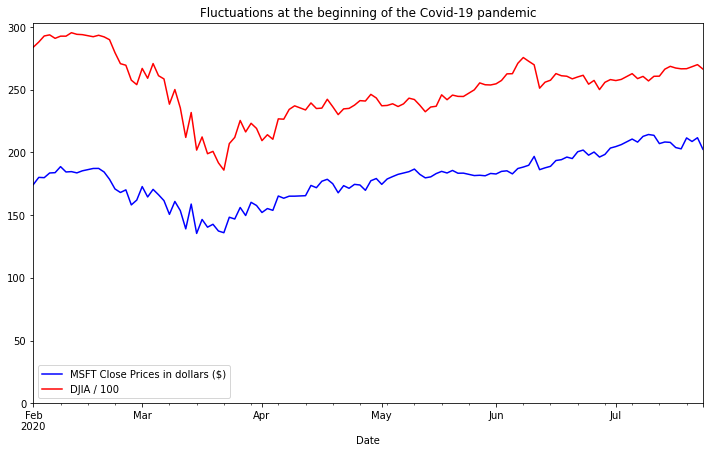

In [387]:
fig, ax = plt.subplots(figsize = (12,7))
df['2020-02-01':'2020-07-23']['Msft Close'].plot(ax=ax, c='b', label='MSFT Close Prices in dollars ($)')
df['2020-02-01':'2020-07-23']['Dow Jones Close'].plot(ax=ax, c='r', label='DJIA / 100')
plt.legend()
plt.ylim(0)
plt.title('Fluctuations at the beginning of the Covid-19 pandemic')
plt.show()

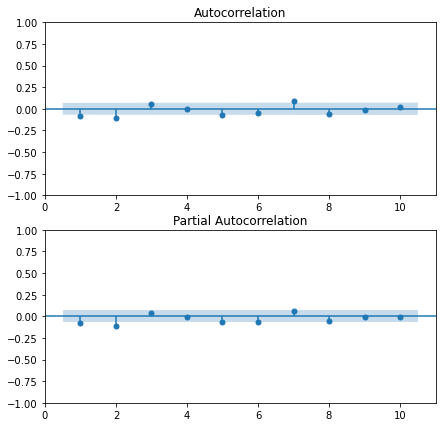

In [388]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7, 7))
plot_acf(covid_df_train['msft diffed'], lags=10, zero=False, ax=ax1)
plot_pacf(covid_df_train['msft diffed'], lags=10, zero=False, ax=ax2, method='ywm')
plt.show()

In [389]:
results_covid_auto = pm.auto_arima(covid_df_train['Msft Close'],
                         start_p=0,  # initial guess for AR(p)
                         start_d=0,  # initial guess for I(d)
                         start_q=0,  # initial guess for MA(q)
                         max_p=4,    # max guess for AR(p)
                         max_d=4,    # max guess for I(d)
                         max_q=4,    # max guess for MA(q)
                         trend='c',
                         information_criterion='aic',
                         trace=True,
                         error_action='ignore'
                         )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2944.878, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2939.640, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2937.873, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2944.878, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2935.292, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2932.388, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2931.966, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2932.321, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2934.250, Time=0.53 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2931.966, Time=0.08 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.371 seconds


In [390]:
covid_df_train

Msft Close  Dow Jones Close  dj shifted  msft diffed  msft sdiffed
Date                                                                          
2017-01-04   62.299999       199.421602  198.817598    -0.280003           NaN
2017-01-05   62.299999       198.992891  199.421602     0.000000      0.280003
2017-01-06   62.840000       199.638008  198.992891     0.540001      0.540001
2017-01-09   62.639999       198.873809  199.638008    -0.200001     -0.740002
2017-01-10   62.619999       198.555293  198.873809    -0.020000      0.180000
...                ...              ...         ...          ...           ...
2020-02-17  186.290001       293.151348  294.106953     1.759995      0.119995
2020-02-18  187.229996       292.321895  293.980801     1.879990      0.119995
2020-02-19  187.279999       293.480293  292.321895     0.050003     -1.829987
2020-02-20  184.419998       292.199805  293.480293    -2.860001     -2.910004
2020-02-21  178.589996       289.924102  292.199805    -5.830002     -2.970001

[818 rows x 5 columns]

In [391]:
covid_df_test

Date
2020-02-24    170.889999
2020-02-25    168.070007
2020-02-26    170.169998
2020-02-27    158.179993
2020-02-28    162.009995
2020-03-02    172.789993
2020-03-03    164.509995
2020-03-04    170.550003
2020-03-05    166.270004
2020-03-06    161.570007
2020-03-09    150.619995
2020-03-10    160.919998
2020-03-11    153.630005
2020-03-12    139.059998
2020-03-13    158.830002
2020-03-16    135.419998
2020-03-17    146.570007
2020-03-18    140.399994
2020-03-19    142.710007
2020-03-20    137.350006
2020-03-23    135.979996
Freq: B, Name: Msft Close, dtype: float64

In [392]:
covid_adf_result = adfuller(covid_df_train['msft diffed'])
print(covid_adf_result)

(-11.05630634513728, 4.9349908079264095e-20, 7, 810, {'1%': -3.438448943858302, '5%': -2.8651148002318227, '10%': -2.568673540618808}, 2894.137853969914)


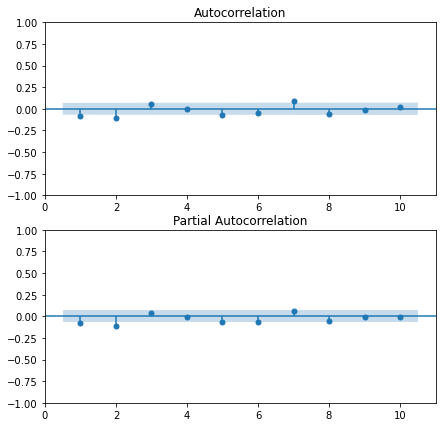

In [393]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7, 7))
plot_acf(covid_df_train['msft diffed'], lags=10, zero=False, ax=ax1)
plot_pacf(covid_df_train['msft diffed'], lags=10, zero=False, ax=ax2, method='ywm')
plt.show()

In [394]:
covid_normal_dif = SARIMAX(covid_df_train['Msft Close'], order = (3,1,1), trend='c')

In [395]:
result_covid_normal_dif = covid_normal_dif.fit()

In [396]:
fore_result_covid_normal_dif = result_covid_normal_dif.forecast(steps=21)

In [397]:
covid_2_rmse = rmse(fore_result_covid_normal_dif, covid_df_test)

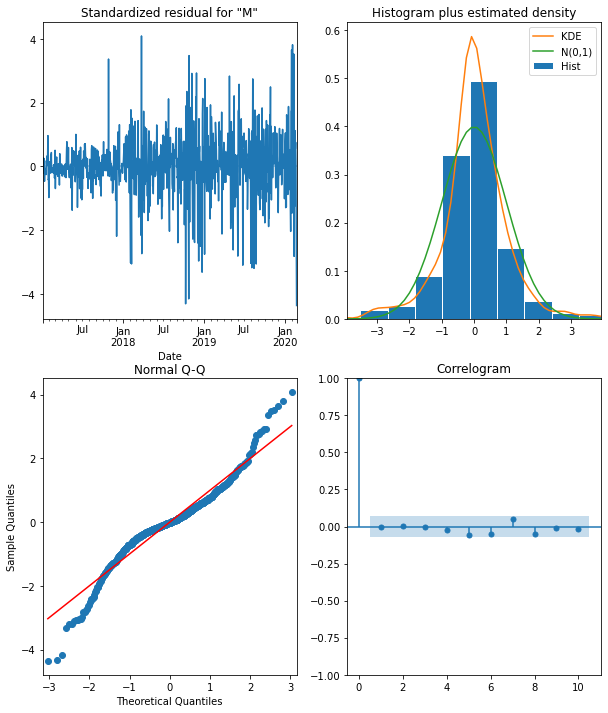

In [398]:
result_covid_normal_dif.plot_diagnostics(figsize = (10, 12))
plt.show()

In [399]:
print(covid_2_rmse)

28.91268158946716


In [400]:
covid_df_train['logged close'] = np.log(covid_df_train['Msft Close'])
covid_df_train.tail()

<ipython-input-400-876fc4ac9abf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df_train['logged close'] = np.log(covid_df_train['Msft Close'])


Msft Close  Dow Jones Close  dj shifted  msft diffed  \
Date                                                               
2020-02-17  186.290001       293.151348  294.106953     1.759995   
2020-02-18  187.229996       292.321895  293.980801     1.879990   
2020-02-19  187.279999       293.480293  292.321895     0.050003   
2020-02-20  184.419998       292.199805  293.480293    -2.860001   
2020-02-21  178.589996       289.924102  292.199805    -5.830002   

            msft sdiffed  logged close  
Date                                    
2020-02-17      0.119995      5.227305  
2020-02-18      0.119995      5.232338  
2020-02-19     -1.829987      5.232605  
2020-02-20     -2.910004      5.217216  
2020-02-21     -2.970001      5.185093

In [401]:
covid_df_train['diffed log'] = covid_df_train['logged close'].diff()
covid_df_train.head()

<ipython-input-401-dfe914a69af0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df_train['diffed log'] = covid_df_train['logged close'].diff()


Msft Close  Dow Jones Close  dj shifted  msft diffed  \
Date                                                               
2017-01-04   62.299999       199.421602  198.817598    -0.280003   
2017-01-05   62.299999       198.992891  199.421602     0.000000   
2017-01-06   62.840000       199.638008  198.992891     0.540001   
2017-01-09   62.639999       198.873809  199.638008    -0.200001   
2017-01-10   62.619999       198.555293  198.873809    -0.020000   

            msft sdiffed  logged close  diffed log  
Date                                                
2017-01-04           NaN      4.131961         NaN  
2017-01-05      0.280003      4.131961    0.000000  
2017-01-06      0.540001      4.140592    0.008630  
2017-01-09     -0.740002      4.137404   -0.003188  
2017-01-10      0.180000      4.137085   -0.000319

In [402]:
covid_df_train = covid_df_train.dropna()

In [403]:
covid_df_train.head()

Msft Close  Dow Jones Close  dj shifted  msft diffed  \
Date                                                               
2017-01-05   62.299999       198.992891  199.421602     0.000000   
2017-01-06   62.840000       199.638008  198.992891     0.540001   
2017-01-09   62.639999       198.873809  199.638008    -0.200001   
2017-01-10   62.619999       198.555293  198.873809    -0.020000   
2017-01-11   63.189999       199.542793  198.555293     0.570000   

            msft sdiffed  logged close  diffed log  
Date                                                
2017-01-05      0.280003      4.131961    0.000000  
2017-01-06      0.540001      4.140592    0.008630  
2017-01-09     -0.740002      4.137404   -0.003188  
2017-01-10      0.180000      4.137085   -0.000319  
2017-01-11      0.590000      4.146146    0.009061

In [404]:
cov_log_adf = adfuller(covid_df_train['diffed log'])
print(cov_log_adf)

(-13.518017016635325, 2.769891683547196e-25, 5, 811, {'1%': -3.4384389256151358, '5%': -2.8651103842072048, '10%': -2.568671188193778}, -4621.195506612436)


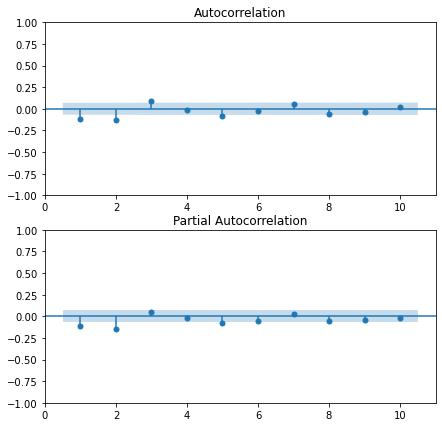

In [405]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7, 7))
plot_acf(covid_df_train['diffed log'], lags=10, zero=False, ax=ax1)
plot_pacf(covid_df_train['diffed log'], lags=10, zero=False, ax=ax2, method='ywm')
plt.show()

In [406]:
results_covid_auto_log = pm.auto_arima(covid_df_train['logged close'],
                         start_p=0,  # initial guess for AR(p)
                         start_d=0,  # initial guess for I(d)
                         start_q=0,  # initial guess for MA(q)
                         max_p=4,    # max guess for AR(p)
                         max_d=4,    # max guess for I(d)
                         max_q=4,    # max guess for MA(q)

                         trend='c',
                         information_criterion='aic',
                         trace=True,
                         error_action='ignore'
                         )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4727.792, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4736.548, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4740.180, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4727.792, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4746.232, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4751.376, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4751.566, Time=0.24 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4751.975, Time=0.31 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-4750.205, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4749.839, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-4748.301, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-4751.975, Time=0.25 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 2.593 seconds


In [407]:
model_log_covid = SARIMAX(covid_df_train['logged close'], order=(3,1,0), trend='c')

In [408]:
result_log_covid = model_log_covid.fit()

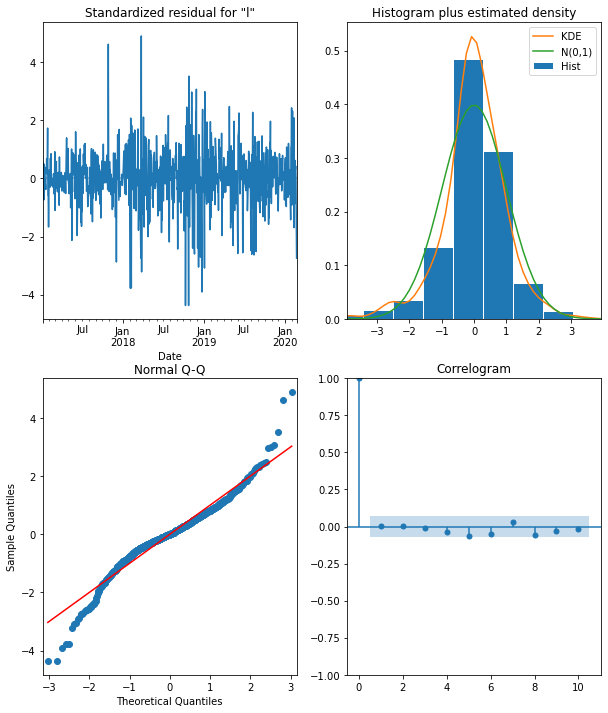

In [409]:
result_log_covid.plot_diagnostics(figsize = (10,12))
plt.show()

In [410]:
fore_log_covid = result_log_covid.forecast(steps= 21)

In [411]:
fore_log_covid_back = np.exp(fore_log_covid)

In [412]:
covid_df_train

Msft Close  Dow Jones Close  dj shifted  msft diffed  \
Date                                                               
2017-01-05   62.299999       198.992891  199.421602     0.000000   
2017-01-06   62.840000       199.638008  198.992891     0.540001   
2017-01-09   62.639999       198.873809  199.638008    -0.200001   
2017-01-10   62.619999       198.555293  198.873809    -0.020000   
2017-01-11   63.189999       199.542793  198.555293     0.570000   
...                ...              ...         ...          ...   
2020-02-17  186.290001       293.151348  294.106953     1.759995   
2020-02-18  187.229996       292.321895  293.980801     1.879990   
2020-02-19  187.279999       293.480293  292.321895     0.050003   
2020-02-20  184.419998       292.199805  293.480293    -2.860001   
2020-02-21  178.589996       289.924102  292.199805    -5.830002   

            msft sdiffed  logged close  diffed log  
Date                                                
2017-01-05      0.280003      4.131961    0.000000  
2017-01-06      0.540001      4.140592    0.008630  
2017-01-09     -0.740002      4.137404   -0.003188  
2017-01-10      0.180000      4.137085   -0.000319  
2017-01-11      0.590000      4.146146    0.009061  
...                  ...           ...         ...  
2020-02-17      0.119995      5.227305    0.005059  
2020-02-18      0.119995      5.232338    0.005033  
2020-02-19     -1.829987      5.232605    0.000267  
2020-02-20     -2.910004      5.217216   -0.015389  
2020-02-21     -2.970001      5.185093   -0.032123  

[817 rows x 7 columns]

In [413]:
covid_df_test

Date
2020-02-24    170.889999
2020-02-25    168.070007
2020-02-26    170.169998
2020-02-27    158.179993
2020-02-28    162.009995
2020-03-02    172.789993
2020-03-03    164.509995
2020-03-04    170.550003
2020-03-05    166.270004
2020-03-06    161.570007
2020-03-09    150.619995
2020-03-10    160.919998
2020-03-11    153.630005
2020-03-12    139.059998
2020-03-13    158.830002
2020-03-16    135.419998
2020-03-17    146.570007
2020-03-18    140.399994
2020-03-19    142.710007
2020-03-20    137.350006
2020-03-23    135.979996
Freq: B, Name: Msft Close, dtype: float64

In [414]:
log_covid_rmse = rmse(fore_log_covid_back, covid_df_test)
print(log_covid_rmse)

30.22495470091774


In [415]:
model_covid = SARIMAX(covid_df_train['Msft Close'], order = (2,1,2), trend='c')

In [416]:
result_model_covid = model_covid.fit()

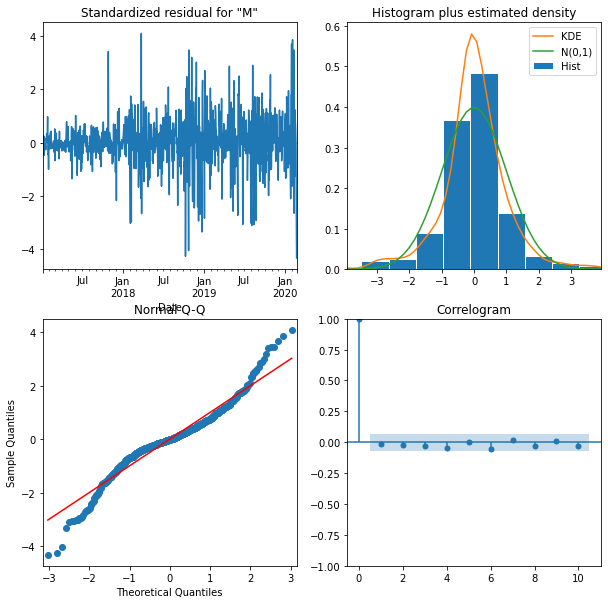

In [417]:
result_model_covid.plot_diagnostics(figsize = (10,10))
plt.show()

In [418]:
fore_covid_model = result_model_covid.forecast(steps=21)

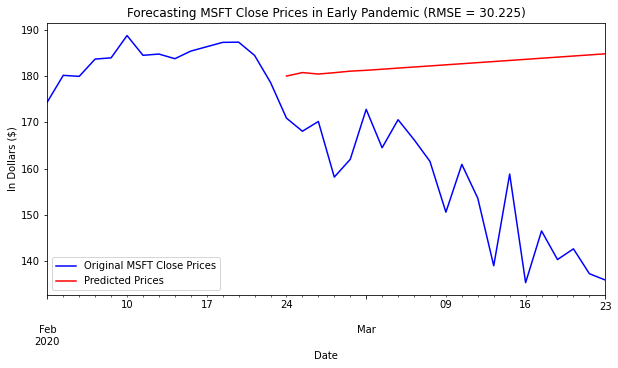

In [419]:
fig, ax = plt.subplots(figsize=(10,5))
df.loc['2020-02-01':'2020-03-23']['Msft Close'].plot(ax=ax, c='b', label='Original MSFT Close Prices')
fore_log_covid_back.plot(ax=ax, c='r', label = 'Predicted Prices')
plt.title('Forecasting MSFT Close Prices in Early Pandemic (RMSE = 30.225)')
plt.ylabel('In Dollars ($)')
plt.legend(loc='lower left')
plt.show()

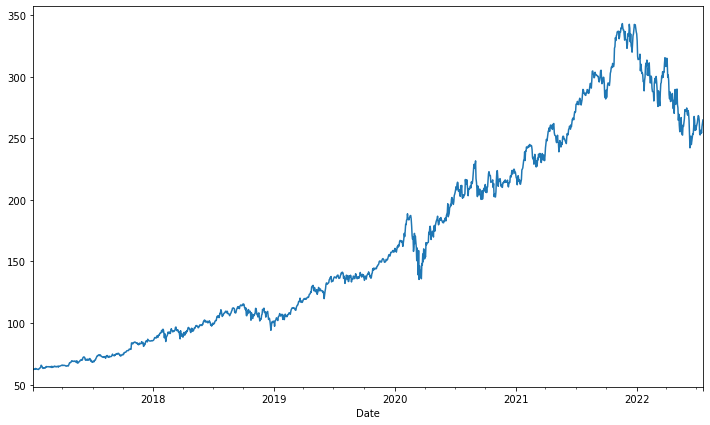

In [420]:
df['Msft Close'].plot(figsize = (12,7))
plt.show()

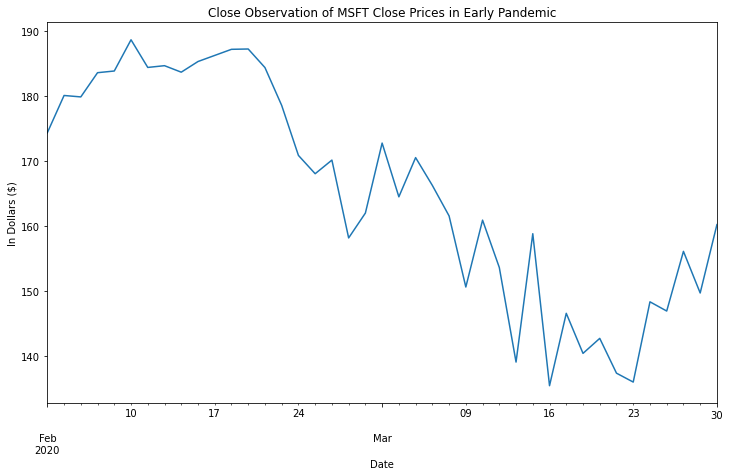

In [421]:
df.loc['2020-02-01':'2020-03-30']['Msft Close'].plot(figsize = (12,7))
plt.title('Close Observation of MSFT Close Prices in Early Pandemic')
plt.ylabel('In Dollars ($)')
plt.show()

In [422]:
covid_rmse = rmse(fore_covid_model, covid_df_test)
print(covid_rmse)

28.54610470389795


In [423]:
df.head()

Msft Close  Dow Jones Close  dj shifted  msft diffed  msft sdiffed
Date                                                                          
2017-01-04   62.299999       199.421602  198.817598    -0.280003           NaN
2017-01-05   62.299999       198.992891  199.421602     0.000000      0.280003
2017-01-06   62.840000       199.638008  198.992891     0.540001      0.540001
2017-01-09   62.639999       198.873809  199.638008    -0.200001     -0.740002
2017-01-10   62.619999       198.555293  198.873809    -0.020000      0.180000

In [424]:
df['Msft Close'].corr(df['Dow Jones Close'])

0.9389314997322454

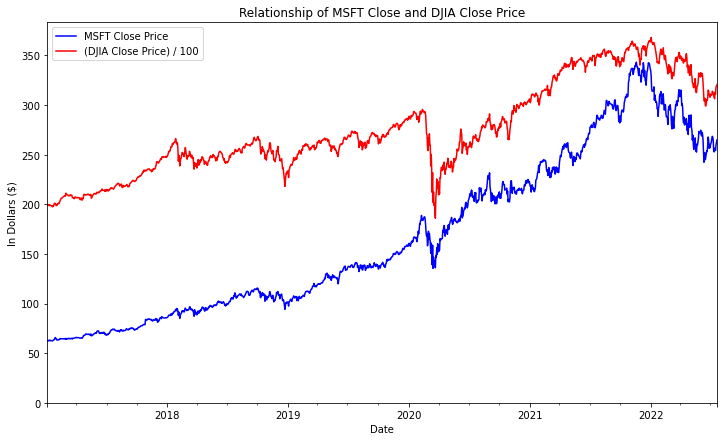

In [425]:
fig, ax = plt.subplots(figsize = (12,7))
df['Msft Close'].plot(ax=ax , c = 'b', label = 'MSFT Close Price')
df['Dow Jones Close'].plot(ax=ax, c = 'r', label = '(DJIA Close Price) / 100')
plt.legend()
plt.ylim(0)
plt.ylabel('In Dollars ($)')
plt.title('Relationship of MSFT Close and DJIA Close Price')
plt.show()

# TRAINING DATASETS

In [429]:
print(df.head(), df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1447 entries, 2017-01-04 to 2022-07-21
Freq: B
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Msft Close       1447 non-null   float64
 1   Dow Jones Close  1447 non-null   float64
 2   dj shifted       1447 non-null   float64
 3   msft diffed      1447 non-null   float64
 4   msft sdiffed     1446 non-null   float64
dtypes: float64(5)
memory usage: 100.1 KB
            Msft Close  Dow Jones Close  dj shifted  msft diffed  msft sdiffed
Date                                                                          
2017-01-04   62.299999       199.421602  198.817598    -0.280003           NaN
2017-01-05   62.299999       198.992891  199.421602     0.000000      0.280003
2017-01-06   62.840000       199.638008  198.992891     0.540001      0.540001
2017-01-09   62.639999       198.873809  199.638008    -0.200001     -0.740002
2017-01-10   62.619999       1

In [430]:
print(df_week.head(), df_week.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 287 entries, 2017-01-20 to 2022-07-15
Freq: W-FRI
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Msft Close       287 non-null    float64
 1   Dow Jones Close  287 non-null    float64
 2   log_msft         287 non-null    float64
 3   log_dj           287 non-null    float64
 4   dj shifted       287 non-null    float64
 5   log_dif_msft     287 non-null    float64
dtypes: float64(6)
memory usage: 15.7 KB
            Msft Close  Dow Jones Close  log_msft    log_dj  dj shifted  \
Date                                                                      
2017-01-20   62.537000       198.094781  4.135758  5.288746    5.293043   
2017-01-27   64.041999       199.951520  4.159539  5.298075    5.288746   
2017-02-03   64.042000       199.365062  4.159539  5.295138    5.298075   
2017-02-10   63.693999       201.277637  4.154090  5.304685    5.295138   
2017-0